In [116]:
""" import useful functions """

import os

# set the environment variable to control the number of threads
original_omp_num_threads = os.environ.get('OMP_NUM_THREADS', None)
os.environ['OMP_NUM_THREADS'] = '1'

import pyccl as ccl

# Multiprocessing tools
from multiprocessing import Pool, cpu_count
import parallelbar

# Generic
import pandas as pd
import numpy as np
import scipy
from itertools import islice, cycle
import math
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache
import scipy.integrate

# cosmology
from astropy.io import fits
import yaml
import sacc
import time

# covariance - Charlie's version of TJPCov
MODULE_PATH = "/home/c2042999/TJPCov/tjpcov/__init__.py"
MODULE_NAME = "tjpcov"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from tjpcov.covariance_calculator import CovarianceCalculator

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
#import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from chainconsumer import ChainConsumer, Chain, make_sample
from IPython.display import display, Math
from tqdm import tqdm

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# MGCAMB
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

# f(R) emu (eMANTIS)
from emantis import FofrBoost

In [2]:
#reload(camb)

In [3]:
"""For tests"""

cosmo_testing = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)

cosmo_testing_linear = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9,
                           matter_power_spectrum='linear')

In [4]:
# Initialise EMANTIS emulator.
emu_fR = FofrBoost()

# 1. Create mock redshift distribution (define z and output Binned_distribution(z))

## METHOD1: Create mock redshift distribution (define z and output dNdz)

In [4]:
""" Get a binned redshift distribution - defining functions """
"""This will come from the dataset we decide to test"""

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z, z0, beta):
    """
    Defines a reasonable redshift distribution (not normalized yet)
    input:
        redshift z: numpy.array with dim:N
    returns:
        redshift distribution p(z): numpy.array with dim:N
    """
    alpha = 2
    pz = z**alpha * np.exp(-(z / z0)**beta)
    return pz

def bindist(z, n_bins, z0, beta):
    """
    Finds redshift bins so that integral of p(z) over each bin stays the same.
    (in limit of large len(z))
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int (value M)
    returns:
        redshift bin edges: numpy.array with dim:M+1
    """
    # have redshiftdist(z), z 
    # find bins: integrate between 0 and i redshift(z)
    #            if integral => 1/n_bin, that is a bin
    #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z, z0, beta)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N                                                             # Normalize p(z)
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

def gaussianphotoz(zs , zp):
    """
    Finds gaussian photo-z uncertainties
    """
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

def binning_redshiftdist(z , n_bins, z0, beta):
    """
    bins distribution for p(z) in n_bins with same number of galaxies in each bin, 
    smoothened by gaussianphotoz(zs , zp) kernel
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int of size M
    returns:
        binned redshift distribution: numpy.array with dim:(N,M)
        sum: p(z) recovered by summing over all binned redshift distributions: numpy.array with dim:N
    """
    N = scipy.integrate.simps(redshiftdist(z, z0, beta), z)

    # complete binning
    bin_edges = bindist(z, n_bins, z0, beta)

    # smoothing redshift distribution with gaussian kernel
    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j], z0, beta)/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [140]:
""" Get a binned source redshift distribution"""

# find normalized redshift distribution
beta = 0.78
z0 = 0.13

z = np.linspace(0.001 , 3.0 , 256)

Rdist_source = redshiftdist(z, z0, beta)
N_source = scipy.integrate.simps(Rdist_source, z)                                    # Normalization factor
Rdist_source = Rdist_source/N_source

Binned_distribution_source = binning_redshiftdist(z , 5, z0, beta)[0]

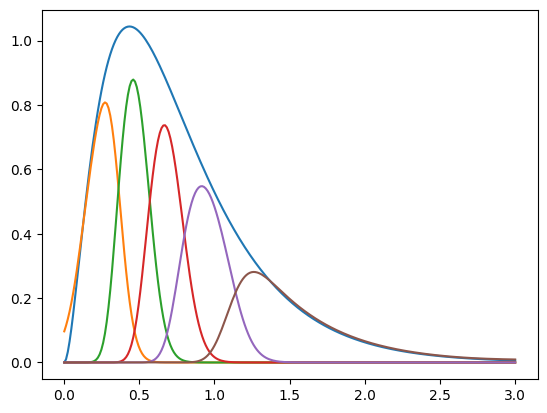

In [141]:
## TEST2: Plots to check binned source redshift distribution


plt.plot(z , Rdist_source)
plt.plot(z ,Binned_distribution_source[0])
plt.plot(z ,Binned_distribution_source[1])
plt.plot(z ,Binned_distribution_source[2])
plt.plot(z ,Binned_distribution_source[3])
plt.plot(z ,Binned_distribution_source[len(Binned_distribution_source)-1])


In [142]:
""" Get a binned lens redshift distribution"""

# find normalized redshift distribution
beta = 0.94
z0 = 0.26

Rdist_lens = redshiftdist(z, z0, beta)
N_lens = scipy.integrate.simps(Rdist_lens, z)                                    # Normalization factor
Rdist_lens = Rdist_lens/N_lens

Binned_distribution_lens = binning_redshiftdist(z , 5, z0, beta)[0]

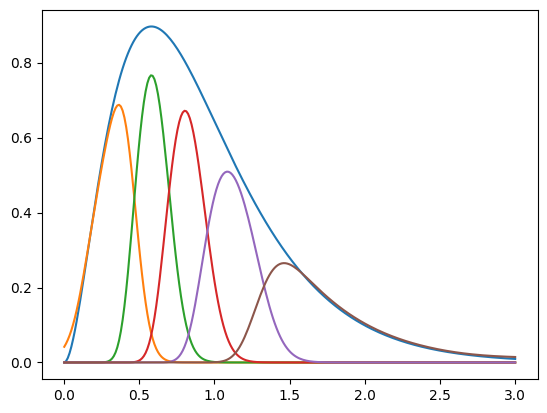

In [143]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist_lens)
plt.plot(z ,Binned_distribution_lens[0])
plt.plot(z ,Binned_distribution_lens[1])
plt.plot(z ,Binned_distribution_lens[2])
plt.plot(z ,Binned_distribution_lens[3])
plt.plot(z ,Binned_distribution_lens[len(Binned_distribution_lens)-1])


## METHOD2: Get mock redshift distribution from SRD

In [5]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 500)
forecast_years = ["1", "10"]  # Assuming integers are appropriate

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


bins = {
    "sources": {},
    "lenses": {}
}

# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=True,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=True,
                                                           save_file=False)


#(5, 256)
Binned_distribution_lens = [list(bins["lenses"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_lens = np.append(Binned_distribution_lens,\
               [list(bins["lenses"]["1"].items())[i+1][1]], axis=0)

Binned_distribution_source = [list(bins["sources"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_source = np.append(Binned_distribution_source,\
               [list(bins["sources"]["1"].items())[i+1][1]], axis=0)
    
print(Binned_distribution_lens.shape)
print(Binned_distribution_source.shape)
print(redshift_range.shape)

(5, 500)
(5, 500)
(500,)


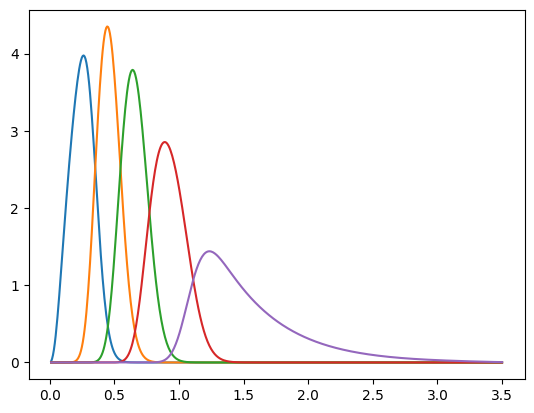

In [6]:
## TEST1: Plots to check binned source redshift distribution
z = redshift_range

plt.plot(z ,Binned_distribution_source[0])
plt.plot(z ,Binned_distribution_source[1])
plt.plot(z ,Binned_distribution_source[2])
plt.plot(z ,Binned_distribution_source[3])
plt.plot(z ,Binned_distribution_source[len(Binned_distribution_source)-1])


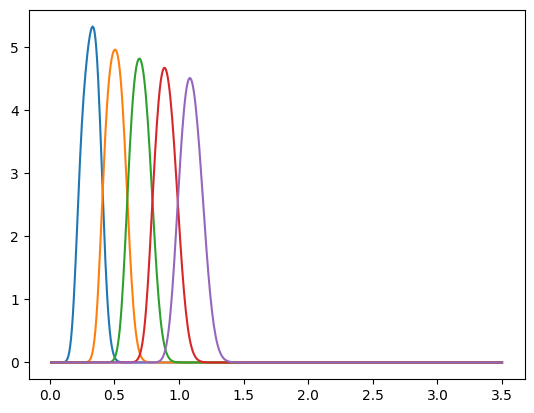

In [7]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z ,Binned_distribution_lens[0])
plt.plot(z ,Binned_distribution_lens[1])
plt.plot(z ,Binned_distribution_lens[2])
plt.plot(z ,Binned_distribution_lens[3])
plt.plot(z ,Binned_distribution_lens[len(Binned_distribution_lens)-1])

## 1b. Create mock bias distribution

In [8]:
# Match SRD
# from Table 2 in https://arxiv.org/pdf/2212.09345
Bias_distribution_fiducial = np.array([1.229*np.ones(len(z)),
                             1.362*np.ones(len(z)),
                             1.502*np.ones(len(z)),
                             1.648*np.ones(len(z)),
                             1.799*np.ones(len(z))])

# 2. Define functions to get various (P(k)) from Emulators, etc.

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe (i.e. $\approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=z_{ini})}\Big)^2P^{nDGP}_{\delta}(z=z_{ini})$

Therefore 

$P^{nDGP}_{\delta}(z=z_{ini}) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)} \times \frac{D_+^{nDGP}(z=z_{ini})}{D_+^{\Lambda CDM}(z=z_{ini})}
\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$.

## Non-linear matter power spectra (f(R) and nDGP)

In [9]:
"""Non-linear matter power spectra (f(R) and nDGP)"""

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    H0rc, fR0, n, mu, Sigma = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}

    pkratio_nDGP = model_nDGP.predict(H0rc, 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_nDGP*Pk_ccl

# NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity, units (Mpc)^3
    """
    H0rc, fR0, n, mu, Sigma = MGparams

    sigma8_VAL_lcdm = ccl.sigma8(cosmo)
    
    pkratio_fR = emu_fR.predict_boost(cosmo["Omega_m"], sigma8_VAL_lcdm, -np.log10(fR0), a, k = k/cosmo["h"])
    # k is in units [h/Mpc]

    Pk_ccl = ccl.power.nonlin_power(cosmo, k, a=a) # units (Mpc)^3
    Pk = pkratio_fR*Pk_ccl

    return Pk

## Linear matter power spectra (f(R) and nDGP)

In [10]:
"""Linear matter power spectra nDGP"""

# dimensionless hubble parameter in GR
def E(cosmoMCMCStep, a):
    Omg_r = cosmoMCMCStep["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmoMCMCStep["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmoMCMCStep["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

# mu(k,a) = mu(a) in nDGP (modified gravity parametrization parameter)
def mu_nDGP(MGparams, cosmo, a):
    H0rc, fR0, n, mu, Sigma = MGparams
    if H0rc == 0: # just by convention, we want MGParams = [0,0,0,0] to be gr
        return 1
    elif 1/(4*H0rc**2) == 0:
        return 1
    else:
        Omg_rc = 1/(4*H0rc**2)
        E_val = E(cosmo, a)
        # from ReACT paper
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta
    
def solverGrowth_nDGP(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    mu = mu_nDGP(MGparams, cosmo, a)
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n,mu])
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    
    # Get growth factor in nDGP and GR
    H0rc, fR0, n, mu, Sigma = MGparams
    
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    
    Pk_GR = ccl.linear_matter_power(cosmo, k=k, a=a)

    # find the index for matter domination)
    #idx_mdom = np.argmax(a_solver**(-3) / E(cosmo, a_solver)**2)          
    idx_mdom = 0
    # get normalization at matter domination
    Delta_nDGP_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_nDGP_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


In [11]:
"""Linear matter power spectra f(R)"""

@lru_cache(maxsize=128)  # You can adjust maxsize according to your memory constraints
def create_interpolator(cosmo_values, MGparams_tuple):
    
    H0rc, fR0, n, mu, Sigma = MGparams_tuple

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_values['h'] * 100, 
                       ombh2=cosmo_values['Omega_b'] * cosmo_values['h']**2, 
                       omch2=cosmo_values['Omega_c'] * cosmo_values['h']**2, 
                       omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=cosmo_values['n_s'], As=cosmo_values['A_s'])
    pars.set_mgparams(MG_flag=3, GRtrans=0.0, QSA_flag=4, F_R0=fR0, FRn=1.0)
    pars.NonLinear = camb.model.NonLinear_none
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, zmax=100)
    return PK

def P_k_fR_lin(cosmo, MGparams, k, a):
    if MGparams[1] == 0:
        return ccl.linear_matter_power(cosmo, k=k, a=a)
    else:
        MGparams_tuple = tuple(MGparams)
        PK = create_interpolator(cosmo, MGparams_tuple)
        return PK.P(1/a-1, k)


"""Linear matter power f(R) (function for mu(k,a))"""
def mu_fR(fR0, cosmo, k, a):
    # k is in units 1/Mpc
    # We want H0 in units 1/Mpc, so H0 = 100h/c
    if fR0 == 0:
        return np.ones(len(k))
    else:
        # from ReACT paper
        f0 = fR0 / (cosmo["h"]*100/3e5)**2
        Zi = (cosmo["Omega_m"] + 4*a**3*(1-cosmo["Omega_m"]))/a**3
        Pi = (k/a)**2 + Zi**3/2/f0/(3*cosmo["Omega_m"] - 4)**2
        return 1 + (k/a)**2/3/Pi


## linear matter power spectra (parametrizations)

In [12]:
"""linear matter power spectra (parametrizations)"""
# for now assume sigma = 1

def mu_lin_param(MGparams, cosmoMCMCStep, a):
    H0rc, fR0, n, mu0, Sigma0 = MGparams
    E_val = E(cosmoMCMCStep, a)
    return 1 + mu0/E_val**2

def sigma_lin_param(MGparams, cosmoMCMCStep, a):
    H0rc, fR0, n, mu0, Sigma0 = MGparams
    E_val = E(cosmoMCMCStep, a)
    return 1 + Sigma0/E_val**2

def solverGrowth_musigma(y,a,cosmoMCMCStep, MGparams):
    E_val = E(cosmoMCMCStep, a)
    D , a3EdDda = y

    mu = mu_lin_param(MGparams, cosmoMCMCStep, a)
    Sigma = sigma_lin_param(MGparams, cosmoMCMCStep, a)
    eta = 2*Sigma/mu - 1
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmoMCMCStep["Omega_m"]*D*(mu/eta)/(2*E_val*a**2)]
    return ydot
    
def P_k_musigma(cosmoMCMCStep, MGparams, k, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmoMCMCStep,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    Pk_GR = ccl.linear_matter_power(cosmoMCMCStep, k=k, a=a)

    # find the index for matter domination)
    idx_mdom = np.argmax(a_solver**(-3) / E(cosmoMCMCStep, a_solver)**2)          
    # get normalization at matter domination
    Delta_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


In [13]:
"""Initialize some things (e.g. emulators and MGCAMB)"""
# Load the nDGP emulator
model_nDGP = BoostPredictor()

# Initialize MGCAMB
pars = camb.CAMBparams()


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## sigma_8 and f for MG function

In [14]:
def sigma_8_musigma(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_musigma(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def sigma_8_nDGP(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_nDGP_lin(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def sigma_8_fR(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_fR_lin(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def fsigma8_musigma(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in musigma
    a_solver = np.linspace(1e-3,1,int(1e3))
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]
    
    f_musigma_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_musigma = np.interp(a, a_solver, f_musigma_interp)

    k_val = np.logspace(-4,3,3000)
    return f_musigma * sigma_8_musigma(cosmoMCMCStep, MGparams, a)

def fsigma8_nDGP(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for nDGP, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]

    f_nDGP_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_nDGP = np.interp(a, a_solver, f_nDGP_interp)

    k_val = np.logspace(-4,3,3000)
    return f_nDGP * sigma_8_nDGP(cosmoMCMCStep, MGparams, a)

## Note: only works if we assume mu is approximately independent of k in f(R) !!!!
def solverGrowth_fR(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    H0rc, fR0, n, mu, Sigma = MGparams
    
    mu = mu_fR(fR0, cosmo, 0.1, a)
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    
def fsigma8_fR(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for f(R), units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_fR, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]

    f_fR_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_fR = np.interp(a, a_solver, f_fR_interp)

    k_val = np.logspace(-4,3,3000)
    return f_fR * sigma_8_fR(cosmoMCMCStep, MGparams, a)

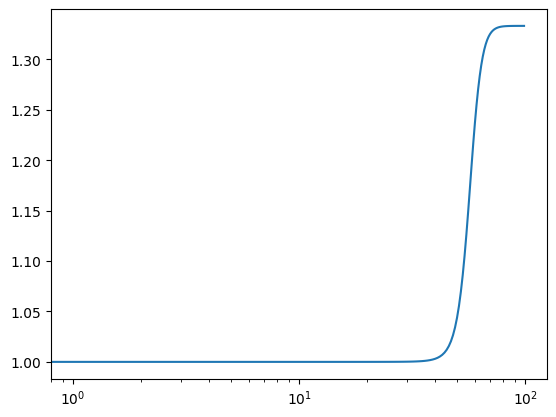

In [20]:
#### Check f(R) approximation of independent of k is ok!
k = np.logspace(-4,2,100)
plt.plot(mu_fR(1e-6, cosmo_testing, k, 1))
plt.xscale("log")

## 2.a. Test functions for P(k)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9999999999995D+00   r2 =  0.4513291153479D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9999999999995D+00   r2 =  0.4803677070691D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9999999999995D+00   r2 =  0.4337459986192D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9999999999995D+00   r2 =  0.4879471805177D-16
 lsoda--  warning..internal t (=r1) 

/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


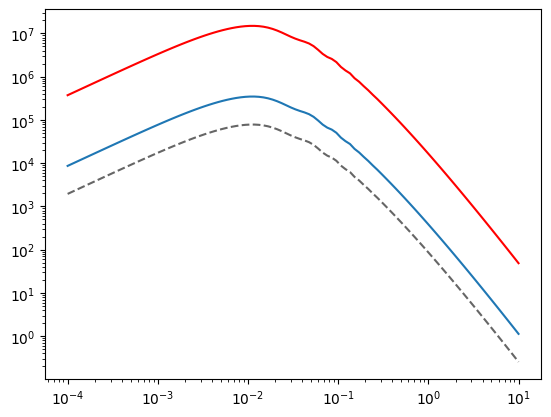

In [140]:
"""Test mu sigma param"""
k_test = np.logspace(-4, 1, 100)


pk_GR_test = ccl.nonlin_matter_power(cosmo_testing, k=k_test, a=1)
pk_GR_test_lin = ccl.linear_matter_power(cosmo_testing, k=k_test, a=1)

# Stable only for mu0 <= 2*Sigma0 + 1.0  (just about)
plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0, 0.0,0.0,2*1.0 + 1.0, 1.0], k_test, 1), "r")
plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,0.95,0.0], k_test, 1))
plt.loglog(k_test,pk_GR_test_lin, "k--", alpha=0.6)

### nDGP

(58,)
(12, 58)
(12, 58)


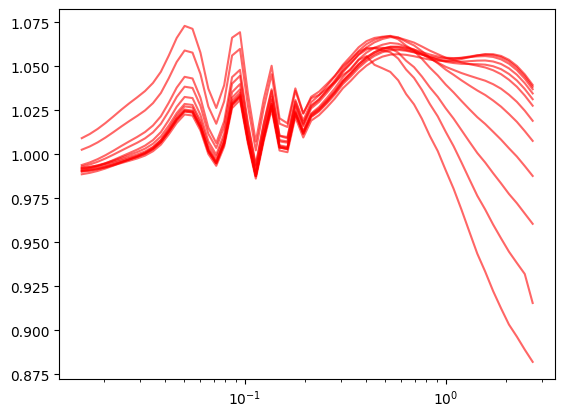

In [141]:
"""Test nDP P(k)"""
"""Load ReACT pre-made plots"""

# nDGP
arr = np.loadtxt("/home/c2042999/REACT_inst2/Lin_NL_nDGP_pk.txt")

# Cosmo and MG parameters same as in ReACT
Omegarc_arr = np.logspace(np.log10(0.2),np.log10(20)-0.001,12)

k_ReACT = arr[0][60:-10] * cosmo_testing["h"] # 1/Mpc
print(k_ReACT.shape)
pofk_lin_MG_react = arr[13:][:,60:-10] / cosmo_testing["h"]**3 # Mpc^3
print(pofk_lin_MG_react.shape)
pofk_NL_MG_react = arr[1:13][:,60:-10]  / cosmo_testing["h"]**3 # Mpc^3
print(pofk_NL_MG_react.shape)


for i in range(len(Omegarc_arr)):
    Pk_nDGP_NL_test = P_k_NL_nDGP(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_NL_test/Pk_nDGP_lin_test) / (pofk_NL_MG_react[i]/pofk_lin_MG_react[i]), "r", alpha=0.6)

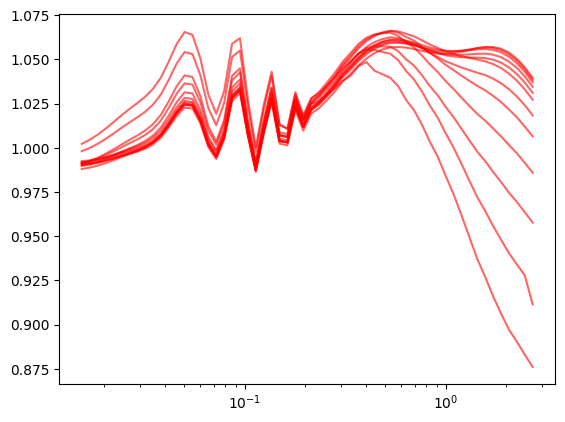

In [142]:
"""Test nDP P(k)"""

for i in range(len(Omegarc_arr)):
    Pk_nDGP_NL_test = P_k_NL_nDGP(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_NL_test) / (pofk_NL_MG_react[i]), "r", alpha=0.6)

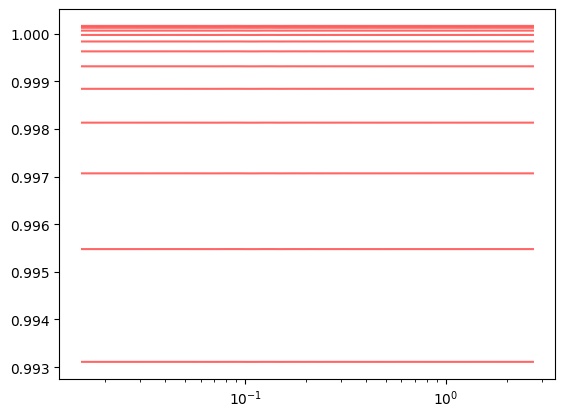

In [143]:
"""Test nDP P(k)"""

for i in range(len(Omegarc_arr)):
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_lin_test) / (pofk_lin_MG_react[i]), "r", alpha=0.6)

In [163]:
"""Test nDGP with extended k,a"""
def pk_func_nDGP(cosmo, MGParams, k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - 0.0156606*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - 4.99465*cosmo["h"])) -1
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [164]:
idx_max = np.argmin(np.abs(k_test - 4.99465*cosmo_testing["h"])) - 1

pk_test = pk_func_nDGP(cosmo_testing, [0.2,0,0,0,0], k_test, 1)
pk_test_lin = P_k_nDGP_lin(cosmo_testing, [0.2,0,0,0,0], k_test, 1)
pk_test1 = pk_func_nDGP(cosmo_testing, [20,0,0,0,0], k_test, 1)
pk_test1_lin = P_k_nDGP_lin(cosmo_testing, [20,0,0,0,0], k_test, 1)


(100.0, 200000.0)

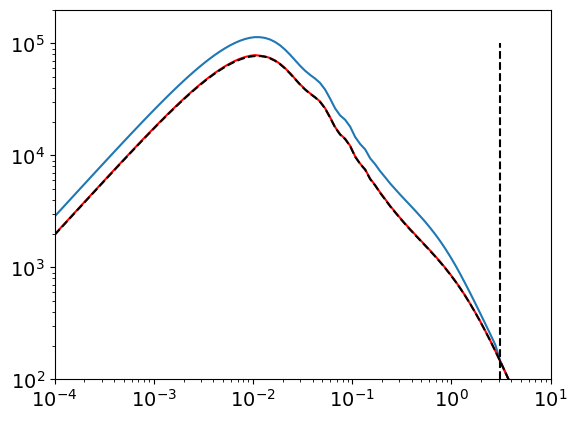

In [165]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
#plt.loglog(k_test,pk_test1_lin, "r")
plt.loglog(k_test,pk_GR_test, "k--")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e2,1e5], "k--")
plt.xlim(1e-4,1e1)
plt.ylim(1e2,2e5)

### f(R)

In [194]:
k_test_fR = np.logspace(-1.8, 0, 100)
pk_GR_test_fR = ccl.nonlin_matter_power(cosmo_testing, k=k_test_fR, a=1)
pk_GR_test_lin_fR = ccl.linear_matter_power(cosmo_testing, k=k_test_fR, a=1)

pk_test_fR = P_k_NL_fR(cosmo_testing, [0.0,1e-4,1,0,0], k_test_fR, 1)

pk_test_fR_lin = P_k_fR_lin(cosmo_testing, [0.0,1e-4,1,0,0], k_test_fR, 1)

1.0


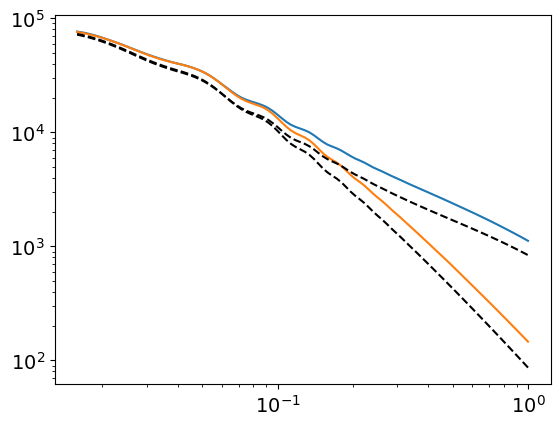

In [195]:
plt.loglog(k_test_fR,pk_test_fR)
plt.loglog(k_test_fR,pk_test_fR_lin)
plt.loglog(k_test_fR,pk_GR_test_fR, "k--")
plt.loglog(k_test_fR,pk_GR_test_lin_fR, "k--")
print(pk_test[0]/pk_test_lin[0])

In [203]:
"""Test f(R) with extended k,a"""
def pk_func_fR(cosmo, MGParams, k, a):
        # condition on z
        if a < 0.3333:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - (emu_fR.kbins[0])*cosmo["h"])) 
            idx_max = np.argmin(np.abs(k - (emu_fR.kbins[-1])*cosmo["h"]))
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_fR_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_fR(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [204]:
idx_max = np.argmin(np.abs(k_test - (emu_fR.kbins[-1])*cosmo_testing["h"])) -1

pk_test = pk_func_fR(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)
pk_test_lin = P_k_fR_lin(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)
pk_test1 = pk_func_fR(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)
pk_test1_lin = P_k_fR_lin(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)

Exception: Requested wavenumber, k=0.0280, is outside the emulation range (0.0288 <= k <= 9.7299).
New simulations will allow emulation for smaller wavenumbers in the future.
Please contact inigo.saez-casares@obspm.fr if needed.
For the moment, it is possible extrapolate linearly in log10(k) to smaller wavenumbers by setting extrapolate_low_k=True (use it with great caution!).

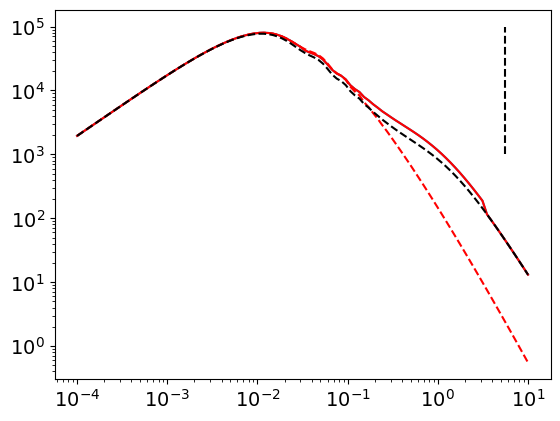

In [170]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
plt.loglog(k_test,pk_test1_lin, "r--")
plt.loglog(k_test,pk_GR_test, "k--")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e3,1e5], "k--")

### General - test relation mu/MG params

/tmp/ipykernel_2328912/802099602.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(k_test,pk_test_fR, "g")


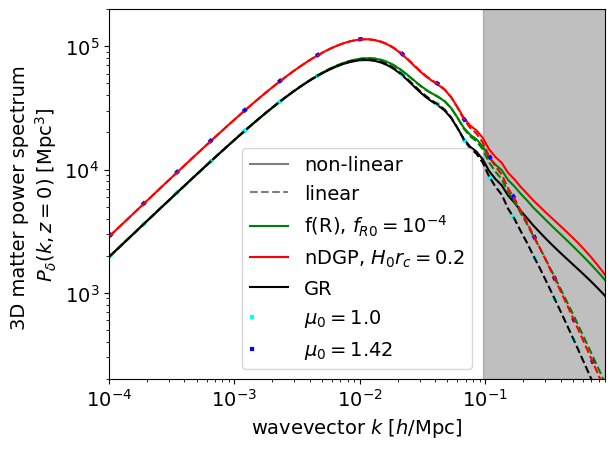

In [184]:
# Set the font size
plt.rcParams['font.size'] = 14

plt.plot([0,0],[0,0], "k", alpha=0.5)
plt.plot([0,0],[0,0], "k--", alpha=0.5)

pk_test_fR = pk_func_fR(cosmo_testing, [0.0,1e-4,1,0,0], k_test, 1)
pk_test_fR_lin = P_k_fR_lin(cosmo_testing, [0.0,1e-4,1,0,0], k_test, 1)
pk_test_nDGP = pk_func_nDGP(cosmo_testing, [0.2,1e-4,1,0,0], k_test, 1)
pk_test_nDGP_lin = P_k_nDGP_lin(cosmo_testing, [0.2,1e-4,1,0,0], k_test, 1)

plt.loglog(k_test,pk_test_fR, "g")
plt.loglog(k_test,pk_test_nDGP, "r")
plt.loglog(k_test,pk_GR_test, "k")

plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1), color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1), color="blue", linestyle=(0,(1,10)),linewidth=3.0)

plt.loglog(k_test,pk_test_fR_lin, "g--")
plt.loglog(k_test,pk_test_nDGP_lin, "r--")
plt.loglog(k_test,pk_GR_test_lin, "k--")

plt.fill_between(k_test, 2e2, 2e5, where=(k_test >= 9e-2), color='gray', alpha=0.5)

plt.xlim(1e-4,0.9)
plt.ylim(2e2,2e5)
plt.ylabel("3D matter power spectrum \n" + r"$P_{\delta}(k, z = 0)$ $[\text{Mpc}^3]$", fontsize=14)
plt.xlabel(r"wavevector $k$ $[h/\text{Mpc}]$", fontsize=14)
plt.legend(["non-linear", "linear",r"f(R), $f_{R0} = 10^{-4}$", r"nDGP, $H_0r_c = 0.2$", "GR",  r"$\mu_0 = 1.0$",r"$\mu_0 = {0:.2f}$".format(1.415)])


#plt.savefig("/home/c2042999/PCA_project/Pk_linNL_compare.pdf", bbox_inches='tight')

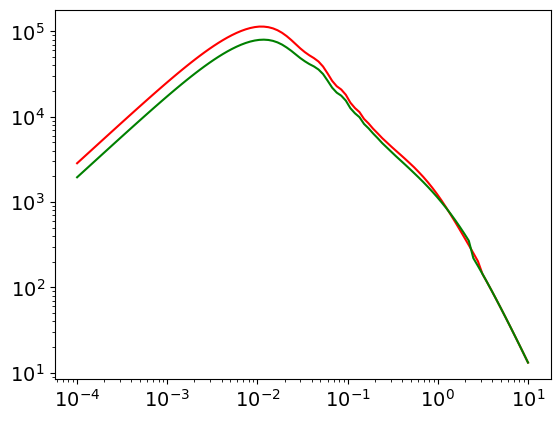

In [185]:
plt.loglog(k_test,pk_test_nDGP, "r")
plt.loglog(k_test,pk_test_fR, "g")

/tmp/ipykernel_2328912/3067353496.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax0.loglog(k_test,pk_test_fR, "g")


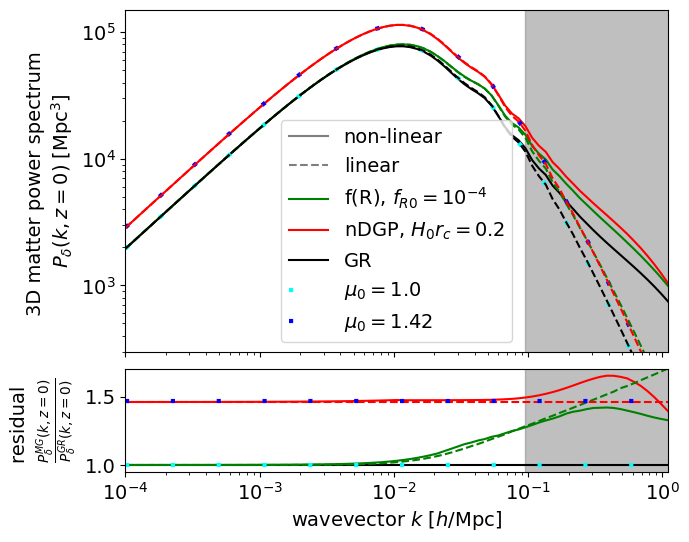

In [186]:
fig,axs = plt.subplots(2,1,gridspec_kw={'height_ratios': [10,3]}, sharex = True, figsize=(7,6))
fig.subplots_adjust(hspace=0.08)
ax0 = axs[0]
ax1 = axs[1]

##### ax0 - P(k) #####
ax0.tick_params(axis='x',labelcolor='w')

ax0.plot([0,0],[0,0], "k", alpha=0.5)
ax0.plot([0,0],[0,0], "k--", alpha=0.5)

ax0.loglog(k_test,pk_test_fR, "g")
ax0.loglog(k_test,pk_test_nDGP, "r")
ax0.loglog(k_test,pk_GR_test, "k")

ax0.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1), color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
ax0.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1), color="blue", linestyle=(0,(1,10)),linewidth=3.0)

ax0.loglog(k_test,pk_test_fR_lin, "g--")
ax0.loglog(k_test,pk_test_nDGP_lin, "r--")
ax0.loglog(k_test,pk_GR_test_lin, "k--")

ax0.fill_between(k_test, 2e2, 2e5, where=(k_test >= 9e-2), color='gray', alpha=0.5)

ax0.set_xlim(1e-4,1.1)
ax0.set_ylim(3e2,1.5e5)
ax0.set_ylabel("3D matter power spectrum \n" + r"$P_{\delta}(k, z = 0)$ $[\text{Mpc}^3]$", fontsize=14)
ax0.legend(["non-linear", "linear",r"f(R), $f_{R0} = 10^{-4}$", r"nDGP, $H_0r_c = 0.2$", "GR",  r"$\mu_0 = 1.0$",r"$\mu_0 = {0:.2f}$".format(1.415)])

##### ax1 - residual P(k)/P_{GR}(k) #####
ax1.set_xlabel(r"wavevector $k$ $[h/\text{Mpc}]$", fontsize=14)
ax1.set_ylabel("residual \n" + r"$\frac{P_{\delta}^{MG}(k, z = 0)}{P_{\delta}^{GR}(k, z = 0)}$", fontsize=14)

ax1.semilogx(k_test,pk_GR_test/pk_GR_test, "k")
ax1.semilogx(k_test,pk_test_fR/pk_GR_test, "g")
ax1.semilogx(k_test,pk_test_nDGP/pk_GR_test, "r")

ax1.semilogx(k_test,pk_test_fR_lin/pk_GR_test_lin, "g--")
ax1.semilogx(k_test,pk_test_nDGP_lin/pk_GR_test_lin, "r--")

ax1.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1)/pk_GR_test_lin, color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
ax1.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1)/pk_GR_test_lin, color="blue", linestyle=(0,(1,10)),linewidth=3.0)


ax1.set_ylim(0.95,1.7)

ax1.fill_between(k_test, 0.9, 2.0, where=(k_test >= 9e-2), color='gray', alpha=0.5)
#plt.savefig("/home/c2042999/PCA_project/Pk_linNL_compare-res.pdf", bbox_inches='tight')


/tmp/ipykernel_2328912/4179024587.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.semilogx(k_test,pk_test_fR/pk_GR_test, "g")


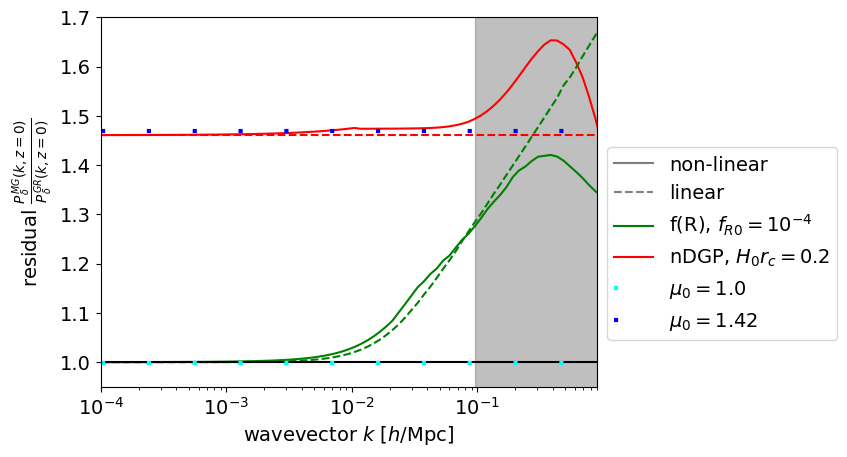

In [187]:
# Set the font size
plt.rcParams['font.size'] = 14


plt.plot([0,0],[0,0], "k", alpha=0.5)
plt.plot([0,0],[0,0], "k--", alpha=0.5)

plt.semilogx(k_test,pk_test_fR/pk_GR_test, "g")
plt.semilogx(k_test,pk_test_nDGP/pk_GR_test, "r")

plt.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1)/pk_GR_test_lin, color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
plt.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1)/pk_GR_test_lin, color="blue", linestyle=(0,(1,10)),linewidth=3.0)

plt.semilogx(k_test,pk_test_fR_lin/pk_GR_test_lin, "g--")
plt.semilogx(k_test,pk_test_nDGP_lin/pk_GR_test_lin, "r--")

plt.fill_between(k_test, 0.5, 2, where=(k_test >= 9e-2), color='gray', alpha=0.5)

line1 = plt.semilogx(k_test,pk_GR_test/pk_GR_test, "k")
plt.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1)/pk_GR_test_lin, color="cyan", linestyle=(0,(1,10)),linewidth=3.0)

plt.xlim(1e-4,0.9)
plt.ylim(0.95,1.7)
plt.ylabel(r"residual $\frac{P_{\delta}^{MG}(k, z = 0)}{P_{\delta}^{GR}(k, z = 0)}$", fontsize=14)
plt.xlabel(r"wavevector $k$ $[h/\text{Mpc}]$", fontsize=14)
plt.legend(["non-linear", "linear",r"f(R), $f_{R0} = 10^{-4}$", r"nDGP, $H_0r_c = 0.2$",  r"$\mu_0 = 1.0$",r"$\mu_0 = {0:.2f}$".format(1.415)],bbox_to_anchor=(1.0,0.1))


#plt.savefig("/home/c2042999/PCA_project/Pk_ratio_linNL_compare.pdf", bbox_inches='tight')

## 2.b. Test functions for fsigma8

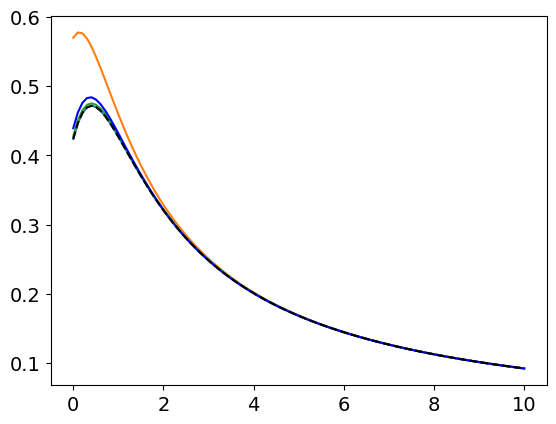

In [77]:
z_testing = np.linspace(0, 10, 100)

plt.plot(z_testing, fsigma8_musigma(cosmo_testing, [0,0,0,0.0,0], 1/(z_testing+1)))
plt.plot(z_testing, fsigma8_musigma(cosmo_testing, [0,0,0,0.2,0], 1/(z_testing+1)))
plt.plot(z_testing, fsigma8_nDGP(cosmo_testing, [20,0,0,0,0], 1/(z_testing+1)))
plt.plot(z_testing, fsigma8_fR(cosmo_testing, [0,1e-6,0,0,0], 1/(z_testing+1)), "b")

sigma_8_vals = np.zeros(len(z_testing))
for i in range(len(z_testing)):
    sigma_8_vals[i] = ccl.power.sigmaR(cosmo_testing, 8/cosmo_testing["h"], a=1/(z_testing[i]+1))

plt.plot(z_testing, ccl.background.growth_rate(cosmo_testing, 1/(z_testing+1))*sigma_8_vals, "k--") 

# 3. Getting C(ell) functions

In [165]:
"""Get n_zbins logarithmically spaced ell bins (total n of ell bins = ell_bin_num)"""
def bin_ell_kk(ell_min, ell_max, ell_bin_num, Binned_distribution):
    # define quantities for binning in ell
    n_zbins = int(((len(Binned_distribution)+1)*len(Binned_distribution))/2)
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = np.repeat([ell_binned], repeats=n_zbins, axis=0)
    
    #ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    return ell_binned
    
"""Get n_zbins logarithmically spaced ell bins (total n of ell bins = ell_bin_num)"""
def bin_ell_delk(ell_min, ell_max, ell_bin_num,Binned_distribution_s, Binned_distribution_l):
    # define quantities for binning in ell
    n_zbins = 0
    for j in range(len(Binned_distribution_l)):
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                n_zbins += 1
    
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = np.repeat([ell_binned], repeats=n_zbins, axis=0)
    
    #ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    return ell_binned

"""Get n_zbins logarithmically spaced ell bins (total n of ell bins = ell_bin_num)"""
def bin_ell_deldel(ell_min, ell_max, ell_bin_num, Binned_distribution):
    # define quantities for binning in ell
    n_zbins = len(Binned_distribution)s
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = np.repeat([ell_binned], repeats=n_zbins, axis=0)
    
    #ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    return ell_binned

## C_ell function (for all cases)

In [166]:
"""Functions to find Cell given a Pdelta_2D ccl object"""

# A: Function for cosmic shear angular power spectrum (lensing-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_kk(P_delta2D_S_funct, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = int(((len(Binned_distribution_s)+1)*len(Binned_distribution_s))/2)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_s)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[j]))
        for k in range(len(Binned_distribution_s)):
            if k >= j:
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx], p_of_k_a=P_delta2D_S_funct)
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# B: Function for galaxy-galaxy lensing angular power spectrum (clustering-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_delk(P_delta2D_S_funct, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    
    n_zbins = 0
    for j in range(len(Binned_distribution_l)):
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                n_zbins += 1
                
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx], p_of_k_a=P_delta2D_S_funct)
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# C: Function for galaxy-galaxy clustering angular power spectrum (clustering-clustering C_ell) from a given P_delta2D_S
def C_ell_arr_deldel(P_delta2D_S_funct, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = len(Binned_distribution_l)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_l)):
            if k == j:
                if start_idx <= idx:
                    tracer2 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[k]), bias=(z, Bias_distribution[k]), has_rsd=False)
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx], p_of_k_a=P_delta2D_S_funct)
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

In [167]:
"""Functions to find Cell given a Pdelta_2D ccl object  - GR"""

# A: Function for cosmic shear angular power spectrum (lensing-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_kk_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = int(((len(Binned_distribution_s)+1)*len(Binned_distribution_s))/2)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_s)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[j]))
        for k in range(len(Binned_distribution_s)):
            if k >= j:
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx])
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# B: Function for galaxy-galaxy lensing angular power spectrum (clustering-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_delk_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    
    n_zbins = 0
    for j in range(len(Binned_distribution_l)):
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                n_zbins += 1
                
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx])
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# C: Function for galaxy-galaxy clustering angular power spectrum (clustering-clustering C_ell) from a given P_delta2D_S
def C_ell_arr_deldel_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = len(Binned_distribution_l)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_l)):
            if k == j:
                if start_idx <= idx:
                    tracer2 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[k]), bias=(z, Bias_distribution[k]), has_rsd=False)
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx])
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

In [168]:
def Get_Pk2D_obj(cosmo, MGParams,linear=False,gravity_model="GR"):
    """
    Finds Get_Pk2D object
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """


    ########### Functions for non-linear matter power spectrum ###########
    def pk_func_nDGP_NL(k, a):
        z = 1 / a - 1
        if z > 2:
            return ccl.nonlin_matter_power(cosmo, k=k, a=a)
        
        # Determine the index range for k
        k_min = 0.0156606 * cosmo["h"]
        k_max = 4.99465 * cosmo["h"]
        
        idx_min = np.searchsorted(k, k_min)
        idx_max = np.searchsorted(k, k_max, side='right')
        
        k_allowed = k[idx_min:idx_max]
        
        # Calculate power spectra for different k ranges
        pk_lin_start = P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a)
        pk_nl_mid = P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)
        pk_nl_end = ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a)
        
        pk = np.concatenate((pk_lin_start, pk_nl_mid, pk_nl_end), axis = 0)
        
        return pk
    
    def pk_func_fR_NL(k, a):        
        z = 1 / a - 1
        
        if a < 0.3333:
            return ccl.nonlin_matter_power(cosmo, k=k, a=a)
        
        # Determine the index range for k
        idx_min = np.argmin(np.abs(k - (emu_fR.kbins[0])*cosmo["h"])) + 1
        idx_max = np.argmin(np.abs(k - (emu_fR.kbins[-1])*cosmo["h"])) -1

        k_min = k[idx_min]
        k_max = k[idx_max]
        k_allowed = k[idx_min:idx_max]
        
        # Calculate power spectra for different k ranges
        pk_lin_start = Pk_low = P_k_fR_lin(cosmo, MGParams, k[:idx_min], a)/ccl.linear_matter_power(cosmo, k=k[:idx_min], a=a) \
                     * ccl.nonlin_matter_power(cosmo, k=k[:idx_min], a=a)
        pk_nl_mid = P_k_NL_fR(cosmo, MGParams, k_allowed, a)
        pk_nl_end = ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a)
        
        pk = np.concatenate((pk_lin_start, pk_nl_mid, pk_nl_end), axis = 0)
        
        return pk
    
    def pk_func_muSigma_NL(k, a):
        raise Exception('there is no non-linear power spectrum available for muSigma parametrization.')
        
    ########### Functions for linear matter power spectrum multiplied by Sigma**2 ###########
    def pk_func_nDGP_lin(k, a):

        # condition on z
        return P_k_nDGP_lin(cosmo, MGParams, k, a)
        
    def pk_func_fR_lin(k, a):
        
        # condition on z
        return P_k_fR_lin(cosmo, MGParams, k, a)
        
    def pk_func_muSigma_lin(k, a):
        # condition on z
        return P_k_musigma(cosmo, MGParams, k, a)

    def invalid_op(k, a):
        raise Exception("Invalid gravity model entered or Linear must be True or False.")

    ops = {
        ("nDGP" , False): pk_func_nDGP_NL, 
        ("f(R)" , False): pk_func_fR_NL, 
        ("muSigma" , False): pk_func_muSigma_NL,
        ("nDGP" , True): pk_func_nDGP_lin, 
        ("f(R)" , True): pk_func_fR_lin, 
        ("muSigma" , True): pk_func_muSigma_lin
    }
    
    ########### Find matter power spectrum multiplied by Sigma**2 ###########
    pk_func = ops.get((gravity_model, linear), invalid_op)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)



In [19]:
########### Functions for NL P(k) multiplied by Sigma - only for Sigma diff 1, so MuSigma param only ###########

def Get_Pk2D_obj_delk_musigma(cosmo, MGParams):
   
    ########### Functions for linear matter power spectrum multiplied by Sigma**2 ###########        
    def pk_funcSigma_muSigma_lin(k, a):
        return sigma_lin_param(MGParams, cosmo,a)*P_k_musigma(cosmo, MGParams, k, a)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_funcSigma_muSigma_lin, is_logp=False)


def Get_Pk2D_obj_deldel_musigma(cosmo, MGParams):
   
    ########### Functions for linear matter power spectrum multiplied by Sigma**2 ###########        
    def pk_funcSigma2_muSigma_lin(k, a):
        return sigma_lin_param(MGParams, cosmo, a)**2 * P_k_musigma(cosmo, MGParams, k, a)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_funcSigma2_muSigma_lin, is_logp=False)




In [20]:
def Cell(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution, MGParams,P_delta2D_S,
         tracer1_type="k", 
         tracer2_type="k"):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins.
    tracer_type = "k", "g"
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if tracer1_type = "k" and tracer2_type = "k", shape-shape angular power spectrum
    if tracer1_type = "k" and tracer2_type = "g", galaxy-galaxy lensing angular power spectrum
    if tracer1_type = "g" and tracer2_type = "g", pos-pos angular power spectrum
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """

    ops = {
        ("k" , "k"): C_ell_arr_kk,
        ("k" , "g"): C_ell_arr_delk, 
        ("g" , "k"): C_ell_arr_delk,
        ("g" , "g"): C_ell_arr_deldel
    }

    def invalid_op2():
        raise ValueError('invalid tracer selected.')
    ########## Find Cell ##########

    C_ell_array_funct = ops.get((tracer1_type, tracer2_type), invalid_op2)
    C_ell_array = C_ell_array_funct(P_delta2D_S, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution)

    return np.array(list(itertools.chain(*ell_binned))), C_ell_array

        

def Cell_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution, MGParams,
         tracer1_type="k", 
         tracer2_type="k"):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins.
    tracer_type = "k", "g"
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if tracer1_type = "k" and tracer2_type = "k", shape-shape angular power spectrum
    if tracer1_type = "k" and tracer2_type = "g", galaxy-galaxy lensing angular power spectrum
    if tracer1_type = "g" and tracer2_type = "g", pos-pos angular power spectrum
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """

    ops = {
        ("k" , "k"): C_ell_arr_kk_GR,
        ("k" , "g"): C_ell_arr_delk_GR, 
        ("g" , "k"): C_ell_arr_delk_GR,
        ("g" , "g"): C_ell_arr_deldel_GR
    }

    def invalid_op2():
        raise ValueError('invalid tracer selected.')
    ########## Find Cell ##########

    C_ell_array_funct = ops.get((tracer1_type, tracer2_type), invalid_op2)
    C_ell_array = C_ell_array_funct(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution)

    return np.array(list(itertools.chain(*ell_binned))), C_ell_array

        
    

## 3d. Test these functions

In [21]:
"""Test C_kk(ell) function"""


binned_ell = bin_ell_kk(20, 1478.5, 13, Binned_distribution_source)
"""nDGP"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=False, gravity_model="nDGP"), tracer1_type="k", tracer2_type="k")

print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata_kk = testdata[1]

D_testdata_kk = (np.array(D_testdata_kk)).flatten()

start = time.time()
testdata_lin = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=True, gravity_model="nDGP"),tracer1_type="k", tracer2_type="k")

print("time2 = ", time.time() - start)

D_testdata_lin_kk = testdata_lin[1]
D_testdata_lin_kk = (np.array(D_testdata_lin_kk)).flatten()

del testdata, testdata_lin

"""fR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

print("time3 = ", time.time() - start)

ell_testdata_fR = testdata_fR[0]
D_testdata_kk_fR = testdata_fR[1]

D_testdata_kk_fR = (np.array(D_testdata_kk_fR)).flatten()

start = time.time()

testdata_lin_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=True, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

print("time4 = ", time.time() - start)

D_testdata_lin_kk_fR = testdata_lin_fR[1]
D_testdata_lin_kk_fR = (np.array(D_testdata_lin_kk_fR)).flatten()

del testdata_fR, testdata_lin_fR

"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="k", tracer2_type="k")
print("time5 = ", time.time() - start)

D_testdata_GR_kk = testdata_GR[1]
D_testdata_GR_kk = (np.array(D_testdata_GR_kk)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(binned_ell, \
                cosmo_testing_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="k", tracer2_type="k")
print("time6 = ", time.time() - start)

D_testdata_GR_lin_kk = testdata_GR_lin[1]
D_testdata_GR_lin_kk = (np.array(D_testdata_GR_lin_kk)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  1.6778452396392822
time2 =  0.2222137451171875
Training the emulator at aexp=0.3333... done.
Training the emulator at aexp=0.3650... done.
Training the emulator at aexp=0.4000... done.
Training the emulator at aexp=0.4167... done.
Training the emulator at aexp=0.4444... done.
Training the emulator at aexp=0.4762... done.
Training the emulator at aexp=0.5000... done.
Training the emulator at aexp=0.5263... done.
Training the emulator at aexp=0.5556... done.
Training the emulator at aexp=0.5882... done.
Training the emulator at aexp=0.6250... done.
Training the emulator at aexp=0.6667... done.
Training the emulator at aexp=0.7042... done.
Training the emulator at aexp=0.7692... done.
Training the emulator at aexp=0.8000... done.
Training the emulator at aexp=0.8696... done.
Training the emulator at aexp=0.9091... done.
Training the emulator at aexp=0.9524... done.
Training the emulator at aexp=1.0000... done.
time3 =  45.738322734832764
time4 =  0.07253241539001465
time5 =  0.04

In [22]:
"""Plots: Test C_kk(ell) function"""
"""
ell_bin_number = 13
print(D_testdata_kk.shape)


for j in range(int(len(D_testdata_kk)/ell_bin_number)):
    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_kk[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_GR_kk[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)
for j in range(int(len(D_testdata_delk)/ell_bin_number)):
    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_delk[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_GR_delk[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)
for j in range(int(len(D_testdata_deldel)/ell_bin_number)):
    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_GR_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)
    #plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)
    #plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR_kk[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha= 0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\kappa\kappa}(\ell)$')
plt.legend(["nDGP", "fR","GR"])
plt.xscale('log')
plt.yscale('log')
plt.show()

"""

<>:2: DeprecationWarning: invalid escape sequence '\e'
<>:2: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_2580384/202807574.py:2: DeprecationWarning: invalid escape sequence '\e'
  """


'\nell_bin_number = 13\nprint(D_testdata_kk.shape)\n\n\nfor j in range(int(len(D_testdata_kk)/ell_bin_number)):\n    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_kk[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)\n    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_GR_kk[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)\nfor j in range(int(len(D_testdata_delk)/ell_bin_number)):\n    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_delk[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)\n    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_GR_delk[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)\nfor j in range(int(len(D_testdata_deldel)/ell_bin_number)):\n    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)\n    plt.plot(ell_testdata[0:ell_bin_number], D_testdata_GR_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)\n    #plt.plot(ell_testdata[j*ell_bin_number:

In [26]:
"""Plots: Test C_kk(ell) difference (need mock as well)"""

"""
for j in range(int(len(D_testdata_kk)/ell_bin_number) - 1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata_kk[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_lin_kk[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "r", alpha=0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_lin_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "g", alpha=0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata_GR_kk[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_GR_lin_kk[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "k", alpha=0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\kappa\kappa,\ell}^{NL}/ C_{\kappa\kappa,\ell}^{lin} - 1$ for all bins')
plt.xscale('log')
plt.legend(["nDGP","f(R)", "GR"])
plt.show()
"""

<>:3: DeprecationWarning: invalid escape sequence '\e'
<>:3: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_2580384/1075237659.py:3: DeprecationWarning: invalid escape sequence '\e'
  """


'\nfor j in range(int(len(D_testdata_kk)/ell_bin_number) - 1):\n    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number],     D_testdata_kk[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_lin_kk[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "r", alpha=0.6)\n\n    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number],     D_testdata_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_lin_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "g", alpha=0.6)\n\n    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number],     D_testdata_GR_kk[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_GR_lin_kk[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "k", alpha=0.6)\n\n\nplt.xlabel(r\'$\\ell$\')\nplt.ylabel(r\'$C_{\\kappa\\kappa,\\ell}^{NL}/ C_{\\kappa\\kappa,\\ell}^{lin} - 1$ for all bins\')\nplt.xscale(\'log\')\nplt.legend(["nDGP","f(R)", "GR"])\nplt.show()\n'

In [27]:
"""Test C_delk(ell) function"""

binned_ell = bin_ell_delk(20, 1478.5, 13, Binned_distribution_source,Binned_distribution_lens)

"""nDGP"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=False, gravity_model="nDGP"),tracer1_type="g", tracer2_type="k")

print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata_delk = testdata[1]

D_testdata_delk = (np.array(D_testdata_delk)).flatten()

start = time.time()
testdata_lin = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=True, gravity_model="nDGP"),tracer1_type="g", tracer2_type="k")

print("time2 = ", time.time() - start)

D_testdata_lin_delk = testdata_lin[1]
D_testdata_lin_delk = (np.array(D_testdata_lin_delk)).flatten()

del testdata, testdata_lin

"""f(R)"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="g", tracer2_type="k")

print("time1 = ", time.time() - start)

ell_testdata_fR = testdata_fR[0]
D_testdata_delk_fR = testdata_fR[1]

D_testdata_delk_fR = (np.array(D_testdata_delk_fR)).flatten()

start = time.time()
testdata_lin_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=True, gravity_model="f(R)"),tracer1_type="g", tracer2_type="k")

print("time2 = ", time.time() - start)

D_testdata_lin_delk_fR = testdata_lin_fR[1]
D_testdata_lin_delk_fR = (np.array(D_testdata_lin_delk_fR)).flatten()

del testdata_fR, testdata_lin_fR


"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="k")

print("time3 = ", time.time() - start)

D_testdata_GR_delk = testdata_GR[1]
D_testdata_GR_delk = (np.array(D_testdata_GR_delk)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(binned_ell, \
                cosmo_testing_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="k")

print("time4 = ", time.time() - start)

D_testdata_GR_lin_delk = testdata_GR_lin[1]
D_testdata_GR_lin_delk = (np.array(D_testdata_GR_lin_delk)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  0.14570951461791992
time2 =  0.19078898429870605
time1 =  0.09884428977966309
time2 =  0.04024648666381836
time3 =  0.017044544219970703
time4 =  0.01776432991027832


(91,)
(91,)


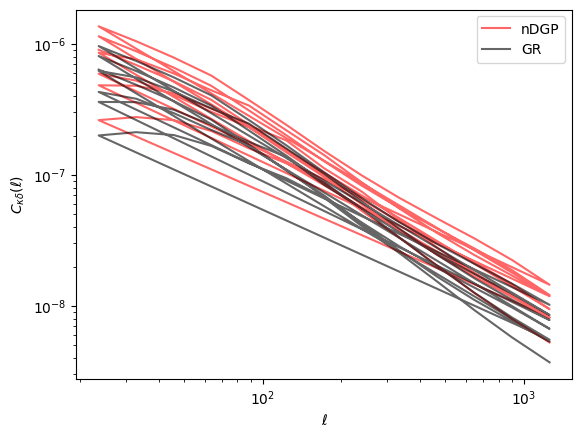

In [28]:
"""Plots: Test C_kk(ell) function"""


print(D_testdata_delk.shape)
print(ell_testdata.shape)

plt.plot(ell_testdata, D_testdata_delk, "r", alpha= 0.6)
plt.plot(ell_testdata, D_testdata_GR_delk, "k", alpha= 0.6)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\kappa\delta}(\ell)$')
plt.legend(["nDGP", "GR"])
plt.xscale('log')
plt.yscale('log')
plt.show()

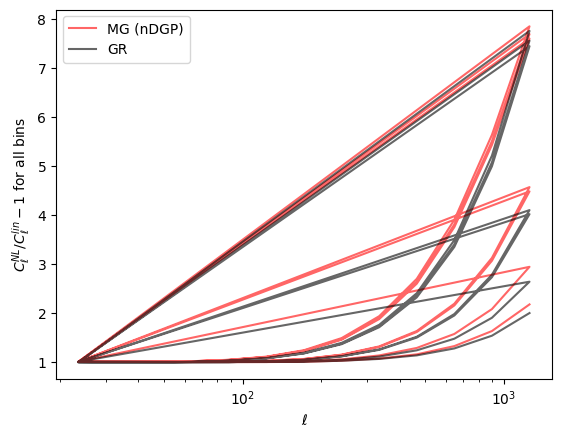

In [29]:
"""Plots: Test C_kk(ell) difference (need mock as well)"""


plt.plot(ell_testdata, D_testdata_delk/D_testdata_lin_delk, "r", alpha= 0.6)
plt.plot(ell_testdata, D_testdata_GR_delk/D_testdata_GR_lin_delk, "k", alpha= 0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{NL}/ C_\ell^{lin} - 1$ for all bins')
plt.xscale('log')
plt.legend(["MG (nDGP)", "GR"])
plt.show()

In [30]:
"""Test C_deldel(ell) function"""

binned_ell = bin_ell_deldel(20, 1478.5, 13, Binned_distribution_lens)

"""nDGP"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=False, gravity_model="nDGP"),tracer1_type="g", tracer2_type="g")


print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata_deldel = testdata[1]

D_testdata_deldel = (np.array(D_testdata_deldel)).flatten()

start = time.time()
testdata_lin = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=True, gravity_model="nDGP"),tracer1_type="g", tracer2_type="g")

print("time2 = ", time.time() - start)

D_testdata_lin_deldel = testdata_lin[1]
D_testdata_lin_deldel = (np.array(D_testdata_lin_deldel)).flatten()

del testdata, testdata_lin

"""f(R)"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="g", tracer2_type="g")


print("time1 = ", time.time() - start)

ell_testdata_fR = testdata_fR[0]
D_testdata_deldel_fR = testdata_fR[1]

D_testdata_deldel_fR = (np.array(D_testdata_deldel_fR)).flatten()

start = time.time()
testdata_lin_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=True, gravity_model="f(R)"),tracer1_type="g", tracer2_type="g")

print("time2 = ", time.time() - start)

D_testdata_lin_deldel_fR = testdata_lin_fR[1]
D_testdata_lin_deldel_fR = (np.array(D_testdata_lin_deldel_fR)).flatten()

del testdata_fR, testdata_lin_fR

"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="g")

print("time3 = ", time.time() - start)

D_testdata_GR_deldel = testdata_GR[1]
D_testdata_GR_deldel = (np.array(D_testdata_GR_deldel)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(binned_ell, \
                cosmo_testing_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="g")

print("time4 = ", time.time() - start)

D_testdata_GR_lin_deldel = testdata_GR_lin[1]
D_testdata_GR_lin_deldel = (np.array(D_testdata_GR_lin_deldel)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  0.12403154373168945
time2 =  0.1780252456665039
time1 =  0.08358454704284668
time2 =  0.029366254806518555
time3 =  0.006159543991088867
time4 =  0.0061054229736328125


(65,)


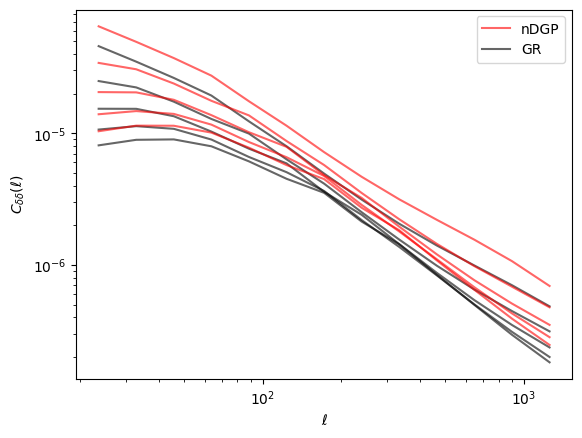

In [31]:
"""Plots: Test C_kk(ell) function"""

ell_bin_number = 13

print(D_testdata_deldel.shape)

for j in range(7):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha= 0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\delta\delta}(\ell)$')
plt.legend(["nDGP", "GR"])

plt.xscale('log')
plt.yscale('log')
plt.show()

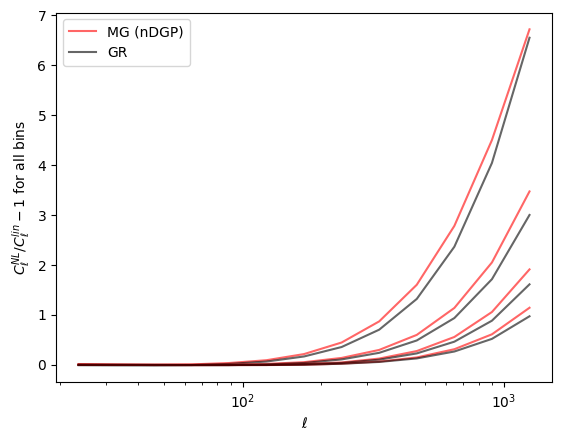

In [32]:
"""Plots: Test C_kk(ell) difference (need mock as well)"""


for j in range(int(len(D_testdata_deldel)/ell_bin_number) - 1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata_deldel[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_lin_deldel[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "r", alpha=0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata_GR_deldel[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_GR_lin_deldel[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "k", alpha=0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{NL}/ C_\ell^{lin} - 1$ for all bins')
plt.xscale('log')
plt.legend(["MG (nDGP)", "GR"])
plt.show()

<>:20: DeprecationWarning: invalid escape sequence '\k'
<>:20: DeprecationWarning: invalid escape sequence '\k'
<>:21: DeprecationWarning: invalid escape sequence '\k'
<>:21: DeprecationWarning: invalid escape sequence '\k'
<>:22: DeprecationWarning: invalid escape sequence '\d'
<>:22: DeprecationWarning: invalid escape sequence '\d'
<>:20: DeprecationWarning: invalid escape sequence '\k'
<>:20: DeprecationWarning: invalid escape sequence '\k'
<>:21: DeprecationWarning: invalid escape sequence '\k'
<>:21: DeprecationWarning: invalid escape sequence '\k'
<>:22: DeprecationWarning: invalid escape sequence '\d'
<>:22: DeprecationWarning: invalid escape sequence '\d'
/tmp/ipykernel_2580384/3176304104.py:20: DeprecationWarning: invalid escape sequence '\k'
  plt.legend(["nDGP, $\kappa\kappa$", "GR, $\kappa\kappa$",
/tmp/ipykernel_2580384/3176304104.py:20: DeprecationWarning: invalid escape sequence '\k'
  plt.legend(["nDGP, $\kappa\kappa$", "GR, $\kappa\kappa$",
/tmp/ipykernel_2580384/31763

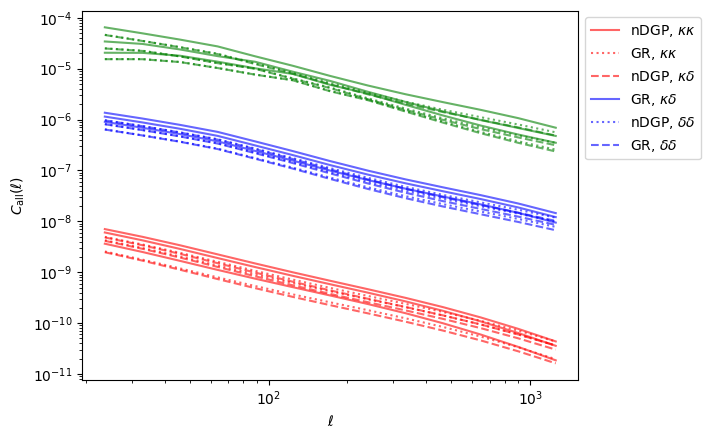

In [33]:
"""Plots: Test C_kk(ell) function"""


for j in range(3):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_kk[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number], "r:", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR_kk[j*ell_bin_number:(j+1)*ell_bin_number], "r--", alpha= 0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_delk[j*ell_bin_number:(j+1)*ell_bin_number], "b", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_delk_fR[j*ell_bin_number:(j+1)*ell_bin_number], "b:", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR_delk[j*ell_bin_number:(j+1)*ell_bin_number], "b--", alpha= 0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_deldel_fR[j*ell_bin_number:(j+1)*ell_bin_number], "g:", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR_deldel[j*ell_bin_number:(j+1)*ell_bin_number], "g--", alpha= 0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\text{all}}(\ell)$')
plt.legend(["nDGP, $\kappa\kappa$", "GR, $\kappa\kappa$",
            "nDGP, $\kappa\delta$", "GR, $\kappa\delta$",
            "nDGP, $\delta\delta$", "GR, $\delta\delta$"],bbox_to_anchor=(1.0, 1.0))
plt.xscale('log')
plt.yscale('log')
plt.show()

# 4. Get quantities to put in MCMC step

In [122]:
# Define cosmology -- our "universe cosmology"

cosmo_universe = ccl.Cosmology(Omega_c = 0.27, 
                          Omega_b = 0.046, 
                          h = 0.7, 
                          n_s = 0.974,
                          A_s = 2.01e-9)

cosmo_universe_linear = ccl.Cosmology(Omega_c = 0.27, 
                          Omega_b = 0.046, 
                          h = 0.7, 
                          n_s = 0.974,
                          A_s = 2.01e-9,
                          matter_power_spectrum='linear')


fR_universe = 1e-4
H0rc_universe = 0.0
MGParam_universe = [H0rc_universe,fR_universe,1,0,0]


## 4a. Get mock 3x2pt data

In [123]:
"""Check we match SRD"""
def bins(ell_min, ell_max, ell_bin_num):

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    return ell_binned

# ell binning for shear
print(np.loadtxt("/home/c2042999/PCA_project/ell-values").shape)
ells_SRD = np.loadtxt("/home/c2042999/PCA_project/ell-values")[:13]

print(ells_SRD)
print(bins(20, 1478.5, 13))

(20,)
[  23.5997    32.8594    45.75227   63.70386   88.69901  123.5014
  171.959    239.4297   333.3735   464.1775   646.3045   899.8917
 1252.978  ]
[  23.59970561   32.85941027   45.75230138   63.70391509   88.6991184
  123.5015712   171.95929751  239.43015228  333.37422663  464.17869231
  646.30628639  899.89442158 1252.98173181]


In [124]:

# define ell and C_ell shapes -- will depend on the data

ell_min_mockdata = 20
ell_max_mockdata = 1478.5

# define quantities for binning of ell -- will depend on the data

ell_bin_num_mockdata = 13

In [125]:
"""Get mock C(ell) data"""

## LENSING - LENSING

binned_ell = bin_ell_kk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_source)

# find C_ell for non-linear matter power spectrum
mockdata = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj(cosmo_universe, MGParam_universe, linear=False, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

ell_kk_mockdata = mockdata[0]
D_kk_mockdata = mockdata[1]
D_kk_mockdata = (np.array(D_kk_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj(cosmo_universe, MGParam_universe, linear=True, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

D_kk_data_lin_plot = data_lin_plot[1]
D_kk_data_lin_plot = (np.array(D_kk_data_lin_plot)).flatten()

## CLUSTERING - LENSING

binned_ell = bin_ell_delk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,Binned_distribution_source,Binned_distribution_lens)

# find C_ell for non-linear matter power spectrum
mockdata = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj(cosmo_universe, MGParam_universe, linear=False, gravity_model="f(R)"), tracer1_type="k", tracer2_type="g")

ell_delk_mockdata = mockdata[0]
D_delk_mockdata = mockdata[1]
D_delk_mockdata = (np.array(D_delk_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj(cosmo_universe, MGParam_universe, linear=True, gravity_model="f(R)"), tracer1_type="k", tracer2_type="g")

D_delk_data_lin_plot = data_lin_plot[1]
D_delk_data_lin_plot = (np.array(D_delk_data_lin_plot)).flatten()

## CLUSTERING - CLUSTERING
binned_ell = bin_ell_deldel(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,Binned_distribution_lens)

# find C_ell for non-linear matter power spectrum
mockdata = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj(cosmo_universe, MGParam_universe, linear=False, gravity_model="f(R)"), tracer1_type="g", tracer2_type="g")

ell_deldel_mockdata = mockdata[0]
D_deldel_mockdata = mockdata[1]
D_deldel_mockdata = (np.array(D_deldel_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj(cosmo_universe, MGParam_universe, linear=True, gravity_model="f(R)"), tracer1_type="g", tracer2_type="g")

D_deldel_data_lin_plot = data_lin_plot[1]
D_deldel_data_lin_plot = (np.array(D_deldel_data_lin_plot)).flatten()


ell_mockdata = np.append(np.append(ell_kk_mockdata, ell_delk_mockdata), ell_deldel_mockdata)
D_mockdata = np.append(np.append(D_kk_mockdata, D_delk_mockdata), D_deldel_mockdata)
D_data_lin_plot = np.append(np.append(D_kk_data_lin_plot, D_delk_data_lin_plot), D_deldel_data_lin_plot)

print(D_kk_mockdata.shape, D_delk_mockdata.shape, D_deldel_mockdata.shape)
del mockdata, data_lin_plot



(195,) (91,) (65,)


(351,)
27
13


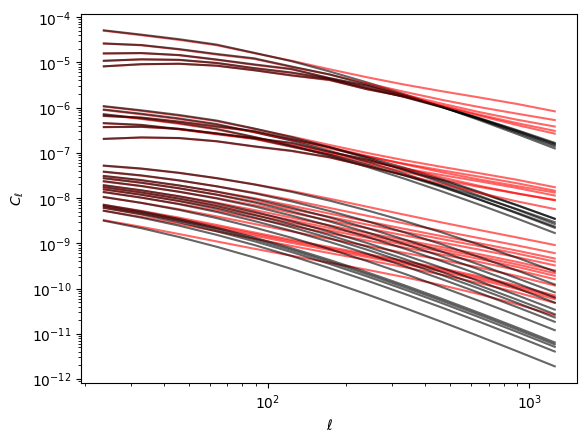

In [126]:
"""Plots: Test C(ell) function"""
print(D_mockdata.shape)
print(int(len(D_mockdata)/ell_bin_num_mockdata))
print(ell_bin_num_mockdata)

ell_bin_number = int(len(ell_mockdata)/((len(Binned_distribution_source)+1)*len(Binned_distribution_source)/2))

for j in range(int(len(D_mockdata)/ell_bin_num_mockdata)):
    plt.plot(ell_mockdata[j*ell_bin_num_mockdata:(j+1)*ell_bin_num_mockdata], D_mockdata[j*ell_bin_num_mockdata:(j+1)*ell_bin_num_mockdata], "r", alpha=0.6)
    plt.plot(ell_mockdata[j*ell_bin_num_mockdata:(j+1)*ell_bin_num_mockdata], D_data_lin_plot[j*ell_bin_num_mockdata:(j+1)*ell_bin_num_mockdata], "k", alpha=0.6)
    #plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number] - D_data_lin_plot[j*ell_bin_number:(j+1)*ell_bin_number])/D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha=0.6)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 4b. Get mock fsigma8 data

In [222]:
"""Get simulated DESI LRG data using Danielle's code"""

def f_frac_err(cosmo, MGparams,b, zeff, nbar, V):
    """ Get the fractional error on the growth rate.
    params is a dictionary of required cosmological parameters.
    zeff is the effective redshift of the sample.
    nbar is the number density of the sample in units of (h/Mpc)^3.
    V is the volume of the survey in (Mpc/h)^3. """
    
    # Set up a k and mu vector at which to do the integrals
    # (Result depends on kmax chosen, see White et al. 2008)
	
    k = np.logspace(-3, -1, 400)
    mu = np.linspace(-1, 1., 200)
        
    # Get the inverse covariance value at each k and mu
    print("Getting inverse data covariance for beta variance calculation.")
    invcov = Pobs_covinv(cosmo, MGparams,b, k, mu, zeff, nbar)
    
    # Get the derivative of the observed z-space
    # P(k) with respect to b and f at each k and mu
    # (linear theory)
    print("Getting derivative.")
    dPdf = diff_P_f(cosmo, MGparams,b, k, mu, zeff)
    
    # Do the integration in k in each case
    print("Doing k integration.")
    int_in_k_ff = [scipy.integrate.simps(k**2 * dPdf[mi] * invcov[mi] * dPdf[mi], k) for mi in range(len(mu))]
	
    # And in mu.
    print("Doing mu integration.")
    int_in_mu_ff = scipy.integrate.simps(np.asarray(int_in_k_ff), mu)
	
    Fisher_ff = np.zeros((2,2)) # order is b then f
    
    # Add necessary factors of volume (Mpc/h)^3 and pi etc
    ff= V * int_in_mu_ff / (2. * np.pi**2)
    err_f = np.sqrt(1./ff)
    
    # Now use this to construct the error on f:
    f_sigma8_val = fsigma8_fR(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    f_fid = f_sigma8_val/sigma_8_fR(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    
    frac_err_f = err_f / f_fid
    
    return frac_err_f, f_sigma8_val
    
def diff_P_f(cosmo, MGparams,b, k, mu, zeff):
    """ Calculate the derivative of the redshift space power spectrum
    wrt linear growth rate f at each k and mu
    params: dictionary of cosmological parameters
    k: list or array of wavenumbers
    mu: list of array of angles
    lens: lens sample label
    """
		
    # Get the linear power spectrum at the effective z of the lens sample
    Pklin = P_k_fR_lin(cosmo, MGparams, k,  1./ (1. + zeff))
    
    # Get the derivative at each mu / k
    f = fsigma8_fR(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]/sigma_8_fR(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    dPdf = [2. * (b + mu[mi]**2*f) * mu[mi]**2 * Pklin  for mi in range(len(mu))]
	
    return dPdf
    
def Pobs_covinv(cosmo, MGparams,b, k, mu, zeff, nbar):
    """ Get the inverse covariance of the redshift space observed power 
    spectrum at a list of k and mu (cosine of angle to line of sight) vals.
    params: dictionary of cosmological parameters
    k: list or array of wavenumbers
    mu: list of array of angles
    lens: lens sample label """	
 
	
    # Get the linear power spectrum at the effective z of the lens sample
    Pklin = P_k_fR_lin(cosmo, MGparams, k,  1./ (1. + zeff))
	
    # Get the redshift space galaxy power spectrum in linear theory
    f = fsigma8_fR(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]/sigma_8_fR(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    Pgg = [(b + f * mu[mi]**2)**2 * Pklin for mi in range(len(mu))]
	
    # Get the covariance matrix at each k and mu
    cov = [ 2. * (Pgg[mi]**2 + 2 * Pgg[mi] / nbar + 1. / nbar**2) for mi in range(len(mu))]
	
    #Pgg_arr = np.zeros((len(k), len(mu)))
    #for mi in range(len(mu)):
    #	Pgg_arr[:, mi] = Pgg[mi]
	
    # Get the inverse at each k and mu
    invcov = [[1./ cov[mi][ki] for ki in range(len(k))] for mi in range(len(mu))]
			
    return invcov

zeff= 0.72
nbar = 5*10**(-4)
Vol = 3*10**9

f_fe, f_fid = f_frac_err(cosmo_universe,MGParam_universe,2.03, zeff, nbar, Vol)

print('sigma(f) / f =',f_fe)
print('fid f sigma8=', f_fid)
print('sigma(f sigma8) =', f_fe*f_fid)

Getting inverse data covariance for beta variance calculation.
Getting derivative.
Doing k integration.
Doing mu integration.
sigma(f) / f = 0.01463021095489102
fid f sigma8= 0.6038891190507575
sigma(f sigma8) = 0.00883502520507588


In [223]:
# Using data described in Section 3.4 of https://arxiv.org/pdf/2201.07025 (Jaime's paper)
# Dataset 1 (x3): RSD BOSS DR12 data https://arxiv.org/pdf/1607.03155
# Dataset 2 (x1): BOSS DR16 quasar sample 𝑓𝜎8(𝑧eff) measurement https://arxiv.org/pdf/2007.08998
# Dataset 3 (x3): WiggleZ Dark Energy Survey data https://arxiv.org/pdf/1204.3674
# Dataset 4 (x1): 𝑓𝜎8(𝑧 = 0) from peculiar velocities of Democratic Samples of Supernovae https://arxiv.org/pdf/2105.05185

z_eff = np.array([0.38 , 0.51 , 0.61 , 1.48 , 0.44 , 0.6 , 0.73 , 0.0, zeff])

fsigma_8_realdata = np.array([0.497 , 0.458 , 0.436, 0.462 , 0.413 , 0.39 , 0.437 , 0.39])

fsigma_8_fracerror = np.array([0.045/0.497 , 0.038/0.458 , 0.034/0.436, 0.045/0.462 , \
                               0.08/0.413 , 0.063/0.39 , 0.072/0.437 , 0.022/0.39, f_fe])

reducedcov_fsigma_8 = np.array([[1 , 0.4773 , 0.1704 , 0 , 0 , 0 , 0 , 0,0],
                               [ 0.4773 , 1 , 0.5103 , 0 , 0 , 0 , 0 , 0,0],
                               [0.1704 , 0.5103 , 1 , 0 , 0 , 0 , 0 , 0,0],
                               [0 , 0 , 0 , 1 , 0 , 0 , 0 , 0,0],
                               [0 , 0 , 0 , 0 , 1 , 0.50992 , 0.0 , 0,0],
                               [0 , 0 , 0 , 0 , 0.50992 , 1 , 0.559965 , 0,0],
                               [0 , 0 , 0 , 0 , 0.0 , 0.559965 , 1 , 0,0],
                               [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1,0],
                               [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0,1]]
                       )

headers = z_eff.tolist()

## Create our data:

fsigma_8_data = fsigma8_fR(cosmo_universe, MGParam_universe, 1/(z_eff+1))

cov_fsigma8 = reducedcov_fsigma_8 * np.outer(fsigma_8_data*fsigma_8_fracerror, fsigma_8_data*fsigma_8_fracerror)
invcov_fsigma8 = np.linalg.inv(cov_fsigma8)

       0.38         0.51         0.61      1.48     0.44       0.6      0.73       0.0
-----------  -----------  -----------  --------  -------  --------  --------  --------
0.002025     0.000816183  0.000260712  0         0        0         0         0
0.000816183  0.001444     0.000659308  0         0        0         0         0
0.000260712  0.000659308  0.001156     0         0        0         0         0
0            0            0            0.002025  0        0         0         0
0            0            0            0         0.0064   0.00257   0         0
0            0            0            0         0.00257  0.003969  0.00254   0
0            0            0            0         0        0.00254   0.005184  0
0            0            0            0         0        0         0         0.000484


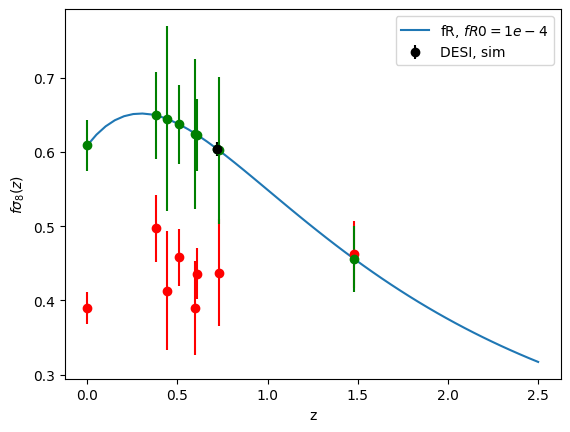

In [224]:
""" Plots: Test our fsigma8 data """

# TEST by comparing with tables in papers
print(tabulate(reducedcov_fsigma_8[:-1,:-1] * np.outer(fsigma_8_realdata*fsigma_8_fracerror[:-1], fsigma_8_realdata*fsigma_8_fracerror[:-1]), headers))

plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_fR(cosmo_universe, MGParam_universe, 1/(np.linspace(0.0, 2.5, 50)+1)), label=r"fR, $fR0 = 1e-4$")
plt.errorbar(z_eff[:-1], fsigma_8_realdata, yerr=fsigma_8_realdata*fsigma_8_fracerror[:-1], fmt="o", color="r")
plt.errorbar(z_eff, fsigma_8_data, yerr=fsigma_8_data*fsigma_8_fracerror, fmt="o", color="g")
plt.errorbar(z_eff[-1], fsigma_8_data[-1], yerr=fsigma_8_data[-1]*fsigma_8_fracerror[-1], fmt="o", color="k", label = "DESI, sim")

plt.xlabel("z")
plt.ylabel(r"$f \sigma_8(z)$")
plt.legend()
#plt.savefig("/home/c2042999/PCA_project/fsigma8_data.pdf", bbox_inches='tight')

## 4c. Get covariance matrix

Note that for Y1 SRD gives area = 12.3 k deg^2 (total area on sphere = 41.253 k deg^2), so f_sky = 0.298.

Also, they define the number density following empirical results from the HSC survey (Appendix F1), finding a value of 18 arcmin^{−2} for Y1 lens sample.

Also, For Y1, the per-bin bias values that were actually used were [1.562362, 1.732963, 1.913252, 2.100644, 2.293210] (D1.1).

Also, for Y1, neff = 9.52 over the 5 bins (from plot Fig F4) (or 10 from D2.1), so 1.904 per bin

In [42]:
def cov2corr(cov):
    """
    Convert a covariance matrix into a correlation matrix
    input:
        cov: numpy.array with dim:(N,N)
    returns:
        corr: numpy.array with dim:(N,N)
    """
    sig = np.sqrt(cov.diagonal())
    return cov/np.outer(sig, sig)

### TJPCov matrix - at the moment doesn't work well, use SRD

In [161]:
"""Define sacc file - Cl^{ij}(ell) for some ell bins and redshift bins"""
# My redshifts (for now)
src0 = Binned_distribution_source[0]
src1 = Binned_distribution_source[1]
src2 = Binned_distribution_source[2]
src3 = Binned_distribution_source[3]
src4 = Binned_distribution_source[4]
z_src = z

lens0 = Binned_distribution_lens[0]
lens1 = Binned_distribution_lens[1]
lens2 = Binned_distribution_lens[2]
lens3 = Binned_distribution_lens[3]
lens4 = Binned_distribution_lens[4]
z_lens = z

#ell_bins = ell_mockdata[:ell_bin_num_mockdata]
ell_bins = ell_mockdata[:ell_bin_num_mockdata]

# z binning 

src_bins = [src0, src1, src2, src3, src4]
lens_bins = [lens0, lens1, lens2, lens3, lens4]

s = sacc.Sacc()


for i, bin1 in enumerate(src_bins):
    s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)
    for j, bin2 in enumerate(src_bins):
        if j >= i:
            print(i,j)
            # construct Cl_gM for sacc file
            shearA = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin1), has_shear=True)
            shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)
    
            Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins) 
            # bin ell
    
            s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
                                'src%d'%j, ell_bins, Cl, tracers_later=True)

for i, bin1 in enumerate(lens_bins):
    print(i)
    s.add_tracer('NZ', 'lens%d'%i, z=z_lens, nz=bin1)
    # construct Cl_gM for sacc file
    shearA = ccl.NumberCountsTracer(cosmo_universe, dndz=(z_lens, bin1), bias=(z_lens, 0.95*np.ones(len(z_lens))), has_rsd=False)
    # bias=(z_lens, Bias_distribution[i])
    Cl = ccl.angular_cl(cosmo_universe, shearA, shearA, ell_bins) 
    # bin ell

    s.add_ell_cl('galaxy_density_cl', 'lens%d'%i, 
                            'lens%d'%i, ell_bins, Cl, tracers_later=True)
    


for i, bin1 in enumerate(lens_bins):
    for j, bin2 in enumerate(src_bins):
        s.add_tracer('NZ', 'src%d'%j, z=z_src, nz=bin2)
        if j - 1 > i or (j == 4 and i == 3):
            print(i,j)
            s.add_tracer('NZ', 'lens%d'%i, z=z_lens, nz=bin1)
            # construct Cl_gM for sacc file
            shearA = ccl.NumberCountsTracer(cosmo_universe, dndz=(z_lens, bin1), bias=(z_lens, Bias_distribution_fiducial[i]), has_rsd=False)
            shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)
        
            Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins) 
            # bin ell
        
            s.add_ell_cl('galaxy_shearDensity_cl_e', 'lens%d'%i, 
                                'src%d'%j, ell_bins, Cl, tracers_later=True)


s.save_fits('/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits', overwrite=True)

0 0
0 1
0 2
0 3
0 4
1 1
1 2
1 3
1 4
2 2
2 3
2 4
3 3
3 4
4 4
0
1
2
3
4
0 2
0 3
0 4
1 3
1 4
2 4
3 4


In [162]:
s = sacc.Sacc.load_fits("/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits")

In [163]:
dts = s.get_data_types()
print("data types ", dts)
print("tracer_sets shape-shape" , s.get_tracer_combinations('galaxy_shear_cl_ee'))
print("tracer_sets shape-pos" , s.get_tracer_combinations('galaxy_shearDensity_cl_e'))
print("tracer_sets pos-pos" , s.get_tracer_combinations('galaxy_density_cl'))

#print((s.get_ell_cl('galaxy_density_cl','lens0','lens0')))

data types  ['galaxy_density_cl', 'galaxy_shearDensity_cl_e', 'galaxy_shear_cl_ee']
tracer_sets shape-shape [('src0', 'src0'), ('src0', 'src1'), ('src0', 'src2'), ('src0', 'src3'), ('src0', 'src4'), ('src1', 'src1'), ('src1', 'src2'), ('src1', 'src3'), ('src1', 'src4'), ('src2', 'src2'), ('src2', 'src3'), ('src2', 'src4'), ('src3', 'src3'), ('src3', 'src4'), ('src4', 'src4')]
tracer_sets shape-pos [('lens0', 'src2'), ('lens0', 'src3'), ('lens0', 'src4'), ('lens1', 'src3'), ('lens1', 'src4'), ('lens2', 'src4'), ('lens3', 'src4')]
tracer_sets pos-pos [('lens0', 'lens0'), ('lens1', 'lens1'), ('lens2', 'lens2'), ('lens3', 'lens3'), ('lens4', 'lens4')]


In [164]:
config = '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

gauss_calc.config


{'tjpcov': {'sacc_file': '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits',
  'cosmo': '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cosmo_MCMC.yaml',
  'cov_type': ['FourierGaussianFsky'],
  'Ngal_lens0': 2.25,
  'Ngal_lens1': 3.11,
  'Ngal_lens2': 3.09,
  'Ngal_lens3': 2.61,
  'Ngal_lens4': 2.0,
  'Ngal_src0': 1.78,
  'Ngal_src1': 1.78,
  'Ngal_src2': 1.78,
  'Ngal_src3': 1.78,
  'Ngal_src4': 1.78,
  'sigma_e_src0': 0.26,
  'sigma_e_src1': 0.26,
  'sigma_e_src2': 0.26,
  'sigma_e_src3': 0.26,
  'sigma_e_src4': 0.26,
  'bias_lens0': 1.229,
  'bias_lens1': 1.362,
  'bias_lens2': 1.502,
  'bias_lens3': 1.648,
  'bias_lens4': 1.799,
  'IA': 0.8},
 'GaussianFsky': {'fsky': 0.2982}}

In [165]:
# get matrix
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
('lens0', 'lens0') ('lens0', 'lens0')


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/home/c2042999/TJPCov/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


('lens0', 'lens0') ('lens1', 'lens1')
('lens0', 'lens0') ('lens2', 'lens2')
('lens0', 'lens0') ('lens3', 'lens3')
('lens0', 'lens0') ('lens4', 'lens4')
('lens0', 'lens0') ('lens0', 'src2')
('lens0', 'lens0') ('lens0', 'src3')
('lens0', 'lens0') ('lens0', 'src4')
('lens0', 'lens0') ('lens1', 'src3')
('lens0', 'lens0') ('lens1', 'src4')
('lens0', 'lens0') ('lens2', 'src4')
('lens0', 'lens0') ('lens3', 'src4')
('lens0', 'lens0') ('src0', 'src0')
('lens0', 'lens0') ('src0', 'src1')
('lens0', 'lens0') ('src0', 'src2')
('lens0', 'lens0') ('src0', 'src3')
('lens0', 'lens0') ('src0', 'src4')
('lens0', 'lens0') ('src1', 'src1')
('lens0', 'lens0') ('src1', 'src2')
('lens0', 'lens0') ('src1', 'src3')
('lens0', 'lens0') ('src1', 'src4')
('lens0', 'lens0') ('src2', 'src2')
('lens0', 'lens0') ('src2', 'src3')
('lens0', 'lens0') ('src2', 'src4')
('lens0', 'lens0') ('src3', 'src3')
('lens0', 'lens0') ('src3', 'src4')
('lens0', 'lens0') ('src4', 'src4')
('lens1', 'lens1') ('lens1', 'lens1')
('lens1', '

(351, 351)


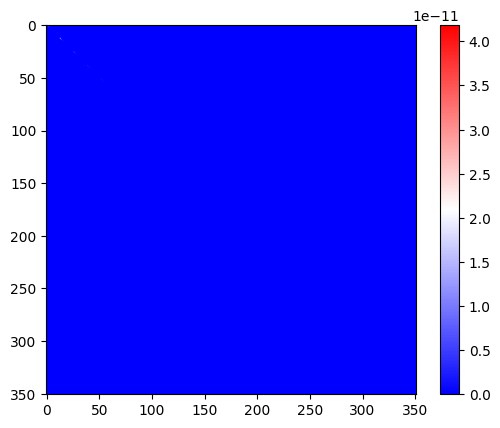

In [166]:
print(gauss_cov.shape)
plt.imshow(gauss_cov, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

(351, 351)


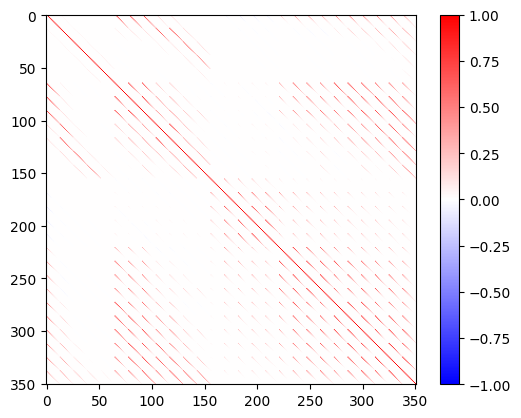

In [167]:
corr = cov2corr(gauss_cov)
print(corr.shape)
plt.imshow(corr, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()

#plt.savefig("/home/c2042999/PCA_project/TJPCov_corr_matrix.pdf")
plt.show()

In [168]:
gauss_cov_rotated = np.zeros((351,351))
gauss_cov_rotated[286:,286:] = gauss_cov[:65,:65]
gauss_cov_rotated[195:286,195:286] = gauss_cov[65:156,65:156]
gauss_cov_rotated[:195,:195] = gauss_cov[156:,156:]

gauss_cov_rotated[195:286,286:] = gauss_cov[65:156,:65]
gauss_cov_rotated[286:,195:286] = gauss_cov[:65,65:156]

gauss_cov_rotated[:195,286:] = gauss_cov[156:,:65]
gauss_cov_rotated[286:,:195] = gauss_cov[:65,156:]

gauss_cov_rotated[:195,195:286] = gauss_cov[156:,65:156]
gauss_cov_rotated[195:286,:195] = gauss_cov[65:156,156:]


195 91 65


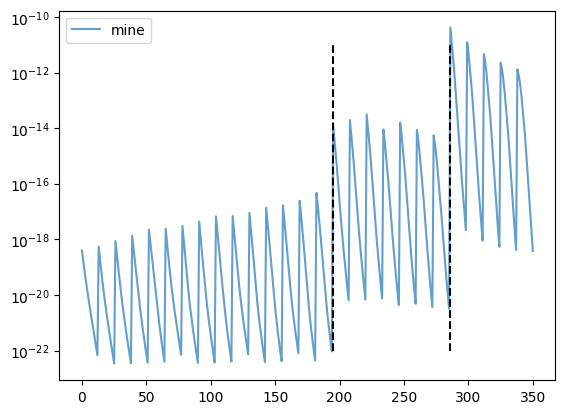

In [169]:
plt.plot(np.diag(gauss_cov_rotated), alpha = 0.7, label ="mine")
plt.yscale("log")
print(len(D_kk_mockdata),len(D_delk_mockdata),len(D_deldel_mockdata))
plt.plot([len(D_kk_mockdata),len(D_kk_mockdata)],[1e-22,1e-11],"k--")
plt.plot([len(D_kk_mockdata)+ len(D_delk_mockdata),len(D_kk_mockdata) + len(D_delk_mockdata)],[1e-22,1e-11],"k--")

plt.legend()

#### Old Tests

In [72]:
"""Get SRD covariance matrix to compare"""

# covariance for shear bin combinations, in order: z11, z12, z13,..., z15, z22, z23,...z55
shear_cl_SRD_old = np.loadtxt("/home/c2042999/PCA_project/Y1_3x2pt.mat")
shear_cl_SRD_old_new = np.loadtxt("/home/c2042999/PCA_project/cov_3x2pt_Y1_May2022 2.txt")

print(shear_cl_SRD_old.shape)

covfile = np.genfromtxt("/home/c2042999/PCA_project/Y1_3x2pt_inv")

shear_cl_SRD_old_test = np.zeros((540,540))
for i in range(0,covfile.shape[0]):
    shear_cl_SRD_old_test[int(covfile[i,0]),int(covfile[i,1])] = covfile[i,2]#+covfile[i,9] # non-gauss
    shear_cl_SRD_old_test[int(covfile[i,1]),int(covfile[i,0])] = covfile[i,2]#+covfile[i,9] # non-gauss
    
#shear_cl_SRD = np.loadtxt("/home/c2042999/PCA_project/Y1_3x2pt_clusterN_clusterWL_cov")

"""
for j in 15,
for i in 20,
if i > 13, remove j*20 + i th element

15 = int(len(D_mockdata)/ell_bin_number)
20 = len(shear_cl_SRD_old)/15
13 = ell_bin_number
"""

idx = 0

"""
for j in range(int(len(D_mockdata)/ell_bin_number)):
    for i in range(int(len(shear_cl_SRD_old)/(len(D_mockdata)/ell_bin_number))):
        if i >= 13:
            bins_SRD = int(len(shear_cl_SRD_old)/(len(D_mockdata)/ell_bin_number))
            shear_cl_SRD = np.delete(shear_cl_SRD, j*bins_SRD + i - idx, 0)
            shear_cl_SRD = np.delete(shear_cl_SRD, j*bins_SRD + i - idx, 1)

            idx += 1
"""

covfile = np.genfromtxt("/home/c2042999/PCA_project/Y1_3x2pt_clusterN_clusterWL_cov")
print(covfile.shape)

shear_SRD = np.zeros((705,705))
ell_test_SRD = np.zeros(705)


for i in range(0,covfile.shape[0]):
    shear_SRD[int(covfile[i,0]),int(covfile[i,1])] = covfile[i,8]#+covfile[i,9] # non-gauss
    shear_SRD[int(covfile[i,1]),int(covfile[i,0])] = covfile[i,8]#+covfile[i,9] # non-gauss
    if int(covfile[i,0]) == int(covfile[i,1]):
        ell_test_SRD[int(covfile[i,0])] = covfile[i,2]

"""
	cov = np.zeros((ndata,ndata))

	print ndata,n2pt,int(np.max(covfile[:,0])+1)

	for i in range(0,covfile.shape[0]):
	  	cov[int(covfile[i,0]),int(covfile[i,1])] = covfile[i,8]+covfile[i,9]
	  	cov[int(covfile[i,1]),int(covfile[i,0])] = covfile[i,8]+covfile[i,9]
"""

del covfile
print(shear_SRD.shape)


(540, 540)
(265275, 10)
(705, 705)


In [110]:
"""print(ell_bins)
print(ell_test_SRD[:len(ell_bins)])
print(ell_test_SRD[540:])
"""

'print(ell_bins)\nprint(ell_test_SRD[:len(ell_bins)])\nprint(ell_test_SRD[540:])\n'

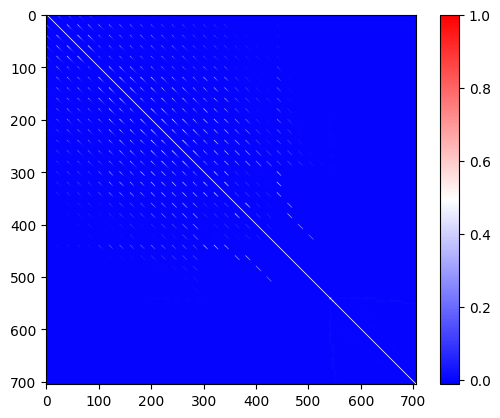

In [48]:
plt.imshow(cov2corr(shear_SRD), origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

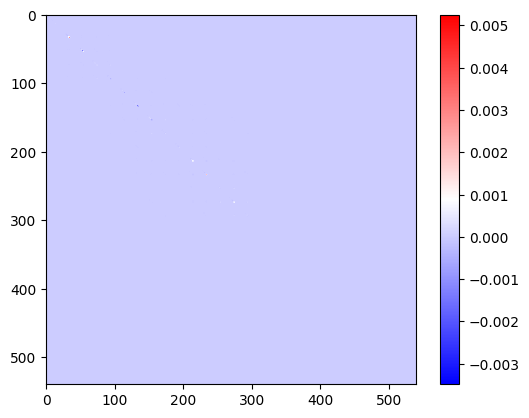

In [112]:
plt.imshow((shear_cl_SRD_old_test-shear_cl_SRD_old)/np.average(shear_cl_SRD_old_test), origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

/tmp/ipykernel_756283/3468767144.py:10: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


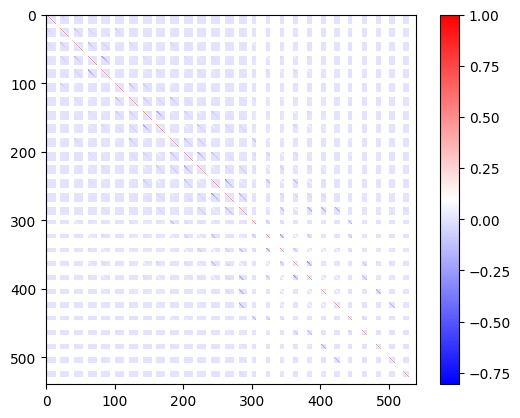

In [113]:
plt.imshow(cov2corr(shear_cl_SRD_old_test), origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

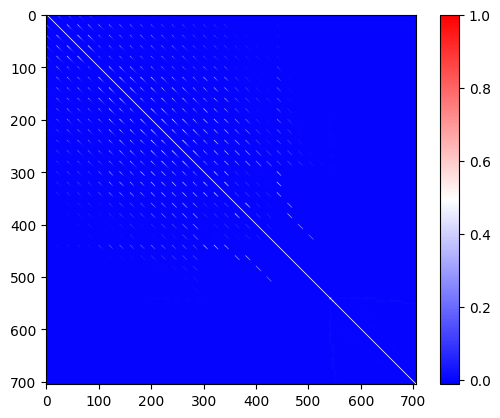

In [114]:
plt.imshow(cov2corr(shear_SRD), origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

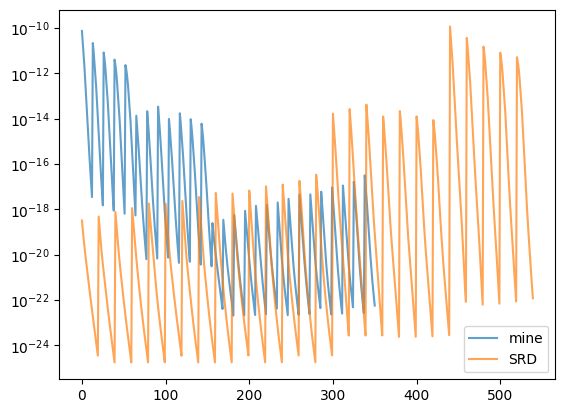

In [70]:
plt.plot(np.diag(gauss_cov), alpha = 0.7, label ="mine")
plt.plot(np.diag(shear_cl_SRD_old_new), alpha = 0.7, label ="SRD")
plt.yscale("log")
plt.legend()

In [64]:
print(shear_SRD.shape)
#shear_cl_SRD_nozero = shear_cl_SRD[shear_cl_SRD != 0].reshape(335,335)
#processed_array = np.sign((shear_cl_SRD_nozero))*np.log10(np.abs((shear_cl_SRD_nozero)))

SRD_compare = np.zeros((540,540))
SRD_compare[:100,:100] = shear_SRD[440:540,440:540]
SRD_compare[100:240,100:240] = shear_SRD[300:440,300:440]
SRD_compare[240:,240:] = shear_SRD[:300,:300]

SRD_compare[:100,100:240] = shear_SRD[440:540,100:240]
SRD_compare[100:240,:100] = shear_SRD[100:240,440:540]

SRD_compare[:100,240:] = shear_SRD[440:540,:300]
SRD_compare[240:,:100] = shear_SRD[:300,440:540]

SRD_compare[240:,100:240] = shear_SRD[:300,300:440]
SRD_compare[100:240,240:] = shear_SRD[300:440,:300]


"""
SRD_compare = np.zeros((540,540))
SRD_compare[:100,:100] = shear_SRD[:100,:100]
SRD_compare[100:240,100:240] = shear_SRD[400:540,400:540]
SRD_compare[240:,240:] = shear_SRD[100:400,100:400]

SRD_compare[:100,100:240] = shear_SRD[:100,400:540]
SRD_compare[100:240,:100] = shear_SRD[400:540,:100]

SRD_compare[:100,240:] = shear_SRD[:100,100:400]
SRD_compare[240:,:100] = shear_SRD[100:400,:100]

SRD_compare[100:240,240:] = shear_SRD[400:540,100:400]
SRD_compare[240:,100:240] = shear_SRD[100:400,400:540]
"""
idx = 0

bins_SRD = int(len(SRD_compare)/(len(D_mockdata)/ell_bin_num_mockdata))
print(int(len(D_mockdata)/ell_bin_num_mockdata))
print(bins_SRD)
print(ell_bin_num_mockdata)

for j in range(int(len(D_mockdata)/ell_bin_num_mockdata)):
    for i in range(bins_SRD):
        if i >= ell_bin_num_mockdata:
            #print(int(len(SRD_compare)/(len(D_mockdata)/ell_bin_num_mockdata)))
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 0)
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 1)
            idx += 1

#SRD_compare = shear_SRD[:540,:540] #np.flip(np.flip(shear_SRD[:540,:540],0),1)
"""
plt.imshow(SRD_compare, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()
"""

(705, 705)
27
20
13


"\nplt.imshow(SRD_compare, origin='upper',  cmap='bwr')\nplt.colorbar()\nplt.show()\n"

(705, 705)


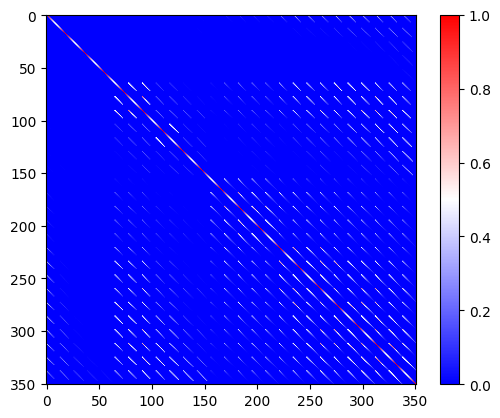

In [65]:
print(shear_SRD.shape)
plt.imshow(cov2corr(SRD_compare) , origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

In [66]:
print(shear_SRD.shape)
#plt.imshow(cov2corr(SRD_compare) - corr , origin='upper',  cmap='bwr')
#plt.colorbar()
#plt.show()

(705, 705)


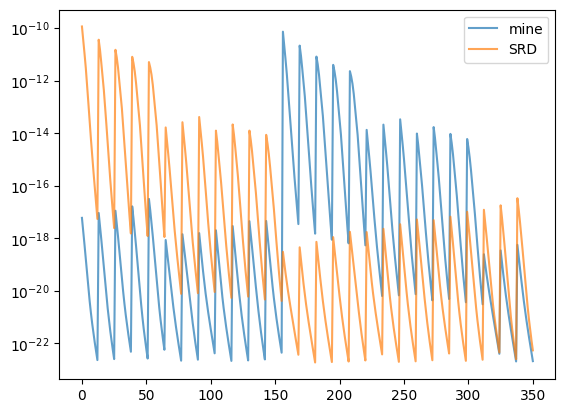

In [73]:
plt.plot(np.diag(gauss_cov_rotated), alpha = 0.7, label ="mine")
plt.plot(np.diag(SRD_compare), alpha = 0.7, label ="SRD")
plt.yscale("log")
plt.legend()

### SRD comparison:

In [43]:
"""Get SRD covariance matrix to compare"""

# covariance for shear bin combinations, in order: z11, z12, z13,..., z15, z22, z23,...z55

########## Get full covariance (gauss only) ##########

covfile = np.genfromtxt("/home/c2042999/PCA_project/Y1_3x2pt_clusterN_clusterWL_cov")
print(covfile.shape)

shear_SRD = np.zeros((705,705))
ell_test_SRD = np.zeros(705)

for i in range(0,covfile.shape[0]):
    shear_SRD[int(covfile[i,0]),int(covfile[i,1])] = covfile[i,8]+covfile[i,9] # non-gauss
    shear_SRD[int(covfile[i,1]),int(covfile[i,0])] = covfile[i,8]+covfile[i,9] # non-gauss
    if int(covfile[i,0]) == int(covfile[i,1]):
        ell_test_SRD[int(covfile[i,0])] = covfile[i,2]

del covfile
print(shear_SRD.shape)

########## Remodel the covariace to match our 3x2pt order ########## 
"""
SRD_compare = np.zeros((540,540))

SRD_compare[:100,:100] = shear_SRD[440:540,440:540]
SRD_compare[100:240,100:240] = shear_SRD[300:440,300:440]
SRD_compare[240:,240:] = shear_SRD[:300,:300]

SRD_compare[:100,100:240] = shear_SRD[440:540,100:240]
SRD_compare[100:240,:100] = shear_SRD[100:240,440:540]

SRD_compare[:100,240:] = shear_SRD[440:540,:300]
SRD_compare[240:,:100] = shear_SRD[:300,440:540]

SRD_compare[240:,100:240] = shear_SRD[:300,300:440]
SRD_compare[100:240,240:] = shear_SRD[300:440,:300]
"""
SRD_compare = shear_SRD[:540,:540].copy()
print(SRD_compare.shape)
########## Cut ell bins ##########
"""
for j in 15+7+5 = 27,
for i in 20,
if i > 13, remove j*20 + i th element

15 = int(len(D_mockdata)/ell_bin_num_mockdata)
27 = len(SRD_compare)/15
13 = ell_bin_num_mockdata
"""

idx = 0

bins_SRD = int(len(SRD_compare)/(len(D_mockdata)/ell_bin_num_mockdata))
print(int(len(D_mockdata)/ell_bin_num_mockdata))
print(bins_SRD)
print(ell_bin_num_mockdata)

for j in range(int(len(D_mockdata)/ell_bin_num_mockdata)):
    for i in range(bins_SRD):
        if i >= ell_bin_num_mockdata:
            #print(int(len(SRD_compare)/(len(D_mockdata)/ell_bin_num_mockdata)))
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 0)
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 1)
            idx += 1

print(SRD_compare.shape)


(265275, 10)
(705, 705)
(540, 540)
27
20
13
(351, 351)


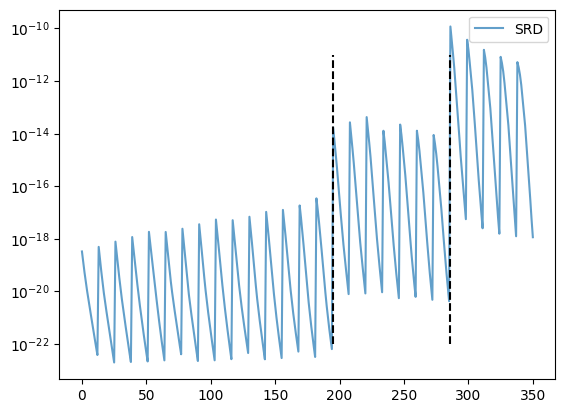

In [44]:
plt.plot(np.diag(SRD_compare), alpha = 0.7, label ="SRD")
#plt.plot(np.diag(gauss_cov_rotated), alpha = 0.7, label ="mine")
plt.plot([195,195],[1e-22,1e-11],"k--")
plt.plot([286,286],[1e-22,1e-11],"k--")
plt.yscale("log")
plt.legend()

(351, 351)


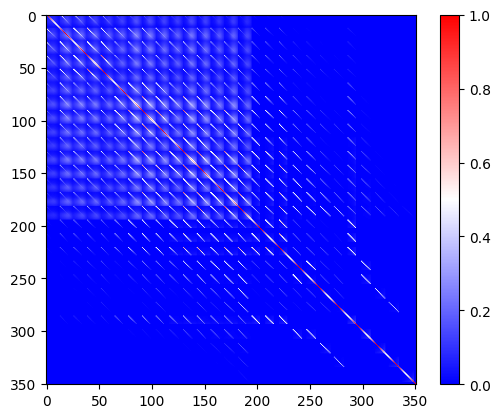

In [45]:
corr2 = cov2corr(SRD_compare)
print(corr2.shape)
plt.imshow(corr2, origin='upper', cmap='bwr')

plt.colorbar()
plt.show()
# kk, delk, deldel

### Cholensky, uncut

/tmp/ipykernel_2580384/4183053853.py:3: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  L_choleski_uncut = np.linalg.cholesky(np.matrix(SRD_compare))


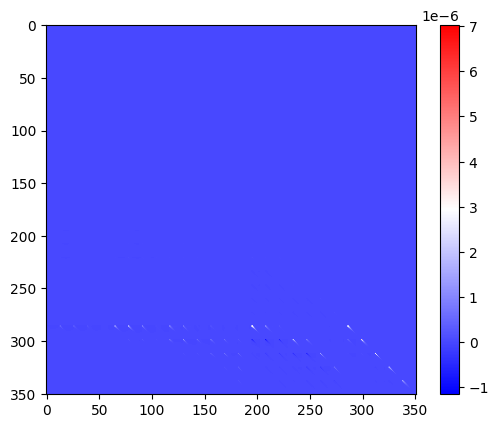

In [46]:
"""Get cholensky decomposition"""

L_choleski_uncut = np.linalg.cholesky(np.matrix(SRD_compare))
L_choleski_inv_uncut = np.linalg.inv(L_choleski_uncut)
plt.imshow(L_choleski_uncut, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

(351, 351)


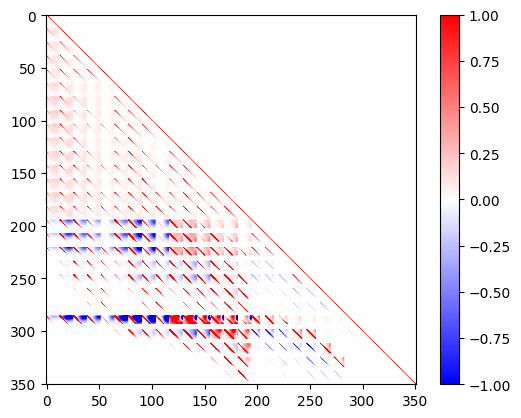

In [47]:
corr_ch = cov2corr(L_choleski_uncut)
print(corr_ch.shape)
plt.imshow(corr_ch, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
#plt.savefig("/home/c2042999/PCA_project/TJPCov_ch_corr_matrix.pdf")

plt.show()

## 4d. Apply scale cuts

In [48]:
"""Get list of lists rather than 1d array for non-uniform ell spacing"""

def ell_arrayfromlist(list):
    list_new = [[]]
    idx = 0
    for i in range(len(list)):
        if list[(i+1) % (len(list))] <= list[i]:
            list_new[idx].append(list[i])
            idx += 1
            list_new.append([])
        else:
            list_new[idx].append(list[i])
    del list_new[-1]
    return list_new



### Get data for linear scale cuts

In [49]:
def linear_scale_cuts_v2(dvec_nl, dvec_lin, cov):
    """ 
    Function from Danielle.
    Gets the scales (and vector indices) which are excluded if we
    are only keeping linear scales. We define linear scales such that 
    chi^2_{nl - lin) <=1.
	
    This is a version that is hopefully more reliable when data are highly correlated.
	
    dvec_nl: data vector from nonlinear theory 
    dvec_lin: data vector from linear theory
    cov: data covariance. """
	
    # Make a copy of these initial input things before they are changed,
    # so we can compare and get the indices
    dvec_nl_in = dvec_nl; dvec_lin_in = dvec_lin; cov_in = cov;
	
    # Check that data vector and covariance matrices have consistent dimensions.
    if ( (len(dvec_nl)!=len(dvec_lin)) or (len(dvec_nl)!=len(cov[:,0])) or (len(dvec_nl)!=len(cov[0,:])) ):
        raise(ValueError, "in linear_scale_cuts: inconsistent shapes of data vectors and / or covariance matrix.")
		
    while(True):
		
        # Get an array of all the individual elements which would go into 
        # getting chi2
        #sum_terms = np.zeros((len(dvec_nl), len(dvec_nl)))
        #for i in range(0,len(dvec_nl)):
        #    for j in range(0,len(dvec_nl)):
        #        sum_terms[i,j] = (dvec_nl[i] - dvec_lin[i]) * inv_cov[i,j] * (dvec_nl[j] - dvec_lin[j])
				
        #print("sum_terms=", sum_terms)
        #print("chi2=", np.sum(sum_terms))
        # Check if chi2<=1		
        
        # Get the chi2 in the case where you cut each data point
        # and then actually cut the one that reduces the chi2
        # the most
        chi2_temp = np.zeros(len(dvec_nl))
        for i in range(len(dvec_nl)):
            delta_dvec = np.delete(dvec_nl, i) - np.delete(dvec_lin, i)
            cov_cut = np.delete(np.delete(cov,i, axis=0), i, axis=1)
            inv_cov_cut = np.linalg.pinv(cov_cut)
            chi2_temp[i] = np.dot(delta_dvec, np.dot(inv_cov_cut, delta_dvec))
            #sum_temp[i] = np.sum(np.delete(np.delete(sum_terms, i, axis=0), i, axis=1))
        print('chi2_temp=', chi2_temp)
            
        #Find the index of data point that is cut to produce the smallest chi2:
        ind_min = np.argmin(chi2_temp)
        print('ind_min=', ind_min)
            
        # Cut that element
        dvec_nl = np.delete(dvec_nl, ind_min)
        dvec_lin = np.delete(dvec_lin, ind_min)
        cov = np.delete( np.delete(cov, ind_min, axis=0), ind_min, axis=1)
            
        if (chi2_temp[ind_min]<=1.0):
            break
				
    # Now we should have the final data vector with the appropriate elements cut.
    # Use this to get the rp indices and scales we should cut.

    ex_inds = [i for i in range(len(dvec_nl_in)) if dvec_nl_in[i] not in dvec_nl]
    print('ex_inds=', ex_inds)
	
    return ex_inds

In [50]:
"""Get new Mock data with cuts in ell"""

newdat_test = linear_scale_cuts_v2(D_mockdata, D_data_lin_plot, SRD_compare)

chi2_temp= [507284.29461745 507284.15679152 507284.25168988 507284.48870206
 507284.4942398  507283.90475981 507283.21847315 507283.25295127
 507283.83662989 507284.20645456 507284.29221243 507284.2386951
 507284.15092524 507283.71259303 507282.96637867 507282.36865444
 507282.5251715  507283.58687575 507284.46910069 507284.48850395
 507284.38070864 507284.54231419 507284.55140462 507284.55785646
 507284.30122874 507283.35675329 507284.43069157 507284.47974234
 507284.54193249 507284.55337107 507284.52836543 507284.55862977
 507284.45137863 507284.34949266 507284.52495574 507284.5527201
 507284.5579645  507284.23260761 507282.85223185 507284.31515688
 507284.20679235 507284.13979642 507284.22928084 507284.36437644
 507284.43341031 507284.385383   507284.38607565 507284.55071999
 507284.43460514 507284.44627431 507284.51144242 507283.30584991
 507284.54052534 507284.49356738 507284.36391324 507284.18679968
 507284.13111549 507284.23399774 507284.32743506 507284.37292521
 507284.55743826

In [51]:
print(len(newdat_test))

265


In [52]:
gauss_invcov_cut = np.linalg.pinv(SRD_compare.copy())
D_mockdata_cut = D_mockdata.copy()

for i in range(len(newdat_test)):
    gauss_invcov_cut[newdat_test[i]] = np.zeros(len(gauss_invcov_cut[0]))
    gauss_invcov_cut[:,newdat_test[i]] = np.zeros(len(gauss_invcov_cut[0]))
    D_mockdata_cut[newdat_test[i]] = 0


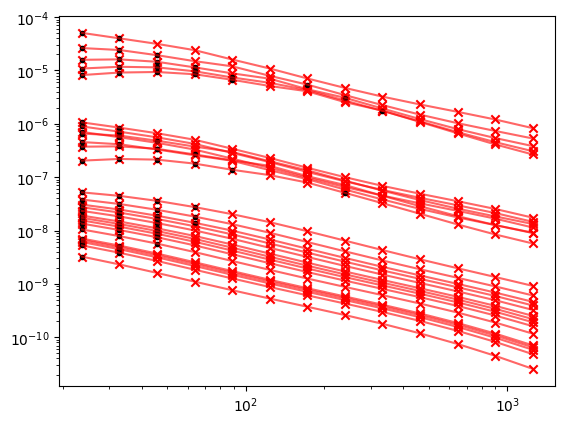

In [53]:
plt.scatter(ell_mockdata,D_mockdata, color="r", marker='x')

ell_bin_number = int(len(ell_mockdata)/((len(Binned_distribution_source)+1)*len(Binned_distribution_source)/2))

for j in range(int(len(D_mockdata)/ell_bin_num_mockdata)):
    plt.plot(ell_mockdata[j*ell_bin_num_mockdata:(j+1)*ell_bin_num_mockdata], D_mockdata[j*ell_bin_num_mockdata:(j+1)*ell_bin_num_mockdata], "r", alpha=0.6)
    #plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number] - D_data_lin_plot[j*ell_bin_number:(j+1)*ell_bin_number])/D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha=0.6)

for i in range(351):
    if D_mockdata_cut[i] !=0:
        plt.scatter(ell_mockdata[i],D_mockdata_cut[i], color="k", marker='.')

plt.xscale("log")
plt.yscale("log")

In [54]:
print(np.matmul(np.matmul(D_mockdata, gauss_invcov_cut), D_mockdata))

print(gauss_invcov_cut.shape)



19827.055944168944
(351, 351)


(351, 351)


/tmp/ipykernel_2580384/3468767144.py:10: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


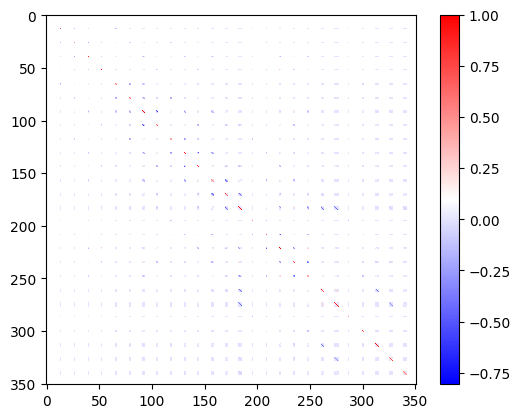

In [55]:
print(gauss_invcov_cut.shape)
plt.imshow(cov2corr(gauss_invcov_cut), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()

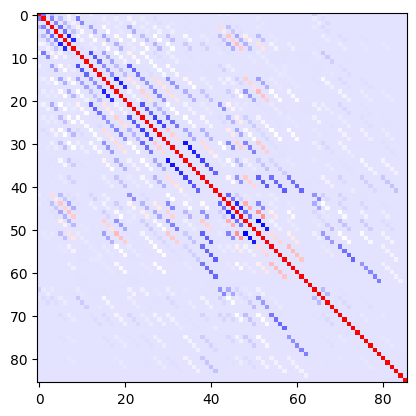

In [56]:
"""Compare with v4 plot"""
cut_1 = gauss_invcov_cut[~np.all(gauss_invcov_cut == 0, axis=1)]
plt.imshow(cov2corr(cut_1[:,~np.all(cut_1 == 0, axis=0)]), origin='upper',  cmap='bwr')

#plt.colorbar()
#plt.show()

### Get data for baryonic (nonlinear) scale cuts

In [57]:
def baryonic_scale_cuts_v2(ell, dvec_full, dvec_shear, dvec_kmax, cov_full):
    """ 
    Modified function from Danielle.
    Gets the scales (and vector indices) which are excluded if we
    are only keeping non-baryonic scales. We define these scales such that 
    chi^2_{baryonic - DMO) <=1.
    dvec_full: full data vector from baryonic theory 
    dvec_shear: shear data vector from baryonic theory 
    dvec_kmax: shear data vector from DMO theory
    cov_full: full data covariance, shear components come first
    derived    cov: shear data covariance. """
    
    # Make a copy of these initial input things before they are changed,
    # so we can compare and get the indices
    dvec_full_in = dvec_full; dvec_shear_in = dvec_shear; dvec_kmax_in = dvec_kmax; cov_in = cov_full;
	
	#### first cuts - clustering ######
    
    # for galaxy-galaxy lensing (size=91) bins=(02 , 03 , 04 , 13 , 14 , 24 , 34)
    # for galaxy-galaxy (size=65) bins=(00 , 11 , 22 , 33 , 44)
    
    k_max = 0.3 # h/Mpc
    delk_z_array = np.array([0.30,0.30,0.30,0.50,0.50,0.70,0.70])
    deldel_z_array = np.array([0.30,0.50,0.70,0.90,1.10])
    z_array = np.append(delk_z_array, deldel_z_array)
    chi = ccl.background.comoving_radial_distance(cosmo_universe, 1/(z_array+1))
    ellmax = k_max * chi - 0.5
    
    starting_index = len(dvec_shear)
    len_ell_ranges = int((len(cov_full[0]) - len(dvec_shear))/len(z_array))
    idx_count = 0
    for j in range(len(z_array)):
        for i in range(len_ell_ranges):
            if ell[starting_index + i] >= ellmax[j]:
                cov_full = np.delete(np.delete(cov_full, starting_index + j*len_ell_ranges + i - idx_count, axis=0), starting_index + j*len_ell_ranges + i - idx_count, axis=1)
                dvec_full = np.delete(dvec_full, starting_index + j*len_ell_ranges + i - idx_count)
                idx_count +=1
    
    #### second cuts - lensing ######
    cov = cov_full[:len(dvec_shear), :len(dvec_shear)]
    
    while(True):
		
        # Get an array of all the individual elements which would go into 
        # getting chi2
        #sum_terms = np.zeros((len(dvec_shear), len(dvec_shear)))
        #for i in range(0,len(dvec_shear)):
        #    for j in range(0,len(dvec_shear)):
        #        sum_terms[i,j] = (dvec_shear[i] - dvec_kmax[i]) * inv_cov[i,j] * (dvec_shear[j] - dvec_kmax[j])
				
        #print("sum_terms=", sum_terms)
        #print("chi2=", np.sum(sum_terms))
        # Check if chi2<=1		
        
        # Get the chi2 in the case where you cut each data point
        # and then actually cut the one that reduces the chi2
        # the most
        chi2_temp = np.zeros(len(dvec_shear))
        for i in range(len(dvec_shear)):
            delta_dvec = np.delete(dvec_shear, i) - np.delete(dvec_kmax, i)
            cov_cut = np.delete(np.delete(cov,i, axis=0), i, axis=1)
            inv_cov_cut = np.linalg.pinv(cov_cut)
            chi2_temp[i] = np.dot(delta_dvec, np.dot(inv_cov_cut, delta_dvec))
            #sum_temp[i] = np.sum(np.delete(np.delete(sum_terms, i, axis=0), i, axis=1))
        print('chi2_temp=', chi2_temp)
            
        #Find the index of data point that is cut to produce the smallest chi2:
        ind_min = np.argmin(chi2_temp)
        print('ind_min=', ind_min)
            
        # Cut that element
        dvec_shear = np.delete(dvec_shear, ind_min)
        dvec_kmax = np.delete(dvec_kmax, ind_min)
        cov = np.delete(np.delete(cov, ind_min, axis=0), ind_min, axis=1)
        dvec_full = np.delete(dvec_full, ind_min)

        print('cov=', cov)

        if (chi2_temp[ind_min]<=1.0):
            break
				
    # Now we should have the final data vector with the appropriate elements cut.
    # Use this to get the rp indices and scales we should cut.
    cov_full[:len(dvec_shear), :len(dvec_shear)] = cov
    
    ex_inds = [i for i in range(len(dvec_full_in)) if dvec_full_in[i] not in dvec_full]
    print('ex_inds=', ex_inds)
	
    return ex_inds

In [58]:
"""Define functions to apply k_max cuts"""
def Get_Pk2D_obj_kmax(cosmo, MGParams,linear=False,gravity_model="GR"):
    """
    Finds Get_Pk2D object
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """


    ########### Functions for non-linear matter power spectrum multiplied by Sigma**2 ###########
    def pk_funcSigma2_GR_NL(k, a):
        # Determine the index range for k
        k_max = 0.3 # from https://arxiv.org/pdf/2212.09345
        
        idx_max = np.searchsorted(k, k_max, side='right')
                
        # Calculate power spectra for different k ranges
        pk_nl_start = ccl.nonlin_matter_power(cosmo, k=k[:idx_max], a=a)
        pk_nl_end = np.zeros(len(k[idx_max:]))
        
        pk = np.concatenate((pk_nl_start, pk_nl_end), axis = 0)
        
        return pk
       
    ########### Functions for linear matter power spectrum multiplied by Sigma**2 ###########
    def pk_funcSigma2_GR_lin(k, a):
        # Determine the index range for k
        k_max = 1
        
        idx_max = np.searchsorted(k, k_max, side='right')
                
        # Calculate power spectra for different k ranges
        pk_nl_start = ccl.linear_matter_power(cosmo, k=k[:idx_max], a=a)
        pk_nl_end = np.zeros(len(k[idx_max:]))
        
        pk = np.concatenate((pk_nl_start, pk_nl_end), axis = 0)
        
        return pk

    def invalid_op(k, a):
        raise Exception("Invalid gravity model entered or Linear must be True or False.")

    ops = {
        ("GR" , False): pk_funcSigma2_GR_NL,
        ("GR" , True): pk_funcSigma2_GR_lin
    }
    
    ########### Find matter power spectrum multiplied by Sigma**2 ###########
    pk_funcSigma2 = ops.get((gravity_model, linear), invalid_op)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_funcSigma2, is_logp=False)




In [59]:
"""Get mock C(ell) data"""

## LENSING - LENSING

binned_ell = bin_ell_kk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_source)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="k", tracer2_type="k")

ell_kk_mockdata = mockdata[0]
D_kk_mockdata_test = mockdata[1]
D_kk_mockdata_test = (np.array(D_kk_mockdata_test)).flatten()

print(D_kk_mockdata_test.shape)

## CLUSTERING - LENSING

binned_ell = bin_ell_delk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,Binned_distribution_source,Binned_distribution_lens)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="k", tracer2_type="g")

ell_delk_mockdata = mockdata[0]
D_delk_mockdata = mockdata[1]
D_delk_mockdata = (np.array(D_delk_mockdata)).flatten()

## CLUSTERING - CLUSTERING
binned_ell = bin_ell_deldel(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,Binned_distribution_lens)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="g", tracer2_type="g")

ell_deldel_mockdata = mockdata[0]
D_deldel_mockdata = mockdata[1]
D_deldel_mockdata = (np.array(D_deldel_mockdata)).flatten()

ell_mockdata = np.append(np.append(ell_kk_mockdata, ell_delk_mockdata), ell_deldel_mockdata)
D_mockdata = np.append(np.append(D_kk_mockdata, D_delk_mockdata), D_deldel_mockdata)

del mockdata

"""Get mock C(ell, k_max) data"""

## LENSING - LENSING

binned_ell = bin_ell_kk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_source)

# find C_ell for non-linear matter power spectrum
mockdata = Cell(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                Get_Pk2D_obj_kmax(cosmo_universe, MGParam_universe, linear=False, gravity_model="GR"),tracer1_type="k", tracer2_type="k")

ell_kk_mockdata = mockdata[0]
D_kk_mockdata_kmax = mockdata[1]
D_kk_mockdata_kmax = (np.array(D_kk_mockdata_kmax)).flatten()

print(D_kk_mockdata_kmax.shape)
del mockdata



(195,)
(195,)


In [60]:
"""Get new Mock data with cuts in ell"""
##### FOR NOW ONLY #####
print(SRD_compare.shape)
print(D_kk_mockdata_test.shape)

newdat = baryonic_scale_cuts_v2(ell_mockdata, D_mockdata, D_kk_mockdata_test, D_kk_mockdata_kmax, SRD_compare)

(351, 351)
(195,)
chi2_temp= [21102.51601047 21102.28741437 21102.30248328 21102.56315141
 21102.88527679 21102.5313211  21101.53455676 21101.39741979
 21102.33433889 21102.78920914 21102.86738277 21102.86776562
 21102.83833382 21102.38890231 21101.72495949 21100.94679514
 21100.49122357 21101.0796518  21102.42633255 21102.85776906
 21102.40158474 21102.80978758 21102.58756238 21102.37213236
 21102.69745557 21102.88876922 21102.88162369 21102.82208602
 21102.65357498 21102.40127987 21102.29783768 21102.61679194
 21102.88923275 21102.55571855 21102.72827118 21102.57037479
 21101.86217038 21102.53378125 21102.88551406 21102.88206132
 21102.88608052 21102.89115261 21102.86918852 21102.80454305
 21102.79718484 21102.88883967 21102.75431096 21102.77115189
 21102.50709543 21100.80473259 21101.59695556 21102.83023324
 21102.8654172  21102.83740469 21102.80718269 21102.80344069
 21102.85464004 21102.89128932 21102.88862538 21102.84512915
 21102.75674141 21102.60183489 21099.88511362 21099.7663

In [61]:
print(len(newdat))

174


In [62]:
L_choleski = L_choleski_uncut
L_choleski_inv = L_choleski_inv_uncut
gauss_invcov_rotated = np.linalg.pinv(SRD_compare)

for i in range(len(newdat)):
    L_choleski[newdat[i]] = np.zeros(len(L_choleski[0]))
    L_choleski[:,newdat[i]] = np.zeros(len(L_choleski[0]))
    L_choleski_inv[newdat[i]] = np.zeros(len(L_choleski_inv[0]))
    L_choleski_inv[:,newdat[i]] = np.zeros(len(L_choleski_inv[0]))
    gauss_invcov_rotated[newdat[i]] = np.zeros(len(gauss_invcov_rotated[0]))
    gauss_invcov_rotated[:,newdat[i]] = np.zeros(len(gauss_invcov_rotated[0]))

(351, 351)


/tmp/ipykernel_2580384/3468767144.py:10: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


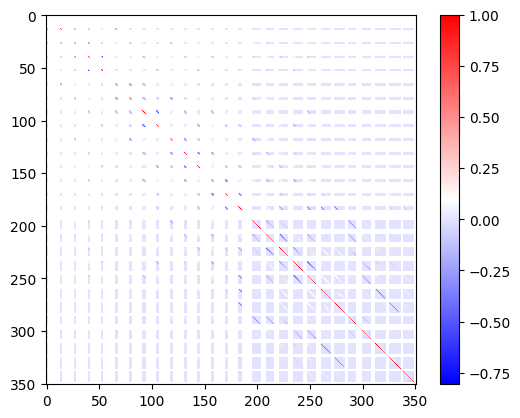

In [63]:
print(gauss_invcov_rotated.shape)
plt.imshow(cov2corr(gauss_invcov_rotated), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()

(351, 351)
(177, 177)


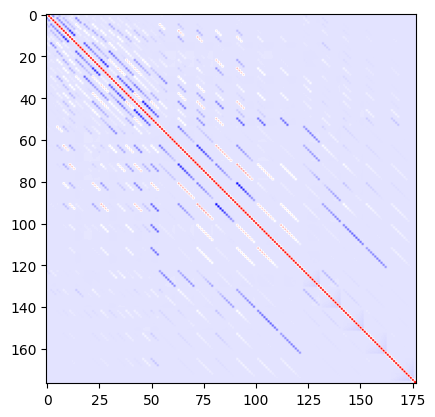

In [64]:
"""Compare with v4 plot"""
print(gauss_invcov_rotated.shape)
cut_1 = gauss_invcov_rotated[~np.all(gauss_invcov_rotated == 0, axis=1)]
plt.imshow(cov2corr(cut_1[:,~np.all(cut_1 == 0, axis=0)]), origin='upper',  cmap='bwr')
print(cut_1[:,~np.all(cut_1 == 0, axis=0)].shape)

#plt.colorbar()
#plt.show()

(351, 351)


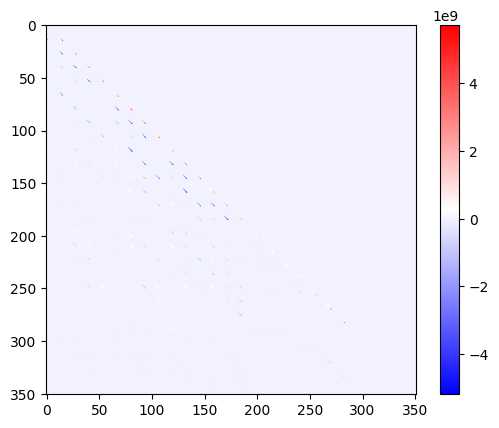

In [225]:
print(L_choleski_inv.shape)
plt.imshow((L_choleski_inv), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()

(351, 351)


/tmp/ipykernel_2580384/3468767144.py:10: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


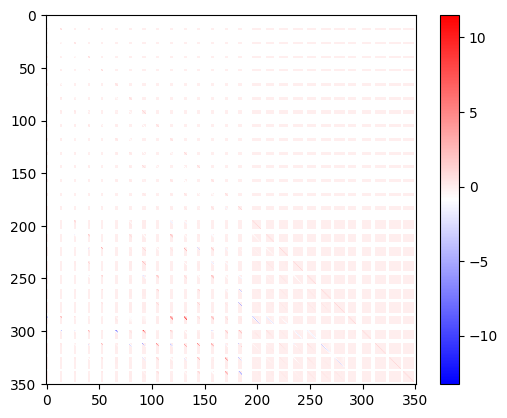

In [226]:
print(L_choleski_inv.shape)
plt.imshow(cov2corr(L_choleski_inv), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()

## 4e (optional). Get noise for C_ells

In [42]:
np.random.seed(22)
D_mockdata_noise = np.random.multivariate_normal(D_mockdata, gauss_cov)

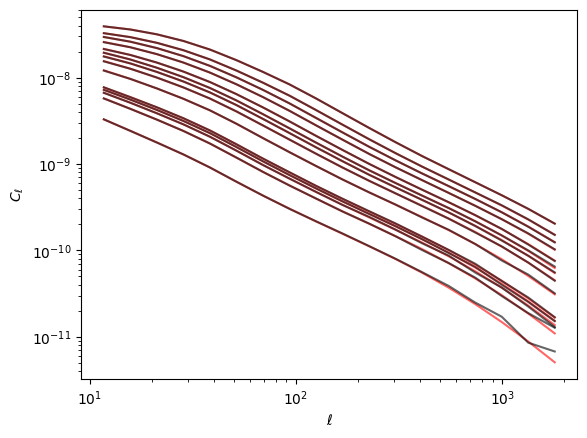

In [43]:
"""Plots: Test noisy C(ell) function"""

ell_bin_number = int(len(ell_mockdata)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))

for j in range(int(len(D_mockdata)/ell_bin_number) - 1):
    plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha=0.6)
    plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata_noise[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha=0.6)
    #plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number]-D_mockdata_noise[j*ell_bin_number:(j+1)*ell_bin_number])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 4f. Package data

In [130]:
# WITHOUT NOISE
C_ell_data_mock = [D_mockdata, ell_mockdata, z,  Binned_distribution_source,\
                   Binned_distribution_lens, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata]

Data_fsigma8 = [z_eff, fsigma_8_data, invcov_fsigma8]
# WITH NOISE
#C_ell_data_mock = [D_mockdata_noise, ell_mockdata, z, Binned_distribution, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata]




# 5. Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [68]:
# Perform PCA with numpy.linalg.svd - find rotation matrix
def findPCA(M_data, B_data, L_ch_inv):
    Delta = np.array(np.matmul(L_ch_inv, (B_data - M_data).T).T)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

## 5 a. tests

In [335]:
"""Package quanitites to imput into likelihood function"""

"""Define MCMC step"""
#MGParams = [0.2,1e-4,1,1.0]

'Define MCMC step'

In [368]:
B1 = np.append(np.append(D_testdata_kk, D_testdata_delk), D_testdata_deldel)
B2 = np.append(np.append(D_testdata_kk_fR, D_testdata_delk_fR), D_testdata_deldel_fR)
B3 = np.append(np.append(D_testdata_GR_kk, D_testdata_GR_delk), D_testdata_GR_deldel)

M1 = np.append(np.append(D_testdata_lin_kk, D_testdata_lin_delk), D_testdata_lin_deldel)
M2 = np.append(np.append(D_testdata_lin_kk_fR, D_testdata_lin_delk_fR), D_testdata_lin_deldel_fR)
M3 = np.append(np.append(D_testdata_GR_lin_kk, D_testdata_GR_lin_delk), D_testdata_GR_lin_deldel)

In [369]:
B_data =np.array([B1,B2,B3])
M_data =np.array([M1,M2,M3])

In [370]:
Delta = np.array(np.matmul(L_choleski_inv,(B_data - M_data).T).T)

print("Size of difference matrix Delta = ", Delta.shape)
print((B_data - M_data).shape)

Size of difference matrix Delta =  (3, 351)
(3, 351)


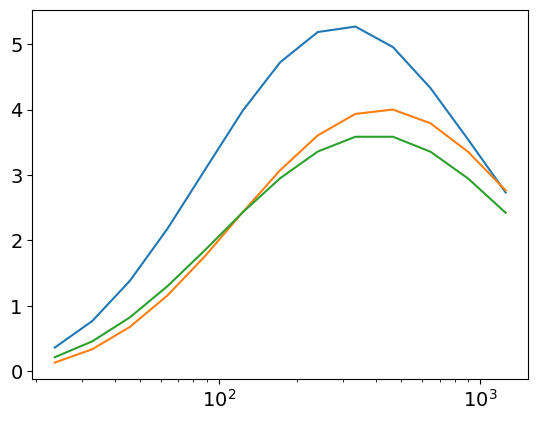

In [376]:
#TEST

Delta_centered = np.zeros((len(Delta),len(Delta[0])))
for i in range(len(Delta[0])):
    offset = np.mean(Delta.T[i])
    Delta_centered[:,i] = Delta[:,i] - offset


plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(B_data)):
    plt.plot(ell_testdata[0:ell_bin_number],Delta[i][0:ell_bin_number])

In [372]:
#TEST: Perform PCA with sklearn (Choose n_components to keep)
pca = PCA()

# Apply sklearn PCA method
sklearn_PCA = pca.fit(Delta)

# Find vectors in direction of PCs (normalized ,positive)
PCAs_vects_sklearn = sklearn_PCA.components_
print("PCA eigenvector array size = ", PCAs_vects_sklearn.shape)

# Find eigenvalues for each PC
PCAs_eigenvals_sklearn = sklearn_PCA.singular_values_

print("eigenvalues = ", PCAs_eigenvals_sklearn)
#find PC vectors with eigenvalues as norm

Usklearn = np.matmul(np.diag(PCAs_eigenvals_sklearn), np.matrix(PCAs_vects_sklearn))

print("PCA norm eigenvector array size = ",Usklearn.shape)

PCA eigenvector array size =  (3, 351)
eigenvalues =  [2.77838932e+02 4.51127565e+01 1.31935163e-13]
PCA norm eigenvector array size =  (3, 351)


In [373]:
#TEST: Perform PCA with numpy.linalg.svd

Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)

Usvd = Usvd.T

print("eigenvalues = ", s)

print("shape U = ", Usvd.shape)
print("shape sigma = ", s.shape)
print("shape V_transpose = ", vh.shape)

eigenvalues =  [1481.82713689   66.46917384   44.97731373]
shape U =  (351, 351)
shape sigma =  (3,)
shape V_transpose =  (3, 3)


In [374]:
def findU_PCAmethod(Delta):
    
    # find eigenvectors and eigenvalues of AAt = Delta*Deltat
    AAt = np.matmul(Delta,np.transpose(Delta))
    eigenvals,eigenvects = np.linalg.eig(AAt)

    eigenvals = eigenvals.real
    eigenvects = eigenvects.real

    # Put eigenvectors and eigenvalues in right order, find U
    #composedmatrix = np.array(np.append([eigenvals],np.transpose(eigenvects), axis = 0))
    #orderedmatrix = composedmatrix[:, (-composedmatrix)[0].argsort()]
    #U = np.transpose(orderedmatrix[1:])
    return eigenvects, eigenvals

In [55]:
""" PCA decomposition"""

# Find Delta as 990 rows and 9 columns
manual_soln = findU_PCAmethod(np.transpose(Delta))
Umanual = manual_soln[0].T
eigenval_manual = manual_soln[1]
print("eigenvalues = ", eigenval_manual[:8]**0.5)


eigenvalues =  [1.99268333e+03 2.11476057e+02            nan            nan
 1.21359393e-05 1.21359393e-05            nan 1.47825604e-05]


/tmp/ipykernel_2120021/3623146480.py:7: RuntimeWarning: invalid value encountered in sqrt
  print("eigenvalues = ", eigenval_manual[:8]**0.5)


In [56]:
print("full eigenvalues = ", np.diag(eigenval_manual)**0.5)

full eigenvalues =  [[1.99268333e+03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.11476057e+02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00            nan ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.32630132e-09
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
             nan 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00            nan]]


/tmp/ipykernel_2120021/4117662826.py:1: RuntimeWarning: invalid value encountered in sqrt
  print("full eigenvalues = ", np.diag(eigenval_manual)**0.5)


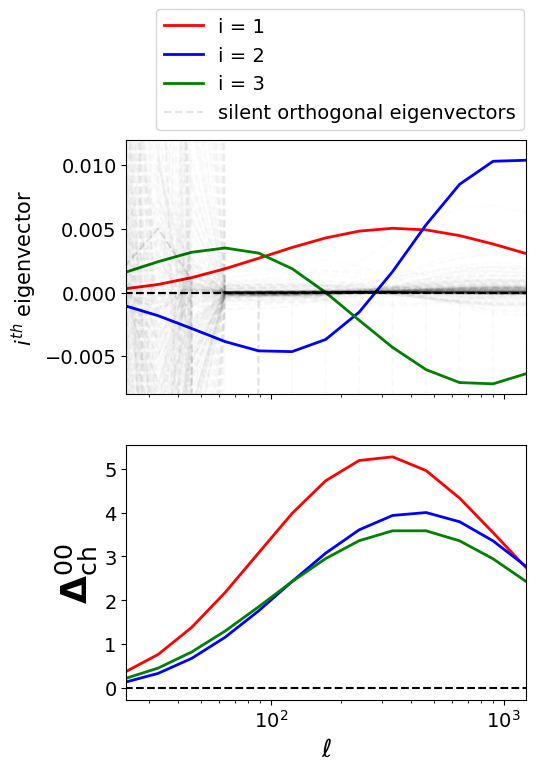

In [428]:
"""Plot PCA components for different methods as a function of ell, and compare with angular power spectra"""

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False,figsize=(5, 7))

for i in range(3):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell_testdata[0:ell_bin_number], -Usvd[i][0: ell_bin_number], linewidth=2, color=["r","b","g"][i])
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[i,0:ell_bin_number], color = "y",linewidth=2+i/2)

ax1.plot(ell_testdata[0:ell_bin_number], -Usvd[3][0: ell_bin_number], "k--", alpha=0.1)
for i in range(len(Usvd)-3):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell_testdata[0:ell_bin_number], -Usvd[i+3][0: ell_bin_number], "k--", alpha=0.01)
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[i,0:ell_bin_number], color = "y",linewidth=2+i/2)

ax1.set_ylim(-0.008,0.012)
ax1.legend(["i = 1","i = 2","i = 3","silent orthogonal eigenvectors"], bbox_to_anchor=(0.05, 1.0) )

ax1.plot(ell_testdata[0:ell_bin_number], np.zeros(len(ell_testdata[0:ell_bin_number])), "k--")

#line2, = ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[0,0:ell_bin_number], label = "centered around zero", color = "y")
#line1, = ax1.plot(ell[0:ell_bin_number], -Usvd[0][0: ell_bin_number], color = "r" , label = "not centered", linewidth=2)

#line1.remove()
#line2.remove()

ax1.set_ylabel(r'$i^{th}$ eigenvector', size = 15)
plt.xscale("log")


for i in range(len(B_data)):
    ax2.plot(ell_testdata[0:ell_bin_number],Delta[i][0:ell_bin_number], linewidth=2, color=["r","b","g"][i])
ax2.plot(ell_testdata[0:ell_bin_number], np.zeros(len(ell_testdata[0:ell_bin_number])), "k--")

ax2.set_ylabel(r'$\mathbf{\Delta}^{00}_{\text{ch}}$', size = 26)
ax2.set_xlabel(r'$\ell$', size = 18)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
ax1.set_xlim(24,1.25e3)


#plt.savefig('/home/c2042999/PCA_project/PC_flowchart.pdf' , bbox_inches='tight')
plt.show()



In [ ]:
"""Plot PCA components for different methods as a function of ell, and compare with angular power spectra"""

f, (ax1, ax3, ax2) = plt.subplots(3, sharex=True, sharey=False,figsize=(8, 8))

ell_bin_num = ell_bin_number
for i in range(len(B_data)):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell_testdata[0:ell_bin_num], Usvd[i][0: ell_bin_num],linewidth=3 - 0.8*i, label = '{}th PC'.format(i+1))
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_num], PCAs_vects_sklearn[i,0:ell_bin_num], color = "y",linewidth=2+i/2)
    
ax1.plot(ell_testdata[0:ell_bin_num], np.zeros(len(ell_testdata[0:ell_bin_num])), "k--")

#line2, = ax1.plot(ell[0:ell_bin_num], PCAs_vects_sklearn[0,0:ell_bin_num], label = "centered around zero", color = "y")
#line1, = ax1.plot(ell[0:ell_bin_num], -Usvd[0][0: ell_bin_num], color = "r" , label = "not centered", linewidth=2)
ax1.legend(bbox_to_anchor=(1.0, 0.3))

for i in range(len(B_data)):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax3.plot(ell_testdata[0:ell_bin_num], Usvd[i][0: ell_bin_num]*s[i],linewidth=3 - 0.8*i, label = '{}th PC'.format(i+1))
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_num], PCAs_vects_sklearn[i,0:ell_bin_num], color = "y",linewidth=2+i/2)
    
ax3.plot(ell_testdata[0:ell_bin_num], np.zeros(len(ell_testdata[0:ell_bin_num])), "k--")


#line1.remove()
#line2.remove()

ax1.set_ylabel(r'$PC_i$', size = 15)
ax3.set_ylabel(r'$Q_i PC_i$', size = 15)
plt.xscale("log")

#plt.ylim(0,0.5)
for i in range(len(B_data)):
    ax2.plot(ell_testdata[0:ell_bin_num],Delta[i][0:ell_bin_num])
ax2.plot(ell_testdata[0:ell_bin_num], np.zeros(len(ell_testdata[0:ell_bin_num])), "k--")

ax2.set_ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
ax2.set_xlabel(r'$\ell$', size = 15)

ax2.legend(["nDGP", r"$f(R)$", "GR"], bbox_to_anchor=(1.0, 0.4))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
ax1.set_xlim(23, 1280)


#plt.savefig('PC_plots.pdf' , bbox_inches='tight')
plt.show()



# 6. Likelihood function

In [132]:
# log likelihood - no PCA cuts
def loglikelihood_noscalecut(Data, cosmo, MGparams, InvCovmat, Bias_distribution, data_fsigma8):
    #start = time.time()
    
    # Extract fsigma8 data vector
    z_fsigma8, fsigma_8_dataset, invcovariance_fsigma8 = data_fsigma8
    
    # Extract 3x2pt data vector
    D_data, ell_mockdata, z, Binned_distribution_s,Binned_distribution_l,\
                   ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata = Data

    # shape-shape
    binned_ell_kk = bin_ell_kk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_s)

    # shape-pos
    binned_ell_delk = bin_ell_delk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                              Binned_distribution_s,Binned_distribution_l)

    # pos-pos
    binned_ell_deldel = bin_ell_deldel(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_l)

    # Precompute Pk2D objects
    P_delta2D_muSigma_kk = Get_Pk2D_obj(cosmo, MGparams, linear=True, gravity_model="muSigma")
    P_delta2D_muSigma_delk = Get_Pk2D_obj_delk_musigma(cosmo, MGparams)
    P_delta2D_muSigma_deldel = Get_Pk2D_obj_deldel_musigma(cosmo, MGparams)
    
    ########## Get theoretical data vector for single MCMC step - linear , muSigmaparam ##########
    # shape-shape
    D_theory_kk = np.array(Cell(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                P_delta2D_muSigma_kk, tracer1_type="k", tracer2_type="k")[1]).flatten()
    # shape-pos
    
    D_theory_delk = np.array(Cell(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                P_delta2D_muSigma_delk, tracer1_type="g", tracer2_type="k")[1]).flatten()
    # pos-pos

    D_theory_deldel = np.array(Cell(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                P_delta2D_muSigma_deldel, tracer1_type="g", tracer2_type="g")[1]).flatten()

    D_theory = np.append(np.append(D_theory_kk, D_theory_delk), D_theory_deldel)
    
    Diff = (D_data - D_theory)

    #print("time = ", time.time() - start)

    #### fsigma8 ####
    Diff_fsigma8 = fsigma_8_dataset - fsigma8_musigma(cosmo, MGparams, 1/(z_fsigma8+1))
    loglik_fsigma8 = -0.5*(np.matmul(np.matmul(Diff_fsigma8,invcovariance_fsigma8),Diff_fsigma8))

    return -0.5*(np.matmul(np.matmul(Diff,InvCovmat),Diff)) + loglik_fsigma8 
    
# log likelihood with cut data
# P_k_sim = P_k_sim_mock
# Data = C_ell_data_mock
# Covmat = gauss_cov
def loglikelihood(Data, cosmo,cosmo_linear, MGparams, L_ch, L_ch_inv, Bias_distribution, data_fsigma8):
    
    #start = time.time()
    z_fsigma8, fsigma_8_dataset, invcovariance_fsigma8 = data_fsigma8

    # Extract real data vector
    D_data, ell_mockdata, z, Binned_distribution_s,Binned_distribution_l,\
                ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata = Data

    # Do binning
    binned_ell_kk = bin_ell_kk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_s)
    binned_ell_delk = bin_ell_delk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                              Binned_distribution_s,Binned_distribution_l)
    binned_ell_deldel = bin_ell_deldel(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_l)

    # Precompute Pk2D objects
    P_delta2D_muSigma_kk = Get_Pk2D_obj(cosmo, MGparams, linear=True, gravity_model="muSigma")
    P_delta2D_muSigma_delk = Get_Pk2D_obj_delk_musigma(cosmo, MGparams)
    P_delta2D_muSigma_deldel = Get_Pk2D_obj_deldel_musigma(cosmo, MGparams)
    
    P_delta2D_nDGP_lin = Get_Pk2D_obj(cosmo, MGparams, linear=True, gravity_model="nDGP")
    P_delta2D_nDGP_nl = Get_Pk2D_obj(cosmo, MGparams, linear=False, gravity_model="nDGP")
    P_delta2D_fR_lin = Get_Pk2D_obj(cosmo, MGparams, linear=True, gravity_model="f(R)")
    P_delta2D_fR_nl = Get_Pk2D_obj(cosmo, MGparams, linear=False, gravity_model="f(R)")
    
    ########## Get theoretical data vector for single MCMC step - linear , muSigmaparam ##########
    # shape-shape
    D_theory_kk = (np.array(Cell(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_muSigma_kk,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    D_theory_delk = (np.array(Cell(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_muSigma_delk,\
                tracer1_type="k", tracer2_type="g")[1])).flatten()
    # pos-pos
    D_theory_deldel = (np.array(Cell(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_muSigma_deldel,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    D_theory = np.concatenate((D_theory_kk, D_theory_delk, D_theory_deldel), axis=0)
    
    Diff = (D_data - D_theory)
    
    # Find Choleski scaled data vector
    Diff_ch = np.array(np.matmul(L_ch_inv, Diff.T))[0]

    ########## GET DATA FOR DIFFERENCE MATRIX ##########
    """MG1: nDGP"""
    # A: find C_ell for non-linear matter power spectrum
    # shape-shape
    B1_kk = (np.array(Cell(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_nDGP_nl,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    B1_delk = (np.array(Cell(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_nDGP_nl,\
                tracer1_type="g", tracer2_type="k")[1])).flatten()
    # pos-pos
    B1_deldel = (np.array(Cell(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_nDGP_nl,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    B1 = np.concatenate((B1_kk, B1_delk, B1_deldel), axis=0)
       
    # B: find C_ell for linear matter power spectrum
    # shape-shape
    M1_kk = (np.array(Cell(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_nDGP_lin,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    M1_delk = (np.array(Cell(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_nDGP_lin,\
                tracer1_type="g", tracer2_type="k")[1])).flatten()
    # pos-pos
    M1_deldel = (np.array(Cell(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_nDGP_lin,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    M1 = np.concatenate((M1_kk, M1_delk, M1_deldel), axis=0)

    """MG2: f(R)""" 
        
    # A: find C_ell for non-linear matter power spectrum
    # shape-shape 
    B3_kk = (np.array(Cell(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_fR_nl,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    B3_delk = (np.array(Cell(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_fR_nl,\
                tracer1_type="g", tracer2_type="k")[1])).flatten()
    # pos-pos
    B3_deldel = (np.array(Cell(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_fR_nl,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    B3 = np.concatenate((B3_kk, B3_delk, B3_deldel), axis=0)
       
    # B: find C_ell for linear matter power spectrum
    # shape-shape
    M3_kk = (np.array(Cell(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_fR_lin,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    M3_delk = (np.array(Cell(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_fR_lin,\
                tracer1_type="g", tracer2_type="k")[1])).flatten()
    # pos-pos
    M3_deldel = (np.array(Cell(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,P_delta2D_fR_lin,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    M3 = np.concatenate((M3_kk, M3_delk, M3_deldel), axis=0)
    
    """GR"""
    # shape-shape
    B2_kk = (np.array(Cell_GR(binned_ell_kk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    B2_delk = (np.array(Cell_GR(binned_ell_delk, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                tracer1_type="g", tracer2_type="k")[1])).flatten()
    # pos-pos
    B2_deldel = (np.array(Cell_GR(binned_ell_deldel, \
                cosmo, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    B2 = np.concatenate((B2_kk, B2_delk, B2_deldel), axis=0)
       
    # B: find C_ell for linear matter power spectrum
    # shape-shape
    M2_kk = (np.array(Cell_GR(binned_ell_kk, \
                cosmo_linear, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                tracer1_type="k", tracer2_type="k")[1])).flatten()
    # shape-pos
    M2_delk = (np.array(Cell_GR(binned_ell_delk, \
                cosmo_linear, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                tracer1_type="g", tracer2_type="k")[1])).flatten()
    # pos-pos
    M2_deldel = (np.array(Cell_GR(binned_ell_deldel, \
                cosmo_linear, z , Binned_distribution_s,Binned_distribution_l,Bias_distribution,MGparams,\
                tracer1_type="g", tracer2_type="g")[1])).flatten()

    M2 = np.concatenate((M2_kk, M2_delk, M2_deldel), axis=0)

    ### COMBINE
    
    B_data =np.array([B1,B2,B3])
    M_data =np.array([M1,M2,M3])

    # EXTRACT PCA MATRIX
    Usvd = findPCA(M_data, B_data, L_ch_inv)

    # Cut data vector (choleski cov. matrix = I)
    Diff_cut = np.matmul(Usvd[len(M_data):], Diff_ch.T)
    
    #print("time = ", time.time() - start)
    
    #### fsigma8 ####
    Diff_fsigma8 = fsigma_8_dataset - fsigma8_musigma(cosmo, MGparams, 1/(z_fsigma8+1))
    loglik_fsigma8 = -0.5*(np.matmul(np.matmul(Diff_fsigma8,invcovariance_fsigma8),Diff_fsigma8))
    
    return -0.5*(np.matmul(Diff_cut.T,Diff_cut)) + loglik_fsigma8 

In [175]:
%%time
# Check what should be correct for GR
print(loglikelihood(C_ell_data_mock, cosmo_universe,cosmo_universe_linear, [0.2 , 1e-4 , 1.0 , 0.0 , 0.0], L_choleski, L_choleski_inv,Bias_distribution_fiducial, Data_fsigma8))

-116.14552367822404
CPU times: user 1.7 s, sys: 11.9 ms, total: 1.71 s
Wall time: 1.71 s


In [189]:

%%time
# Change mu
print(loglikelihood(C_ell_data_mock, cosmo_universe, cosmo_universe_linear, [0.2 , 1e-4 , 1.0 , 0.0147,0.0], L_choleski, L_choleski_inv,Bias_distribution_fiducial, Data_fsigma8))

-107.03609729859397
CPU times: user 1.69 s, sys: 4.14 ms, total: 1.7 s
Wall time: 1.69 s


In [136]:
print(1/(2*np.sqrt([0.2, 20])))
cosmo_newtest = ccl.Cosmology(Omega_c = cosmo_universe["Omega_c"], 
                          Omega_b = cosmo_universe["Omega_b"], 
                          h = cosmo_universe["h"],
                          n_s = cosmo_universe["n_s"],
                          A_s = 2.1e-9)

cosmo_newtest_linear = ccl.Cosmology(Omega_c = cosmo_universe["Omega_c"], 
                          Omega_b = cosmo_universe["Omega_b"], 
                          h = cosmo_universe["h"],
                          n_s = cosmo_universe["n_s"],
                          A_s = 2.1e-9,
                          matter_power_spectrum='linear')

[1.11803399 0.1118034 ]


In [184]:
#Change As
print(loglikelihood(C_ell_data_mock, cosmo_newtest, cosmo_newtest_linear, [0.2 , 1e-4 , 1 , 0.0147,0.0], L_choleski, L_choleski_inv,Bias_distribution_fiducial, Data_fsigma8))

-77.91688883082195


In [138]:
print(loglikelihood_noscalecut(C_ell_data_mock, cosmo_universe, [0.2 , 1e-4 , 1 ,  0.0147,0.0], gauss_invcov_rotated,Bias_distribution_fiducial, Data_fsigma8))


-18822.866349947955


# 8. Run the MCMC - compare different methods

## 8a. run with PCA method as scale cuts

In [151]:
def log_likelihood(theta, Data, L_ch, L_ch_inv,Data_fsigma8):
    Omega_c, mu0,Sigma0, A_s1e9, h, n_s, wb, b1, b2, b3, b4, b5 = theta
    Bias_distribution = np.array([b1*np.ones(len(z)),
                             b2*np.ones(len(z)),
                             b3*np.ones(len(z)),
                             b4*np.ones(len(z)),
                             b5*np.ones(len(z))])
    #h = cosmo_universe["h"]
    #A_s = cosmo_universe["A_s"]
    A_s = A_s1e9*1e-9
    #n_s = cosmo_universe["n_s"]
    MGparams = [0.2,1e-4,1.0,mu0,Sigma0]

    cosmo = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = wb/h**2,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    
    cosmo_linear = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = wb/h**2,
                      h = h,
                      n_s = n_s,
                      A_s = A_s,
                      matter_power_spectrum='linear')

    return loglikelihood(Data, cosmo,cosmo_linear, MGparams,  L_ch, L_ch_inv,Bias_distribution,Data_fsigma8)

In [152]:
#### Get Planck priors #####

In [153]:
"""sampler_Planck_arrfull = pd.read_fwf("/home/c2042999/PCA_project//gaussian.1.txt")
length_planck = len(sampler_Planck_arrfull["ns"])
sampler_Planck_arr = []
sampler_Planck_arr = np.concatenate((np.array(sampler_Planck_arrfull["ns"]).reshape(length_planck,1),
                                    np.array(sampler_Planck_arrfull["ombh2"]).reshape(length_planck,1)), axis = 1)

print(sampler_Planck_arr.shape)
np.save("/home/c2042999/PCA_project/Prior_Planck_arr.npy", sampler_Planck_arr)
"""

'sampler_Planck_arrfull = pd.read_fwf("/home/c2042999/PCA_project//gaussian.1.txt")\nlength_planck = len(sampler_Planck_arrfull["ns"])\nsampler_Planck_arr = []\nsampler_Planck_arr = np.concatenate((np.array(sampler_Planck_arrfull["ns"]).reshape(length_planck,1),\n                                    np.array(sampler_Planck_arrfull["ombh2"]).reshape(length_planck,1)), axis = 1)\n\nprint(sampler_Planck_arr.shape)\nnp.save("/home/c2042999/PCA_project/Prior_Planck_arr.npy", sampler_Planck_arr)\n'

In [154]:
sampler_Planck_arr = np.load("/home/c2042999/PCA_project/Prior_Planck_arr.npy")

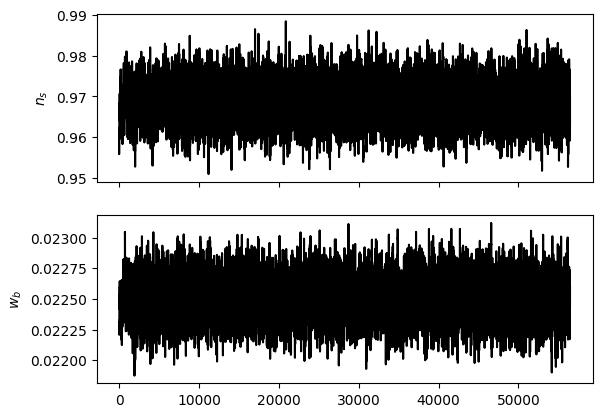

In [155]:
fig, ax = plt.subplots(len(sampler_Planck_arr.T), sharex=True)
labels = [ r"$n_s$", r"$w_b$"]

for i in range(len(sampler_Planck_arr.T)):
    ax[i].plot(sampler_Planck_arr[:,i], color = "black")
    ax[i].set_ylabel(labels[i])



In [156]:
burnin = 0
ndim = len(labels)

cov_prior = np.cov(sampler_Planck_arr.T)
"""
mu_prior = []
for i in range(ndim):
    mcmc = np.percentile(sampler_Planck_arr[:, i], [16, 50, 84])
    mu_prior.append(mcmc[1])
"""
mu_prior = [cosmo_universe['n_s'], cosmo_universe["Omega_b"]*cosmo_universe["h"]**2]

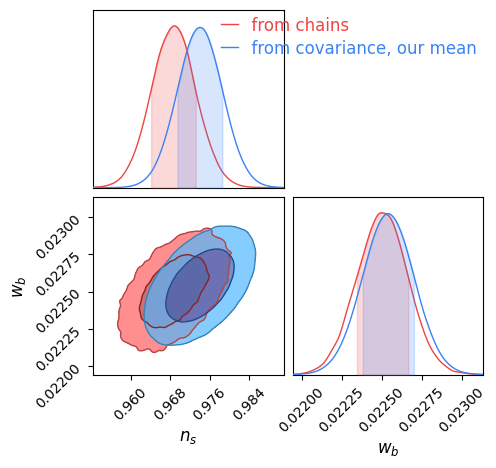

In [157]:
#### CHECK SUFFICIENTLY GAUSSIAN ####
df = pd.DataFrame(sampler_Planck_arr, columns=labels, index=np.arange(0,len(sampler_Planck_arr)))

chain2 = Chain.from_covariance(
    mu_prior, cov_prior,
    plot_contour=True, columns=labels, 
    color='blue', name=r'from covariance, our mean', 
    linewidth=1, linestyle='-'
)

c = ChainConsumer()
c.add_chain(Chain(samples=df, color="r", name="from chains"))
c.add_chain(chain2)
fig = c.plotter.plot(figsize = 0.5)

In [158]:
def log_prior(theta):
    Omega_c, mu0,Sigma0, A_s1e9, h, n_s, wb, b1, b2, b3, b4, b5 = theta 

    #flat priors
    if not (0.28 < Omega_c + wb/h**2 < 0.36 and -2.0 < mu0 < 0.95 and -2.0 < Sigma0 < 0.95 and mu0 <= 2*Sigma0 + 1.0 \
            and 1.7 < A_s1e9 < 2.5 and 0.92 < n_s < 1 and 0.61 < h < 0.73 and 0.04 < wb/h**2 < 0.06 \
           and 0.8 < b1 < 3.0 and 0.8 < b2 < 3.0 and 0.8 < b3 < 3.0 and 0.8 < b4 < 3.0 and 0.8 < b5 < 3.0):
        return -np.inf
        
    gauss_funct = scipy.stats.multivariate_normal(mu_prior, cov_prior)
    
    return gauss_funct.logpdf([n_s, wb])


In [159]:
def log_probability(theta, Data,  L_ch, L_ch_inv,Data_fsigma8):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Data,  L_ch, L_ch_inv,Data_fsigma8)

In [160]:
def log_probability_global(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, C_ell_data_mock, L_choleski, L_choleski_inv,Data_fsigma8)

In [161]:
#print(np.append(1e-2 * np.random.randn(15, 2).T, [2e-10 * np.random.randn(15)], axis = 0))

In [164]:
#MCMC method


# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
Omega_c_est = 0.27
h_est = 0.7
A_s1e9_est = 2.1
n_s_est = 0.94
mu0_est = 0.1
Sigma0_est = 0.05
wb_est = 0.0223
b1_est = Bias_distribution_fiducial[0][0]
b2_est = Bias_distribution_fiducial[1][0]
b3_est = Bias_distribution_fiducial[2][0]
b4_est = Bias_distribution_fiducial[3][0]
b5_est = Bias_distribution_fiducial[4][0]

pos = [Omega_c_est, mu0_est,Sigma0_est, A_s1e9_est, h_est, n_s_est, wb_est,b1_est,b2_est,b3_est,b4_est,b5_est] \
+ np.append(np.append(1e-3 * np.random.randn(75, 5), 1e-5*np.random.randn(75, 2), axis = 1), \
            1e-3 * np.random.randn(75, 5), axis = 1)

nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

sampler_PCA = emcee.EnsembleSampler(nwalkers, ndim, log_probability_global, backend=backend)
sampler_PCA.run_mcmc(pos, 3000, progress=True);

emcee: Exception while calling your likelihood function:
  params: [0.27227768 0.10066347 0.04933237 2.09922534 0.69983537 0.93998982
 0.02229343 1.2298071  1.36170513 1.50201638 1.64768087 1.79936577]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2580384/1961566704.py", line 5, in log_probability_global
    return lp + log_likelihood(theta, C_ell_data_mock, L_choleski, L_choleski_inv,Data_fsigma8)
  File "/tmp/ipykernel_2580384/4199967925.py", line 27, in log_likelihood
    return loglikelihood(Data, cosmo,cosmo_linear, MGparams,  L_ch, L_ch_inv,Bias_distribution,Data_fsigma8)
  File "/tmp/ipykernel_2580384/36861733.py", line 81, in loglikelihood
    P_delta2D_fR_lin = Get_Pk2D_obj(cosmo, MGparams, linear=True, gravity_model="f(R)")
  File "/tmp/ipykernel_2580384/889235245.py", line 103, in Get_Pk2D_obj
    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)
  File "/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/pyccl/pk2d.py", line 124, in from_function
    pk_arr = np.array([pkfunc(k=np.ex

KeyboardInterrupt: 

In [ ]:
converged = False
chain_len = 10
print(cpu_count() - 5)

# Initialise a pool 
with Pool(cpu_count() - 5) as pool:
    sampler_PCA = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability_global, pool=pool)
    
    while not converged:

        # Sample 
        sampler_PCA.run_mcmc(pos, chain_len, progress=True)

        # Update the initial positions
        pos = sampler_PCA.get_last_sample()

        # Check convergence
        tau = sampler_PCA.get_autocorr_time(tol=0)
        converged = np.all(tau * 50 < sampler_PCA.iteration)


75


  0%|                                                                                                                                                                                | 0/10 [00:09<?, ?it/s]Process ForkPoolWorker-1404:
Process ForkPoolWorker-1448:
Process ForkPoolWorker-1429:
Process ForkPoolWorker-1452:
Process ForkPoolWorker-1430:
Process ForkPoolWorker-1446:
Process ForkPoolWorker-1419:
Process ForkPoolWorker-1424:
Process ForkPoolWorker-1435:
Process ForkPoolWorker-1405:
Process ForkPoolWorker-1410:
Process ForkPoolWorker-1439:
Process ForkPoolWorker-1415:
Process ForkPoolWorker-1450:
Process ForkPoolWorker-1417:
Process ForkPoolWorker-1408:
Process ForkPoolWorker-1449:
Process ForkPoolWorker-1437:
Process ForkPoolWorker-1434:
Process ForkPoolWorker-1431:
Process ForkPoolWorker-1438:
Process ForkPoolWorker-1440:
Process ForkPoolWorker-1418:
Traceback (most recent call last):
Process ForkPoolWorker-1421:
Process ForkPoolWorker-1432:
Process ForkPoolWorker-1414:
Traceba

In [ ]:
# Save chains

print(sampler_PCA.chain.shape)
#np.save("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/fR_DEParam_PCAcut.npy", sampler_PCA.chain)

In [141]:
sampler_PCA_arr = np.load("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/fR_DEParam_PCAcut.npy")

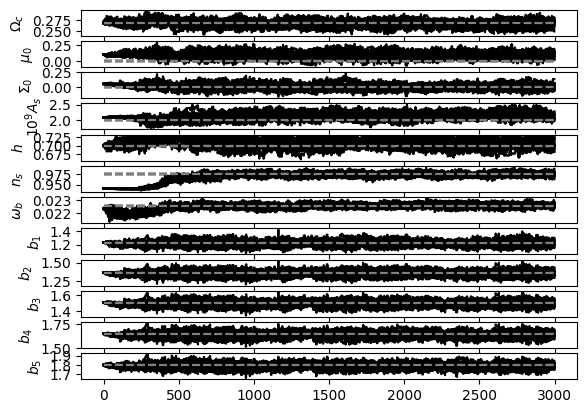

In [99]:
fig, ax = plt.subplots(len(sampler_PCA_arr[0, 0, :]), sharex=True)
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0,cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0]]

for i in range(len(sampler_PCA_arr)):
    for j in range(len(sampler_PCA_arr[0, 0, :])):
        ax[j].plot(sampler_PCA_arr[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_PCA_arr[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        

In [153]:
### get sigma8 ####
sigma8_chain = np.zeros(sampler_PCA_arr[:, :, 0].shape)
S8_chain = np.zeros(sampler_PCA_arr[:, :, 0].shape)

for i in tqdm(range(len(sampler_PCA_arr[0, :, 0]))):
    for j in range(len(sampler_PCA_arr[:, 0, 0])):
        cosmo_postprocessing = ccl.Cosmology(Omega_c = sampler_PCA_arr[j, i, 0],
                           Omega_b =  sampler_PCA_arr[j, i, 5]/sampler_PCA_arr[j, i, 3]**2,
                           h = sampler_PCA_arr[j, i, 3],
                           n_s = sampler_PCA_arr[j, i, 4],
                           A_s = sampler_PCA_arr[j, i, 2])
        sigma8_MG = sigma_8_musigma(cosmo_postprocessing, [0.0,0.0,0.0,sampler_PCA_arr[j, i, 1]], 1)
        sigma8_chain[j,i] = sigma8_MG
        S8_chain[j,i] = sigma8_MG * np.sqrt(cosmo_postprocessing["Omega_m"]/0.3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.17s/it]


In [154]:
print(sigma8_chain.shape)

(25, 15)


In [158]:
sampler_PCA_arr = np.append(np.append(sampler_PCA_arr, sigma8_chain.reshape(25,15,1), axis = 2), S8_chain.reshape(25,15,1), axis = 2)

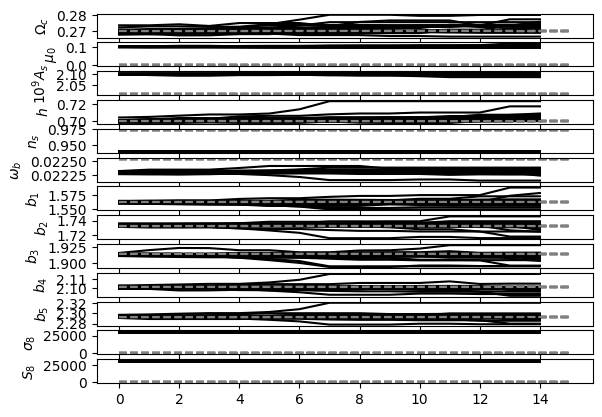

In [159]:
fig, ax = plt.subplots(len(sampler_PCA_arr[0, 0, :]), sharex=True)
labels = [r"$\Omega_c$", r"$\mu_0$", r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$', r'$\sigma_8$', r'$S_8$']

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0,cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0],sigma_8_musigma(cosmo_universe, [0.0,0.0,0.0,0.0], 1),\
         sigma_8_musigma(cosmo_universe, [0.0,0.0,0.0,0.0], 1)*np.sqrt(cosmo_universe["Omega_m"]/0.3)]

for i in range(len(sampler_PCA_arr)):
    for j in range(len(sampler_PCA_arr[0, 0, :])):
        ax[j].plot(sampler_PCA_arr[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_PCA_arr[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        

<>:70: DeprecationWarning: invalid escape sequence '\m'
<>:70: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_2520151/1382074253.py:70: DeprecationWarning: invalid escape sequence '\m'
  """


(62500, 12)


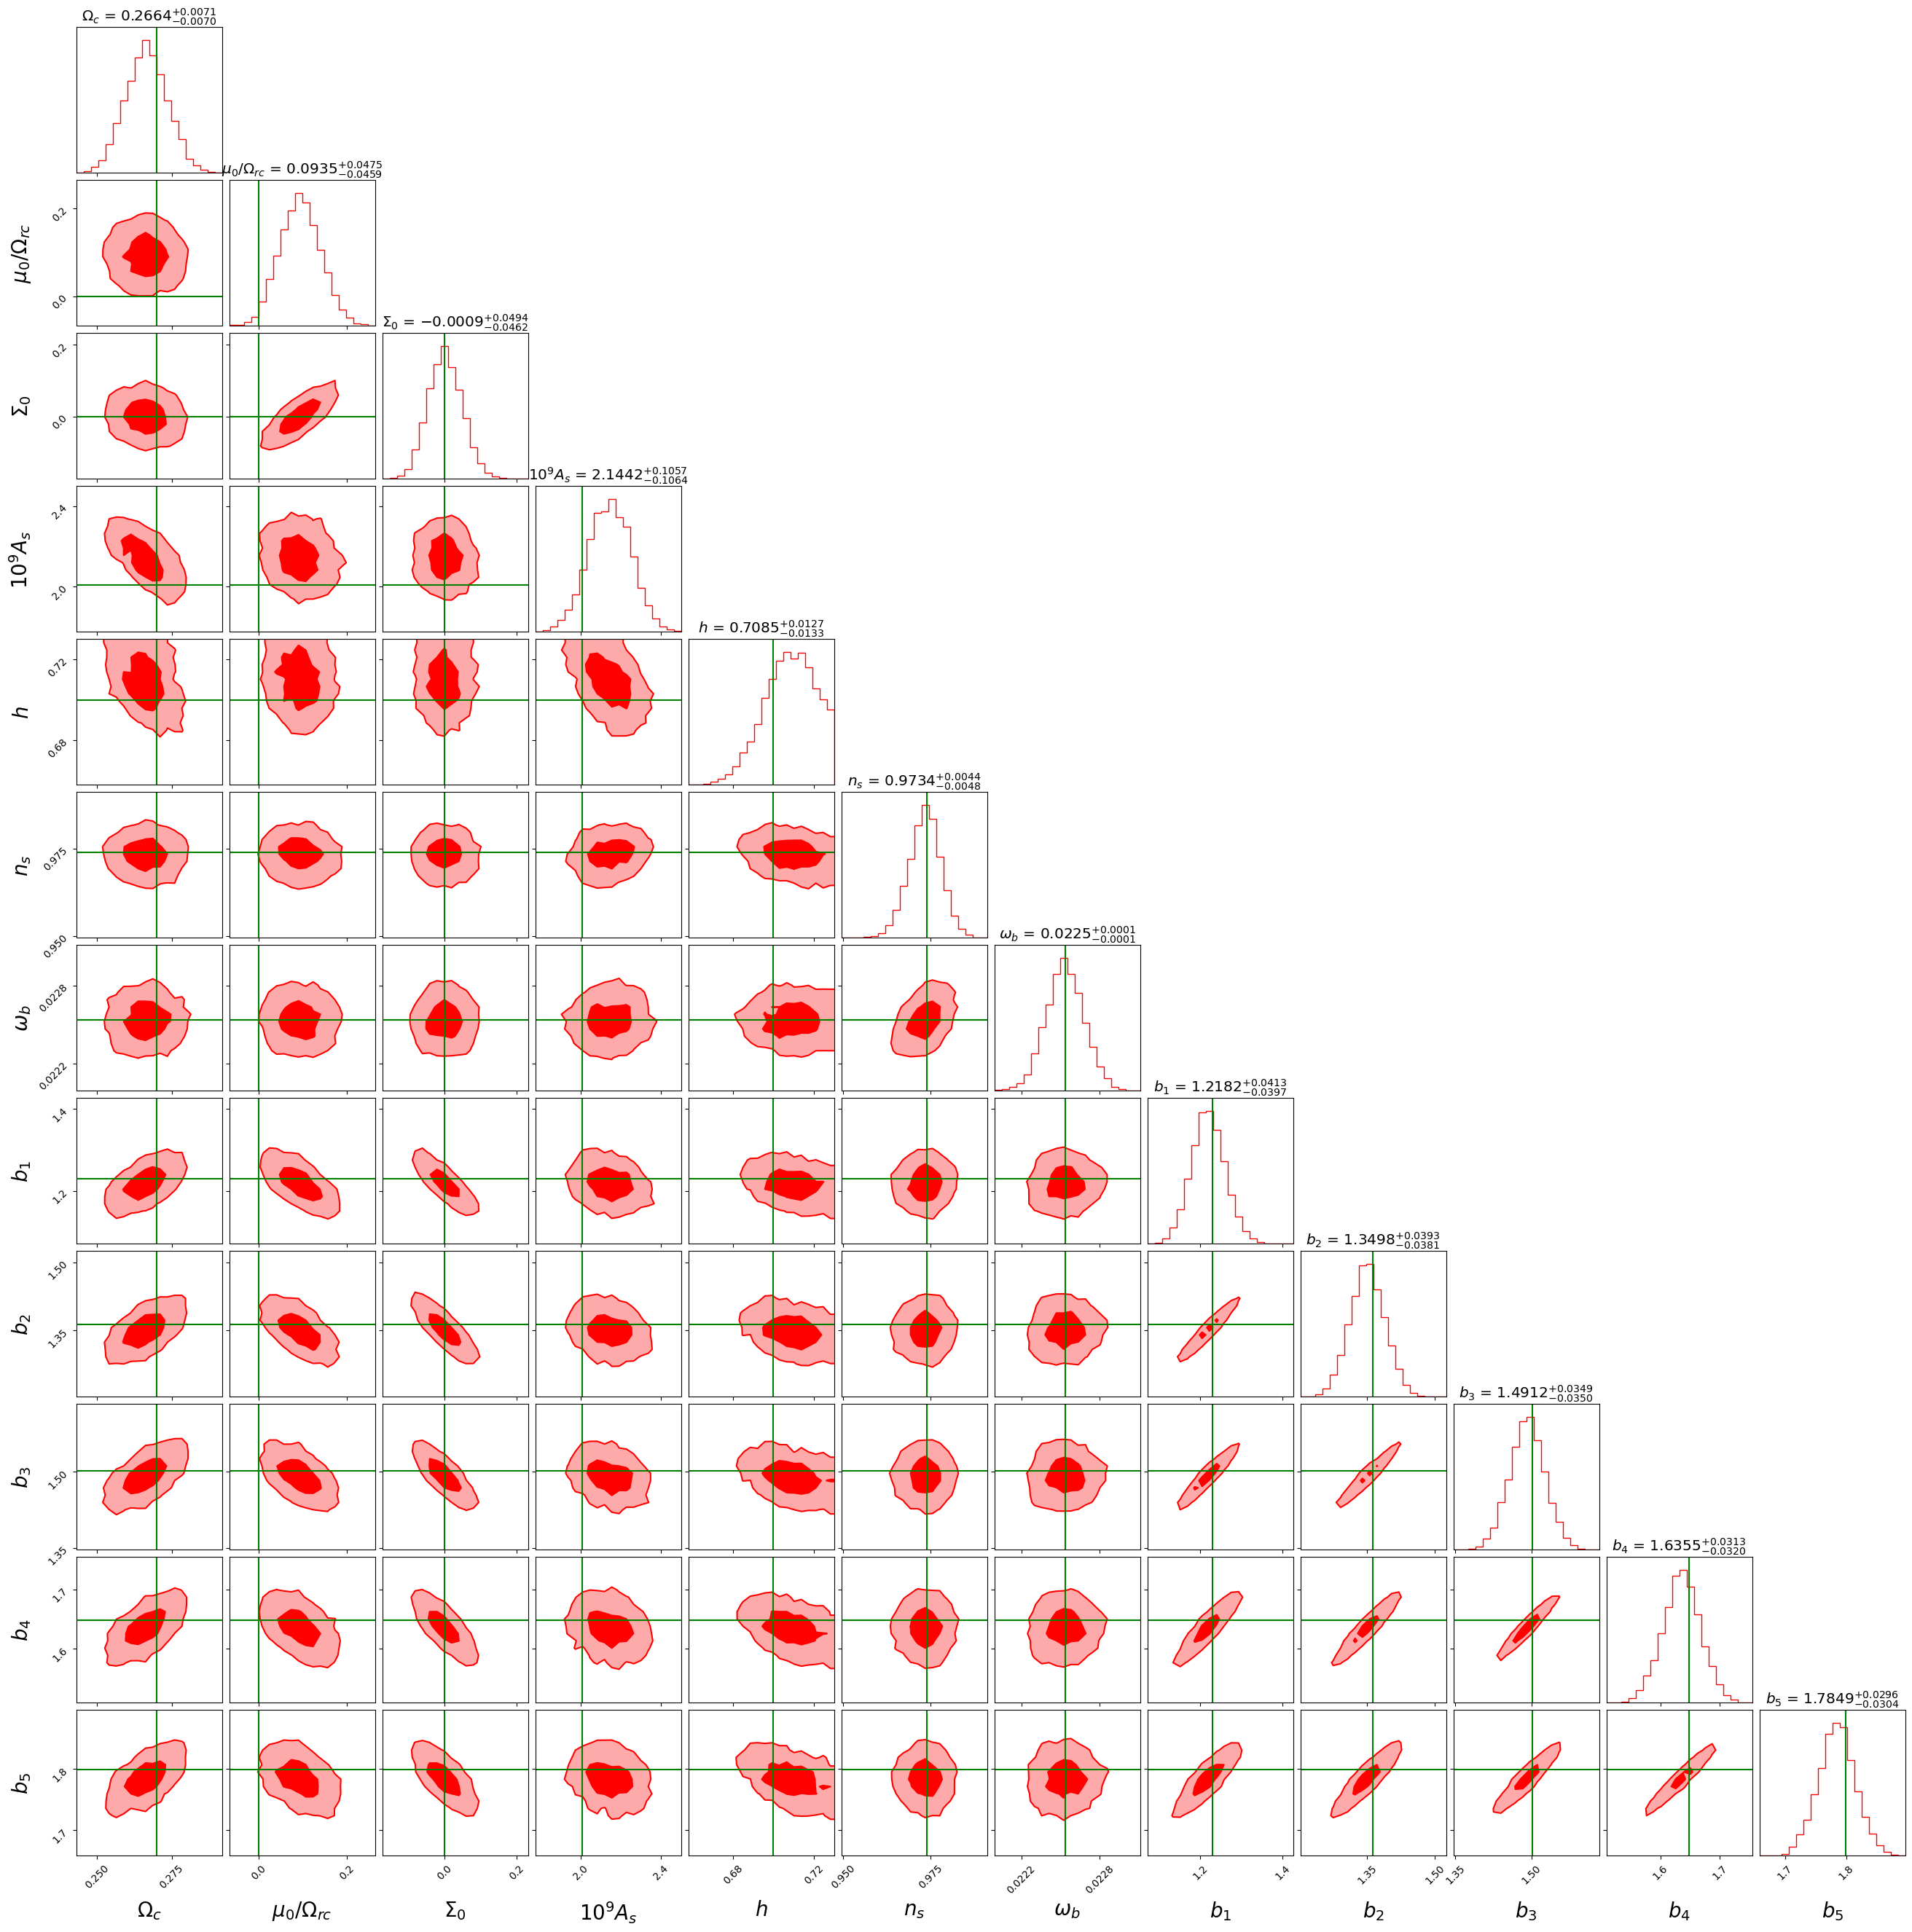

In [184]:
### STANDARD CUTS ####
"""
burnin = 1500
ndim = len(labels)
final_length_scalecut = len(sampler_scalecut_arr)*(len(sampler_scalecut_arr[0])-burnin)

CORNER_KWARGS_scalecut = dict(
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_density=False,
    plot_datapoints=False,
    plot_contours=True,
    fill_contours=True)


flat_samples = sampler_scalecut_arr[:,burnin:].reshape(final_length_scalecut,ndim)

figure = corner.corner(
    flat_samples, **CORNER_KWARGS_scalecut, labels=labels, color="b"
);
"""
### PCA ####

burnin = 500
ndim = len(labels)
final_length = len(sampler_PCA_arr)*(len(sampler_PCA_arr[0])-burnin)
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=14.5),
    show_titles=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    weights = np.ones(final_length) * (final_length_scalecut / final_length)

)

flat_samples = sampler_PCA_arr[:,burnin:].reshape(final_length,ndim)

print(flat_samples.shape)

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color="r"
);
"""
corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, fig=figure, color = "r"
);
"""
######################

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")

########################
"""
# Plot prior on mu/Sigma for numerical instability
mu_0_array_plot = np.linspace(-1,4,10)
axes[2, 1].fill_between(mu_0_array_plot,(mu_0_array_plot - 1)/2,   min((mu_0_array_plot - 1)/2), hatch="//", facecolor="g", alpha=.5)
#mu0 <= 2*Sigma0 + 1.0 

axes[-1, -1].fill_between(mu_0_array_plot,(mu_0_array_plot - 1)/2,   min((mu_0_array_plot - 1)/2), hatch="//", facecolor="g", alpha=.5)
plt.legend(["classic scale cuts, dark \n energy parametrization","PCA cuts, dark \n energy parametrization","input cosmology",r"$\mu \geq 2 \Sigma + 1$"], bbox_to_anchor=(1.0, 6.3), fontsize=25)
axes[-1, -1].lines[-1].remove()  # remove the first line in ax1
"""
#plt.savefig("/home/c2042999/PCA_project/3x2pt_fsigma8_Planckpriors_nDGP_cutcompare.pdf", bbox_inches='tight')

In [98]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 8b. run with classic scale cuts

### Run MCMC

In [136]:
def log_likelihood(theta, Data, fsigma8_Data, invcovmat):
    Omega_c, mu0,Sigma0, A_s1e9, h, n_s, wb, b1, b2, b3, b4, b5 = theta 
    Bias_distribution = np.array([b1*np.ones(len(z)),
                             b2*np.ones(len(z)),
                             b3*np.ones(len(z)),
                             b4*np.ones(len(z)),
                             b5*np.ones(len(z))])
    #h = cosmo_universe["h"]
    #A_s = cosmo_universe["A_s"]
    A_s = A_s1e9*1e-9
    #n_s = cosmo_universe["n_s"]
    MGparams = [0.2,1e-4,1.0,mu0, Sigma0]

    cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = wb/h**2,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    return loglikelihood_noscalecut(Data, cosmoMCMCstep, MGparams, invcovmat, Bias_distribution,fsigma8_Data)

In [137]:
def log_prior(theta):
    Omega_c, mu0,Sigma0, A_s1e9, h, n_s, wb, b1, b2, b3, b4, b5 = theta 

    if not (0.28 < Omega_c + wb/h**2 < 0.36 and -1.5 < mu0 < 1.5 and -1.5 < Sigma0 < 1.5 and mu0 <= 2*Sigma0 + 1.0 \
            and 1.7 < A_s1e9 < 2.5 and 0.92 < n_s < 1 and 0.61 < h < 0.73 and 0.04 < wb/h**2 < 0.06 \
           and 0.8 < b1 < 3.0 and 0.8 < b2 < 3.0 and 0.8 < b3 < 3.0 and 0.8 < b4 < 3.0 and 0.8 < b5 < 3.0):
        return -np.inf
        
    gauss_funct = scipy.stats.multivariate_normal(mu_prior, cov_prior)
    
    return gauss_funct.logpdf([n_s, wb])

    """
    #flat priors
    if not (0.06 < Omega_c*h**2 < 0.46 and -2.0 < mu0 < 0.95 and -2.0 < Sigma0 < 0.95 and 1.7 < A_s1e9 < 2.6 and 0.92 < n_s < 1 \
            and 0.45 < h < 0.8 and 0.04 < wb/h**2 < 0.06 and 0.8 < b1 < 3.0 and 0.8 < b2 < 3.0 \
           and 0.8 < b3 < 3.0 and 0.8 < b4 < 3.0 and 0.8 < b5 < 3.0):
        return -np.inf
        
    gauss_funct = scipy.stats.multivariate_normal(mu_prior, cov_prior)
    
    return gauss_funct.logpdf([n_s, wb])
    """


In [138]:
def log_probability(theta, Data, fsigma8_Data, invcovmat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Data, fsigma8_Data, invcovmat)

In [139]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
Omega_c_est = 0.27
h_est = 0.7
A_s1e9_est = 2.1
n_s_est = 0.94
mu0_est = 0.1
Sigma0_est = 0.05
wb_est = 0.0223
b1_est = Bias_distribution_fiducial[0][0]
b2_est = Bias_distribution_fiducial[1][0]
b3_est = Bias_distribution_fiducial[2][0]
b4_est = Bias_distribution_fiducial[3][0]
b5_est = Bias_distribution_fiducial[4][0]

pos = [Omega_c_est, mu0_est,Sigma0_est, A_s1e9_est, h_est, n_s_est, wb_est,b1_est,b2_est,b3_est,b4_est,b5_est] \
+ np.append(np.append(1e-3 * np.random.randn(25, 5), 1e-5*np.random.randn(25, 2), axis = 1), \
            1e-3 * np.random.randn(25, 5), axis = 1)

nwalkers, ndim = pos.shape

sampler_scalecut = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(C_ell_data_mock, Data_fsigma8, gauss_invcov_cut)
)

sampler_scalecut.run_mcmc(pos, 3000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [18:18:54<00:00, 21.98s/it]


In [140]:
# Save chains

print(sampler_scalecut.chain.shape)
np.save("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/fR_DEParam_scalecut.npy", sampler_scalecut.chain)

(25, 3000, 12)


In [142]:
#sampler_scalecut_arr = np.load("/home/c2042999/PCA_project/chains/new_nDGP_incorrect/sample_scalecut.npy")
sampler_scalecut_arr = np.load("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/fR_DEParam_scalecut.npy")
print((sampler_scalecut_arr).shape)


(25, 3000, 12)


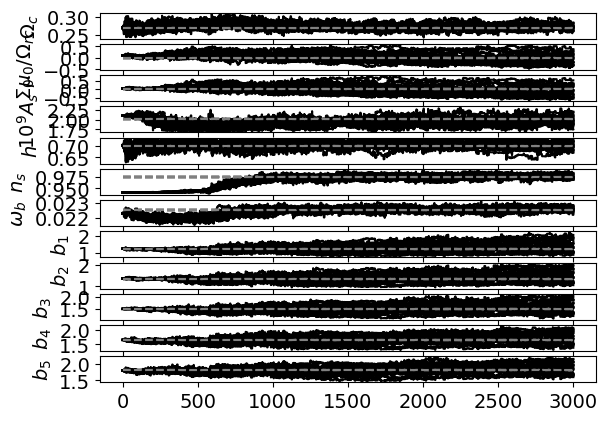

In [146]:
fig, ax = plt.subplots(len(sampler_scalecut_arr[0, 0, :]), sharex=True)

for i in range(len(sampler_scalecut_arr)):
    for j in range(len(sampler_scalecut_arr[0, 0, :])):
        ax[j].plot(sampler_scalecut_arr[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_scalecut_arr[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        

In [23]:
### get sigma8 ####
def sigma_8_musigma_int(cosmo, MGparams, a):
    k_val = np.logspace(-4,3,3000)
    return np.sqrt(scipy.integrate.trapz(k_val**2 *P_k_musigma(cosmo, MGparams, k_val, a)*\
                           (3*scipy.special.spherical_jn(1, k_val*8/cosmo["h"], derivative=False)/(k_val*8/cosmo["h"]))**2,\
                           x=k_val)/(2*np.pi**2))
def sigma_8_nDGP_int(cosmo, MGparams, a):
    k_val = np.logspace(-4,3,3000)
    return np.sqrt(scipy.integrate.trapz(k_val**2 *P_k_nDGP_lin(cosmo, MGparams, k_val, a)*\
                           (3*scipy.special.spherical_jn(1, k_val*8/cosmo["h"], derivative=False)/(k_val*8/cosmo["h"]))**2,\
                           x=k_val)/(2*np.pi**2))

sigma8_chain = np.zeros(sampler_scalecut_arr[:, :, 0].shape)
S8_chain = np.zeros(sampler_scalecut_arr[:, :, 0].shape)

for i in tqdm(range(len(sampler_scalecut_arr[0, :, 0]))):
    for j in range(len(sampler_scalecut_arr[:, 0, 0])):
        cosmo_postprocessing = ccl.Cosmology(Omega_c = sampler_scalecut_arr[j, i, 0],
                           Omega_b =  sampler_scalecut_arr[j, i, 5]/sampler_scalecut_arr[j, i, 3]**2,
                           h = sampler_scalecut_arr[j, i, 3],
                           n_s = sampler_scalecut_arr[j, i, 4],
                           A_s = sampler_scalecut_arr[j, i, 2])
        sigma8_MG = sigma_8_musigma_int(cosmo_postprocessing, [0.0,0.0,0.0,sampler_scalecut_arr[j, i, 1]], 1)
        sigma8_chain[j,i] = sigma8_MG
        S8_chain[j,i] = sigma8_MG * np.sqrt(cosmo_postprocessing["Omega_m"]/0.3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [2:43:57<00:00,  2.19s/it]


In [24]:
np.save("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/sigma8_nDGP_DEParam_scalecut.npy", sigma8_chain)
np.save("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/S8_nDGP_DEParam_scalecut.npy", S8_chain)

In [48]:
sampler_scalecut_arr = np.append(np.append(sampler_scalecut_arr, \
    (sigma8_chain/np.sqrt(1e9)).reshape(25,4500,1), axis = 2), (S8_chain/np.sqrt(1e9)).reshape(25,4500,1), axis = 2)

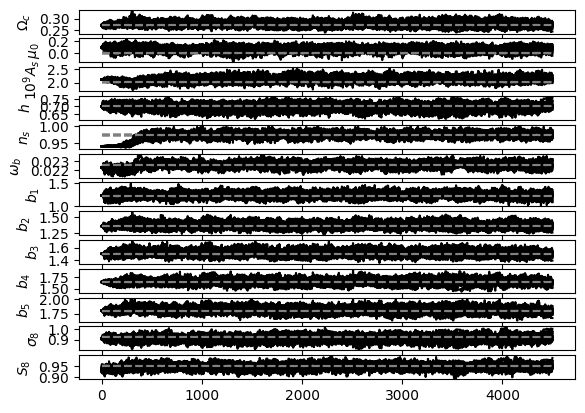

In [49]:
fig, ax = plt.subplots(len(sampler_scalecut_arr[0, 0, :]), sharex=True)
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$', r'$\sigma_8$', r'$S_8$']

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0,cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0],sigma_8_nDGP_int(cosmo_universe, [1.0,0.0,0.0,0.0], 1),\
         sigma_8_nDGP_int(cosmo_universe, [1.0,0.0,0.0,0.0], 1)*np.sqrt(cosmo_universe["Omega_m"]/0.3)]

for i in range(len(sampler_scalecut_arr)):
    for j in range(len(sampler_scalecut_arr[0, 0, :])):
        ax[j].plot(sampler_scalecut_arr[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_scalecut_arr[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        

In [44]:
print(value1)

[0.27, 0.0, 2.01, 0.7, 0.974, 0.022539999999999998, 1.229, 1.362, 1.502, 1.648, 1.799, 0.9247492033061779, 0.9490888685626685]


In [144]:
labels = [r"$\Omega_c$", r"$\mu_0 / \Omega_{rc}$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0, cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0]]

        

(50000, 12)


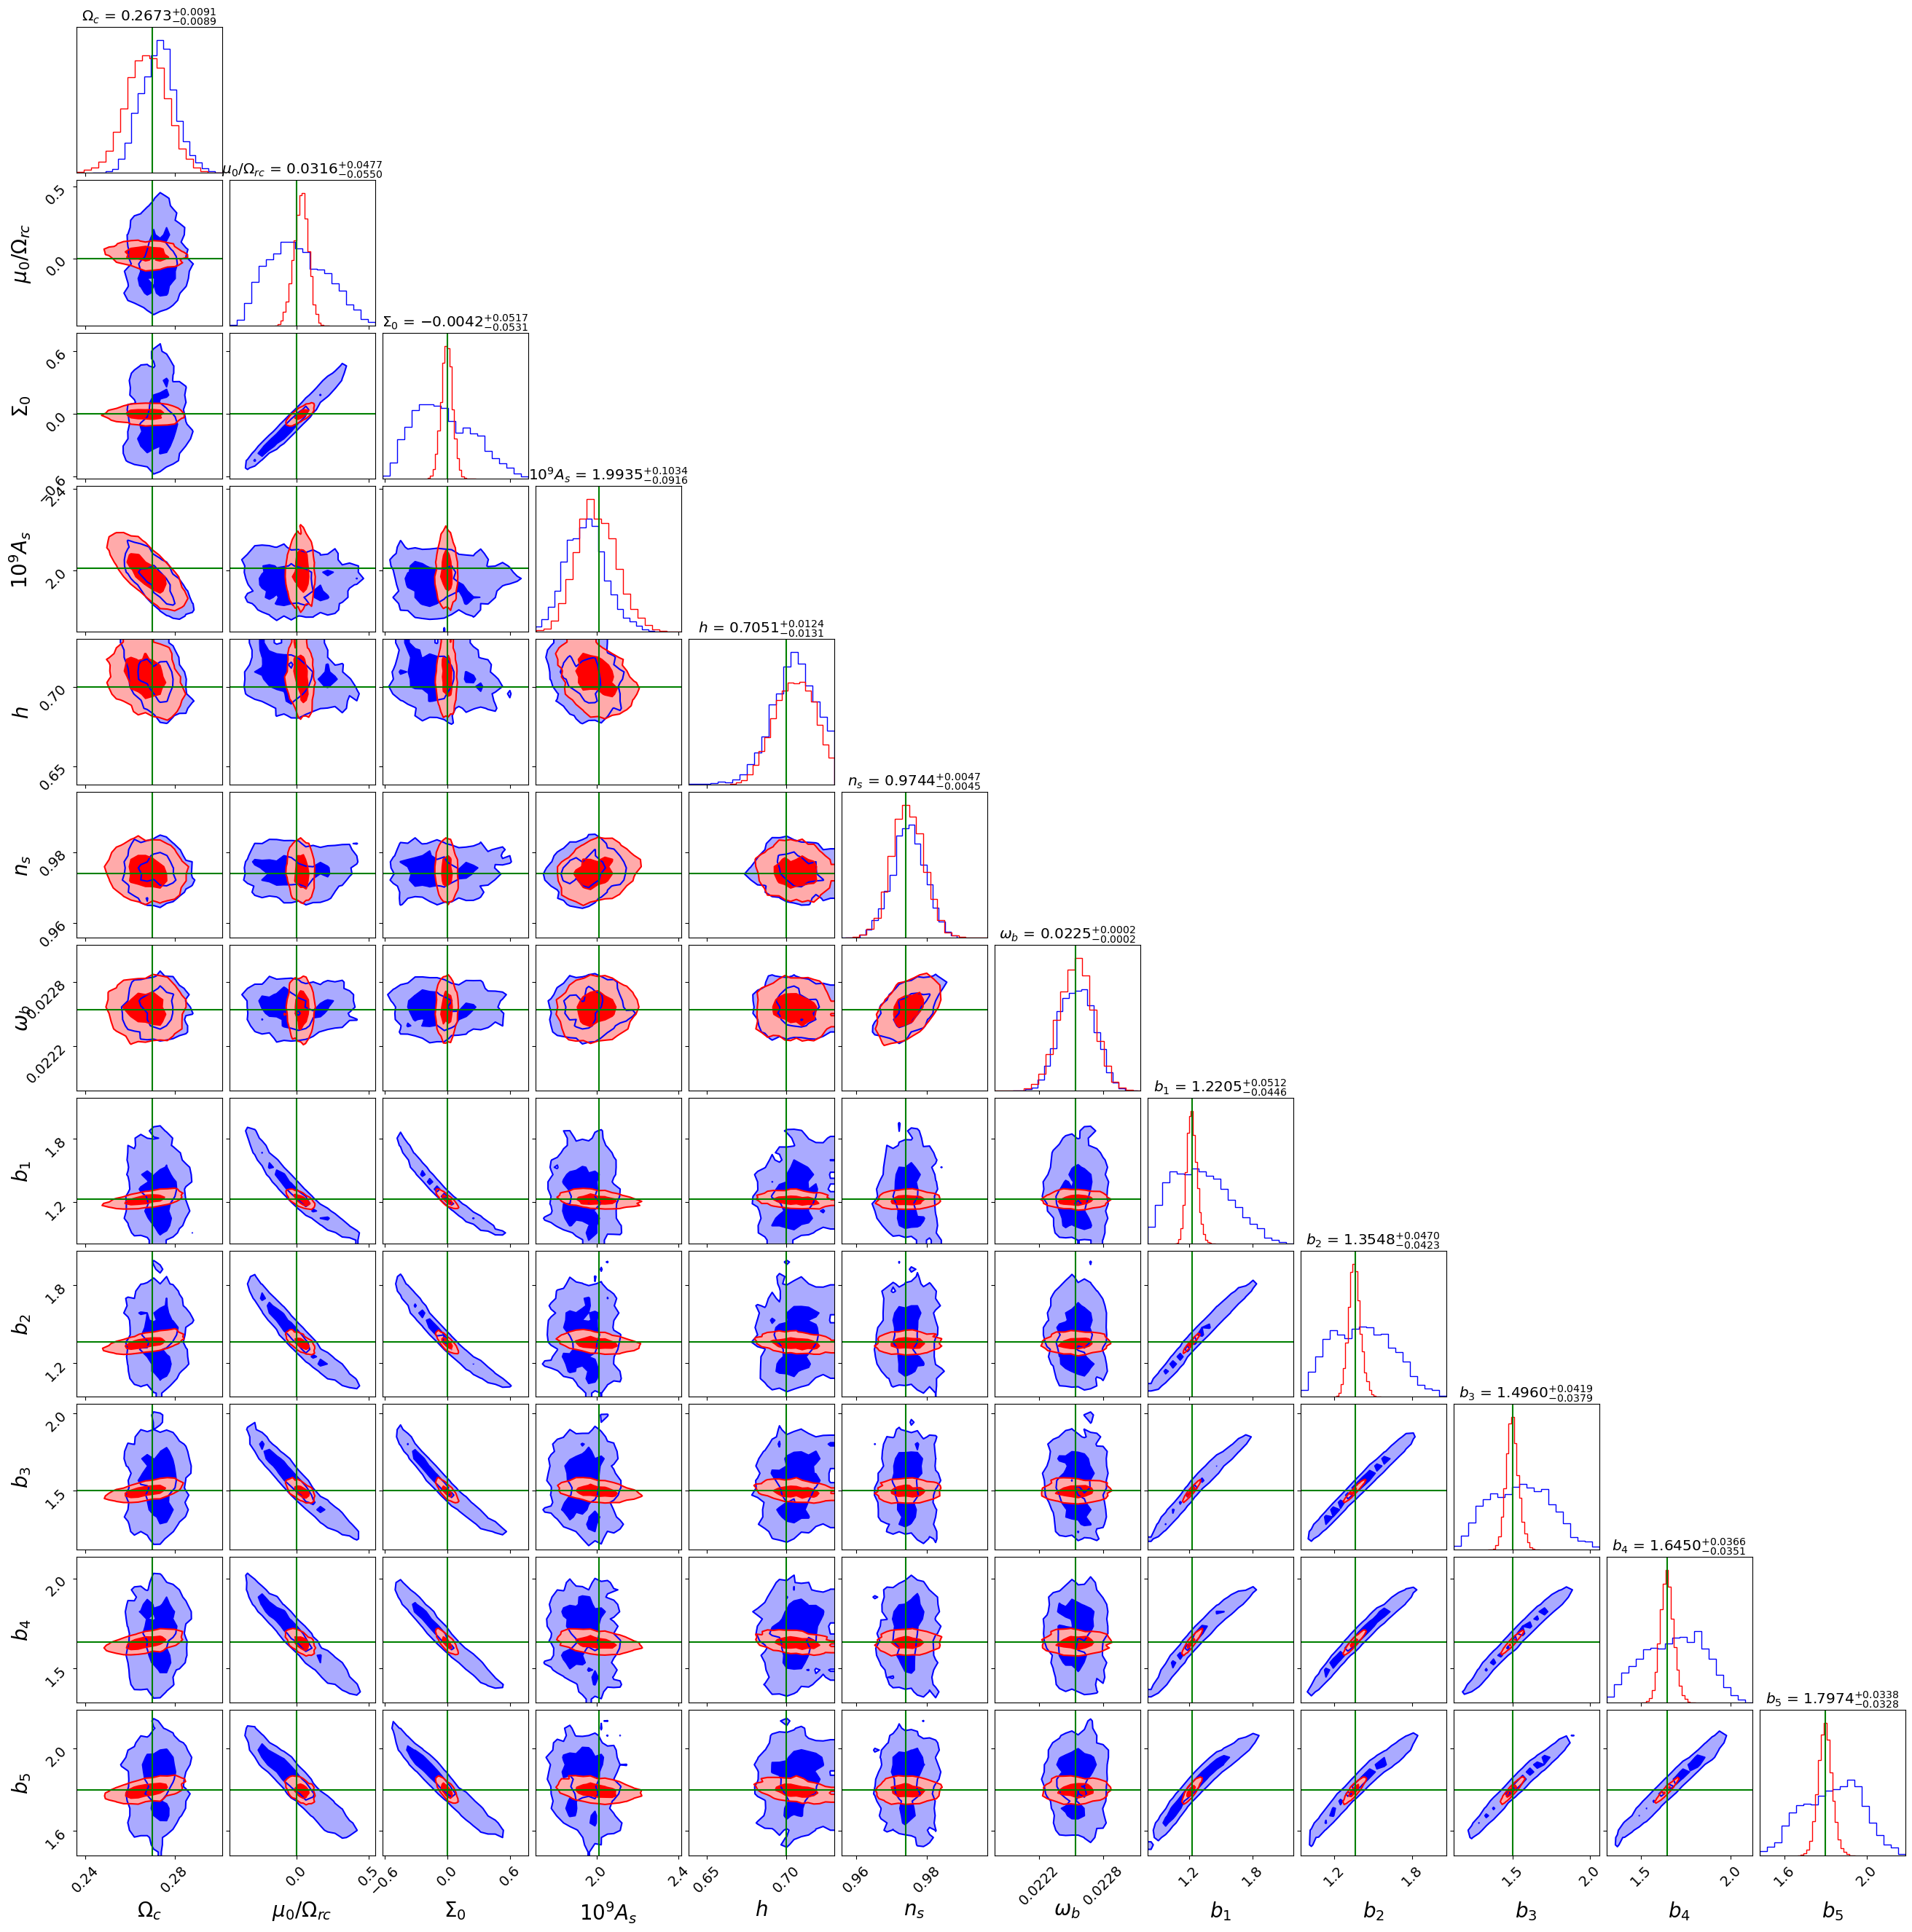

In [150]:
### STANDARD CUTS ####
burnin = 1000
ndim = len(labels)
final_length_scalecut = len(sampler_scalecut_arr)*(len(sampler_scalecut_arr[0])-burnin)

CORNER_KWARGS_scalecut = dict(
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_density=False,
    plot_datapoints=False,
    plot_contours=True,
    fill_contours=True)


flat_samples = sampler_scalecut_arr[:,burnin:].reshape(final_length_scalecut,ndim)

figure = corner.corner(
    flat_samples, **CORNER_KWARGS_scalecut, labels=labels, color="b"
);

### PCA ####

burnin = 1000
ndim = len(labels)
final_length = len(sampler_PCA_arr)*(len(sampler_PCA_arr[0])-burnin)
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=14.5),
    show_titles=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    weights = np.ones(final_length) * (final_length_scalecut / final_length)

)

flat_samples = sampler_PCA_arr[:,burnin:].reshape(final_length,ndim)

print(flat_samples.shape)

corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, fig=figure, color = "r"
);

######################

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")

#plt.savefig("/home/c2042999/PCA_project/3x2pt_fsigma8_Planckpriors_fR_cutcompare.pdf", bbox_inches='tight')

In [103]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Old Code

### tests correlation #####

In [69]:
labels = [r"$\Omega_c$", r"$\mu_0 / \Omega_{rc}$",r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0, cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0]]

mean = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    mean.append(mcmc[1])

print(mean)

[0.27637272680074115, 0.06816506363481538, 2.1205526981435647, 0.694539477172393, 0.9743523047204532, 0.02262303666470148, 1.2374821573564994, 1.3746086443928733, 1.5166251705845664, 1.6556215044805374, 1.8068076315651296]


In [41]:
sampler_scalecut_arr = np.load("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/nDGP_DEParam_scalecut.npy")
burnin = 1000

ndim = len(labels)

final_length = len(sampler_scalecut_arr)*(len(sampler_scalecut_arr[0])-burnin)

flat_samples = sampler_scalecut_arr[:,burnin:].reshape(final_length,ndim)
print(flat_samples.shape)

In [72]:
print(flat_samples.shape)
print(np.cov(flat_samples.T))

(87500, 11)
[[ 1.37241273e-04 -1.03677037e-04 -6.07399135e-04 -2.08931292e-04
  -8.24467381e-06 -2.51032013e-07  4.13033545e-04  4.54268418e-04
   4.47776994e-04  5.94651742e-04  5.08702802e-04]
 [-1.03677037e-04  1.76286176e-03 -1.17427177e-03  1.33548621e-04
  -1.69666017e-05 -4.88379217e-07 -4.12557527e-04 -1.46035442e-04
  -5.65662952e-05  1.25415269e-04  1.58532208e-04]
 [-6.07399135e-04 -1.17427177e-03  9.38238506e-03  3.44648524e-05
   2.68872331e-04  4.65424204e-06 -1.65610330e-03 -1.82803704e-03
  -1.62626922e-03 -2.75497589e-03 -2.04213289e-03]
 [-2.08931292e-04  1.33548621e-04  3.44648524e-05  4.93293874e-04
  -1.97699903e-05  6.85395213e-08 -6.65592607e-04 -7.82695771e-04
  -8.25393962e-04 -1.01952101e-03 -9.41244214e-04]
 [-8.24467381e-06 -1.69666017e-05  2.68872331e-04 -1.97699903e-05
   5.13980055e-05  1.04088363e-06 -9.01379470e-06 -1.39781496e-05
  -1.60233604e-05 -1.32939877e-05 -8.41307715e-06]
 [-2.51032013e-07 -4.88379217e-07  4.65424204e-06  6.85395213e-08
   1.04

In [73]:
df = pd.DataFrame(flat_samples, columns=labels, index=np.arange(0,len(flat_samples)))
print(df.head())

   $\Omega_c$  $\mu_0 / \Omega_{rc}$  $10^{9}A_s$       $h$     $n_s$  \
0    0.279773               0.112709     2.105487  0.675283  0.977861   
1    0.280628               0.110776     2.099131  0.675101  0.976389   
2    0.280628               0.110776     2.099131  0.675101  0.976389   
3    0.280628               0.110776     2.099131  0.675101  0.976389   
4    0.282359               0.111998     2.090269  0.673001  0.976481   

   $\omega_b$     $b_1$     $b_2$     $b_3$     $b_4$     $b_5$  
0    0.022108  1.208415  1.401732  1.544271  1.689624  1.861527  
1    0.022081  1.211211  1.404235  1.542978  1.695261  1.860751  
2    0.022081  1.211211  1.404235  1.542978  1.695261  1.860751  
3    0.022081  1.211211  1.404235  1.542978  1.695261  1.860751  
4    0.022118  1.242664  1.423183  1.547156  1.701338  1.861256  


In [83]:
C = np.cov(flat_samples.T)

chain2 = Chain.from_covariance(
    mean, C,
    plot_contour=True, columns=labels, 
    color='blue', name=r'from covariance', 
    linewidth=1, linestyle='-'
)

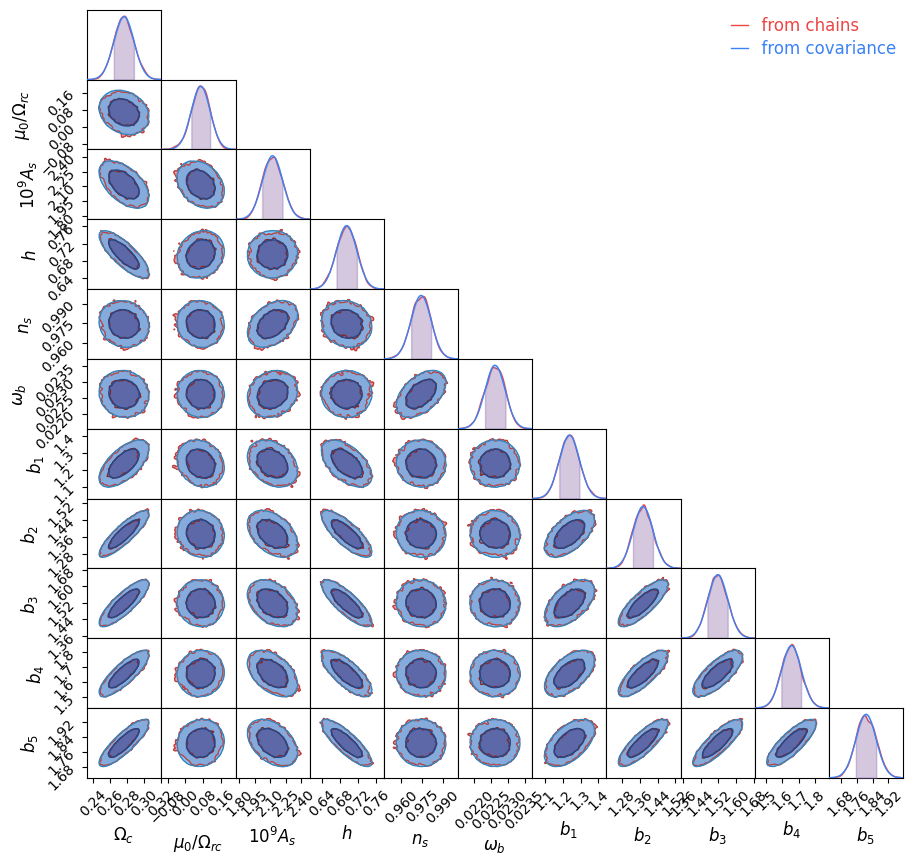

In [84]:
c = ChainConsumer()
c.add_chain(Chain(samples=df, color="r", name="from chains"))
c.add_chain(chain2)
fig = c.plotter.plot(figsize = 0.3)
